# ALBERT Pretraining Notebook


Trained with Google TPU v2

#Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Importing

#Installs
!pip install pyarrow fastparquet

# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import os
from IPython.display import clear_output

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from keras.layers.embeddings import Embedding
from keras.metrics import AUC

# Tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 915.5 kB/s eta 0:00:00


In [ ]:
#@title Random Seeds
import random
## SEEDS

# Hard Code Random Seeds.
r1 = 0
r2 = 1

# Set Random Seed
random.seed(r1)
tf.random.set_seed(r2)

In [ ]:
#@title Connect to TPU
print("TensorFlow version:", tf.__version__)

# Connect to the TPU cluster or fall back to CPU/GPU
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Tries to connect to the TPU
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  devices = tf.config.list_logical_devices('TPU')
  print('TPU devices:', devices)
except ValueError:
  print("Could not connect to TPU; using CPU/GPU strategy instead.")
  strategy = tf.distribute.get_strategy()

# Example computation using the strategy
with strategy.scope():
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

  @tf.function
  def matmul_fn(x, y):
    return tf.matmul(x, y)

  z = strategy.run(matmul_fn, args=(a, b))

print(z)

TensorFlow version: 2.15.0
TPU devices: [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
PerReplica:{
  0: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  1: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  2: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  3: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  4: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  5: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  6: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  7: tf.

# Hyperparameters & Settings (Fill out)


In [ ]:
# write where you want to save all your files
root = "/content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/ALBERT Experiments /ALBERT Pretraining/Encoders"

In [ ]:
"""
Please Fill out Parameters Below
"""
## Model size
# eg. ["small", "medium", "large", "huge"]
size = "small"

## Mask ratio
# eg. [.25, .50, .75]
mask_ratio = 0.25

## Smoothing
# eg. [True, False]
smoothing = False

## Loss Function
# eg. [True, False], meaning MSE on only the masked portion or everything in the reconstruction
mse_only_masked = False

In [ ]:
# Model naming
mask_name = int(mask_ratio*100)

name = f"/encoder_{size}_{mask_name}"

if smoothing == True:
  name = f"{name}_smoothed"
else:
  name = f"{name}_unsmoothed"

if mse_only_masked == True:
  name = f"{name}_mse_only_masked.h5"
else:
  name = f"{name}_mse_all.h5"

In [ ]:
print(name)

/encoder_small_25_unsmoothed_mse_all.h5


# Hyperparameter Additional Info

In [ ]:
"""
Model Size
"""
## Model Size
if size == "small":

  patch_size = 18
  embed_dim = 96
  # encoder
  encoder_num_heads = 6
  encoder_ff_dim = 256
  encoder_num_layers = 1
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 6
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

if size == "medium":

  patch_size = 18
  embed_dim = 96
  # encoder
  encoder_num_heads = 12
  encoder_ff_dim = 256
  encoder_num_layers = 2
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 12
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

if size == "large":

  patch_size = 9
  embed_dim = 96
  # encoder
  encoder_num_heads = 12
  encoder_ff_dim = 256
  encoder_num_layers = 4
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 12
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

if size == "huge":

  patch_size = 5
  embed_dim = 96
  # encoder
  encoder_num_heads = 12
  encoder_ff_dim = 256
  encoder_num_layers = 8
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 12
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

In [ ]:
"""
For Pretraining
"""

## Model Size
if size == "small":

  learning_rate = 0.001
  early_stopping_patience = 250
  reduce_lr_patience = 75
  min_lr = 1e-4

if size == "medium":

  learning_rate = 0.001
  early_stopping_patience = 250
  reduce_lr_patience = 75
  min_lr = 1e-4

if size == "large":

  learning_rate = 0.0001
  early_stopping_patience = 500
  reduce_lr_patience = 100
  min_lr = 1e-5


if size == "huge":

  learning_rate = 0.00001
  early_stopping_patience = 500
  reduce_lr_patience = 100
  min_lr = 1e-6

In [ ]:
"""
Smoothing
"""
if smoothing == True:
  data = pd.read_parquet('/content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/Data Preprocessing/SelfSupervised Datasets/Smooth/[SelfSupervised][Smooth]WideSeqnActi_AndMeds_2013.parq')

else:
  data = pd.read_parquet('/content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/Data Preprocessing/SelfSupervised Datasets/Raw/[SelfSupervised][Raw]WideSeqnActi_AndMeds_2013.parq')

# Process Data

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into train and temp (this temp will be split into validation and test)
X_train, X_test = train_test_split(np.array(data), test_size=0.005, random_state=19, shuffle=True)


# Reshape Train and Test
n_participants_train = X_train.shape[0]
n_participants_test = X_test.shape[0]
n_timesteps = X_train.shape[1]
n_features = 1

# Reshape data
X_train = X_train.reshape((n_participants_train, n_timesteps, n_features))
X_test = X_test.reshape((n_participants_test, n_timesteps, n_features))

In [ ]:
X_train.shape

(21430, 10080, 1)

In [ ]:
X_test.shape

(108, 10080, 1)

# Autoencoder


#MAE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Modified Transformer Block to output attention weights with explicit layer names
def TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1, name_prefix="encoder"):
    # Input
    input_layer = layers.Input(shape=(None, embed_dim), name=f"{name_prefix}_input")
    #Attention
    attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{name_prefix}_attention")
    attention_output, attention_weights = attention_layer(input_layer, input_layer, return_attention_scores=True)
    attention_output = layers.Dropout(rate, name=f"{name_prefix}_dropout")(attention_output)
    # Add + Norm
    out1 = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_norm1")(input_layer + attention_output)
    # FF Network
    ff_output = layers.Dense(ff_dim, activation="relu", name=f"{name_prefix}_ff1")(out1)
    ff_output = layers.Dense(embed_dim, name=f"{name_prefix}_ff2")(ff_output)
    ff_output = layers.Dropout(rate, name=f"{name_prefix}_dropout2")(ff_output)
    # Add + Norm
    final_output = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_norm2")(out1 + ff_output)
    return models.Model(inputs=input_layer, outputs=[final_output, attention_weights], name=f"{name_prefix}_transformer")

# Custom Layer to create and apply the mask for MAE
class MaskLayer(layers.Layer):
    def __init__(self, mask_ratio, embed_dim, **kwargs):
        super(MaskLayer, self).__init__(**kwargs)
        self.mask_ratio = mask_ratio
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.mask_token = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer='random_normal',
            trainable=True,
            name='mask_token'
        )

    def call(self, patch_embeddings, positional_embeddings):
        batch_size = tf.shape(patch_embeddings)[0]
        num_patches = tf.shape(patch_embeddings)[1]

        shuffled_indices = tf.random.shuffle(tf.range(num_patches))
        num_masked = tf.cast(tf.math.round(self.mask_ratio * tf.cast(num_patches, tf.float32)), tf.int32)

        masked_indices = shuffled_indices[:num_masked]
        visible_indices = shuffled_indices[num_masked:]

        visible_patches = tf.gather(patch_embeddings, indices=visible_indices, axis=1)
        masked_patches = tf.gather(patch_embeddings, indices=masked_indices, axis=1)
        visible_positional_embeddings = tf.gather(positional_embeddings, indices=visible_indices, axis=0)

        return visible_patches, masked_patches, visible_positional_embeddings, shuffled_indices, masked_indices

# Custom Layer to create mask tokens for the decoder
class MaskTokenLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MaskTokenLayer, self).__init__(**kwargs)

    def call(self, mask_token, masked_patches):
        tiled_mask_tokens = tf.tile(mask_token, [tf.shape(masked_patches)[0], tf.shape(masked_patches)[1], 1])
        return tiled_mask_tokens

# Custom Layer to concatenate tensors
class ConcatLayer(layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ConcatLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.concat(inputs, axis=self.axis)

# Unshuffling Layer to revert the shuffle applied during masking
class UnshuffleLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(UnshuffleLayer, self).__init__(**kwargs)

    def call(self, patches, shuffle_indices):
        num_patches = tf.shape(shuffle_indices)[0]

        reverse_indices = tf.scatter_nd(
            tf.expand_dims(shuffle_indices, axis=-1),
            tf.range(num_patches),
            [num_patches]
        )

        unshuffled_patches = tf.gather(patches, indices=reverse_indices, axis=1)

        return unshuffled_patches

# Sine/Cosine positional embeddings
def get_positional_embeddings(num_patches, embed_dim):
    position = tf.range(num_patches, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, embed_dim, 2, dtype=tf.float32) * (-tf.math.log(10000.0) / embed_dim))
    pos_embeddings = tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)
    return pos_embeddings

# Custom Layer to calculate MSE only on masked portions
class MaskedMSELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MaskedMSELayer, self).__init__(**kwargs)

    def call(self, y_true, y_pred, masked_indices, mse_only_masked):

        if mse_only_masked:
            y_true_flat = tf.reshape(y_true, [-1])
            y_pred_flat = tf.reshape(y_pred, [-1])

            y_true_masked = tf.gather(y_true_flat, masked_indices)
            y_pred_masked = tf.gather(y_pred_flat, masked_indices)

            mse_loss = tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))
        else:
            mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        return mse_loss

# Model creation function
def create_model(input_size=10080, patch_size=patch_size, embed_dim=embed_dim,
                 encoder_num_heads=encoder_num_heads, encoder_ff_dim=encoder_ff_dim, encoder_num_layers=encoder_num_layers, encoder_rate=encoder_rate,
                 decoder_num_heads=decoder_num_heads, decoder_ff_dim=decoder_ff_dim, decoder_num_layers=decoder_num_layers, decoder_rate=decoder_rate,
                 mask_ratio=mask_ratio, mse_only_masked=mse_only_masked, return_attention=False):

    num_patches = input_size // patch_size
    inputs = layers.Input(shape=(input_size,), name="inputs")
    reshaped = layers.Reshape((num_patches, patch_size), name="reshape")(inputs)
    patch_embeddings = layers.Dense(embed_dim, name="dense")(reshaped)

    positional_embeddings = get_positional_embeddings(num_patches, embed_dim)

    mask_layer = MaskLayer(mask_ratio, embed_dim, name="mask_layer")
    visible_patches, masked_patches, visible_positional_embeddings, shuffle_indices, masked_indices = mask_layer(patch_embeddings, positional_embeddings)

    x = visible_patches + visible_positional_embeddings
    attention_weights = []

    for i in range(encoder_num_layers):
        x, weights = TransformerBlock(embed_dim, encoder_num_heads, encoder_ff_dim, encoder_rate, name_prefix=f"encoder_layer_{i+1}")(x)
        if return_attention:
            attention_weights.append(weights)

    mask_token_layer = MaskTokenLayer(name="mask_token_layer")
    mask_tokens = mask_token_layer(mask_layer.mask_token, masked_patches)

    decoder_input = ConcatLayer(axis=1, name="concat_layer")([x, mask_tokens])

    unshuffle_layer = UnshuffleLayer(name="unshuffle_layer")
    decoder_input_unshuffled = unshuffle_layer(decoder_input, shuffle_indices)

    decoder_input_with_pos = decoder_input_unshuffled + positional_embeddings

    y = decoder_input_with_pos
    for i in range(decoder_num_layers):
        y, _ = TransformerBlock(embed_dim, decoder_num_heads, encoder_ff_dim, decoder_rate, name_prefix=f"decoder_layer_{i+1}")(y)

    outputs = layers.Dense(patch_size, activation='tanh', name="decoder_dense")(y)
    outputs = 2 * outputs #nothing above 2 standard deviations we'll just categorize as the same
    outputs = layers.Reshape((input_size,), name="decoder_reshape")(outputs)

    masked_mse_layer = MaskedMSELayer(name="masked_mse_layer")
    loss = masked_mse_layer(inputs, outputs, masked_indices, mse_only_masked)

    model = models.Model(inputs=inputs, outputs=outputs, name="MAE_model")
    model.add_loss(loss)

    if return_attention:
        return models.Model(inputs=inputs, outputs=[outputs] + attention_weights, name="MAE_with_attention")
    else:
        return model


with strategy.scope():
    model = create_model()

    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False))

model.summary()

Model: "MAE_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 10080)]              0         []                            
                                                                                                  
 reshape (Reshape)           (None, 560, 18)              0         ['inputs[0][0]']              
                                                                                                  
 dense (Dense)               (None, 560, 96)              1824      ['reshape[0][0]']             
                                                                                                  
 mask_layer (MaskLayer)      ((None, 420, 96),            96        ['dense[0][0]']               
                              (None, 140, 96),                                            

# Train Model

Epoch 1/10000
151/151 [==============================] - 28s 96ms/step - loss: 0.9842 - val_loss: 0.9904 - lr: 0.0010
Epoch 2/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.8223 - val_loss: 0.9848 - lr: 0.0010
Epoch 3/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.8135 - val_loss: 0.9795 - lr: 0.0010
Epoch 4/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.8064 - val_loss: 0.9746 - lr: 0.0010
Epoch 5/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.7975 - val_loss: 0.9735 - lr: 0.0010
Epoch 6/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.7883 - val_loss: 0.9568 - lr: 0.0010
Epoch 7/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.7642 - val_loss: 0.9115 - lr: 0.0010
Epoch 8/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.7281 - val_loss: 0.8883 - lr: 0.0010
Epoch 9/10000
151/151 [==============================] - 5s 35m

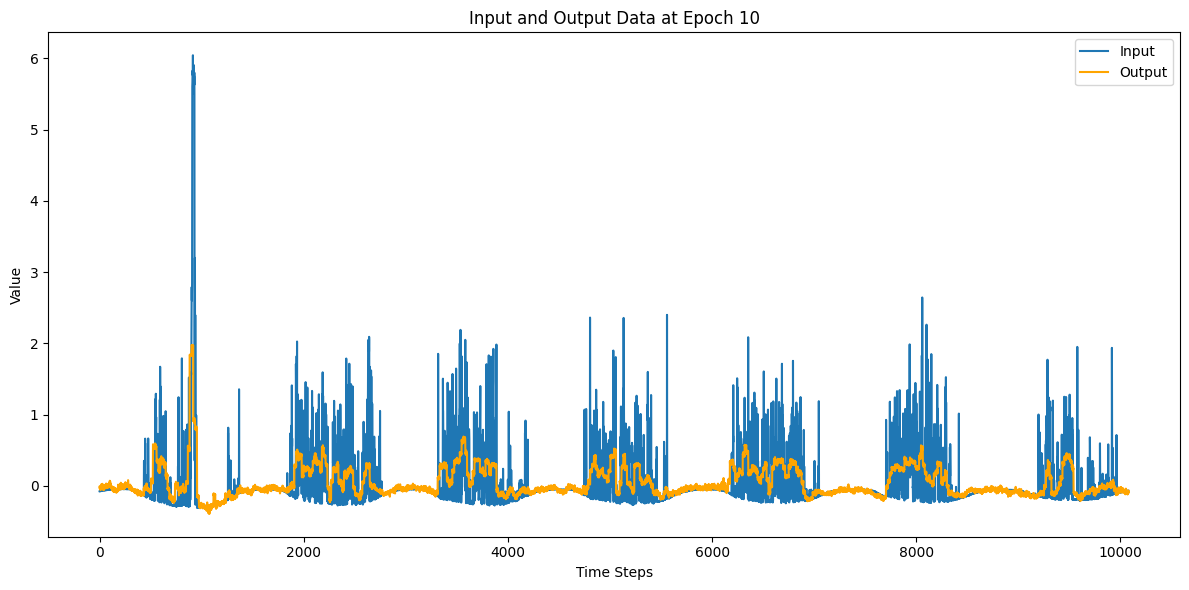

151/151 [==============================] - 8s 53ms/step - loss: 0.6794 - val_loss: 0.8475 - lr: 0.0010
Epoch 11/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.6667 - val_loss: 0.8358 - lr: 0.0010
Epoch 12/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.6620 - val_loss: 0.8348 - lr: 0.0010
Epoch 13/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.6567 - val_loss: 0.8259 - lr: 0.0010
Epoch 14/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.6516 - val_loss: 0.8250 - lr: 0.0010
Epoch 15/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.6407 - val_loss: 0.8029 - lr: 0.0010
Epoch 16/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.6301 - val_loss: 0.7935 - lr: 0.0010
Epoch 17/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.6220 - val_loss: 0.7891 - lr: 0.0010
Epoch 18/10000
151/151 [==============================] - 5s 35ms/step 

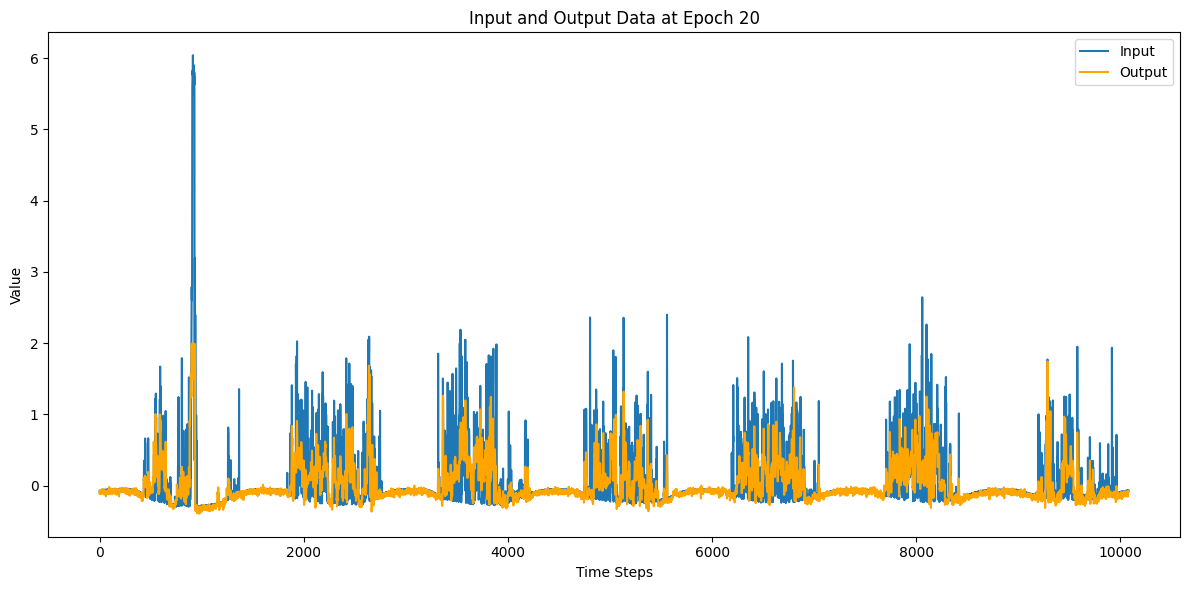

151/151 [==============================] - 6s 41ms/step - loss: 0.6077 - val_loss: 0.7774 - lr: 0.0010
Epoch 21/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.6068 - val_loss: 0.7782 - lr: 0.0010
Epoch 22/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.6046 - val_loss: 0.7755 - lr: 0.0010
Epoch 23/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.6007 - val_loss: 0.7691 - lr: 0.0010
Epoch 24/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5964 - val_loss: 0.7641 - lr: 0.0010
Epoch 25/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5931 - val_loss: 0.7634 - lr: 0.0010
Epoch 26/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5907 - val_loss: 0.7623 - lr: 0.0010
Epoch 27/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5899 - val_loss: 0.7635 - lr: 0.0010
Epoch 28/10000
151/151 [==============================] - 5s 34ms/step 

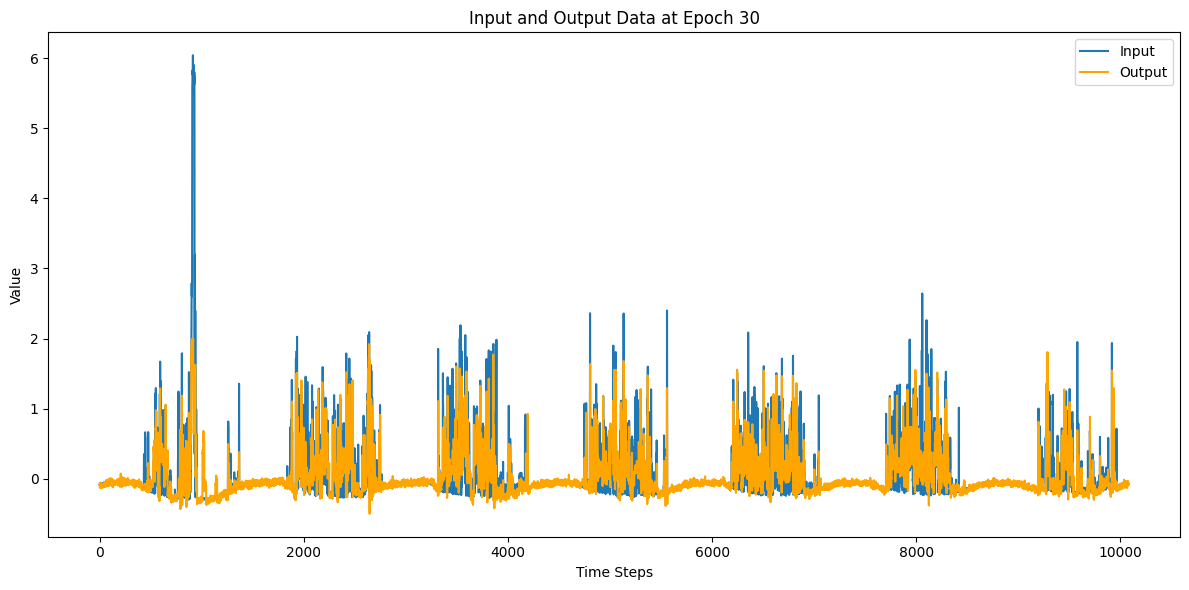

151/151 [==============================] - 6s 41ms/step - loss: 0.5840 - val_loss: 0.7557 - lr: 0.0010
Epoch 31/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5805 - val_loss: 0.7518 - lr: 0.0010
Epoch 32/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5826 - val_loss: 0.7574 - lr: 0.0010
Epoch 33/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5848 - val_loss: 0.7567 - lr: 0.0010
Epoch 34/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5807 - val_loss: 0.7598 - lr: 0.0010
Epoch 35/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5806 - val_loss: 0.7508 - lr: 0.0010
Epoch 36/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5761 - val_loss: 0.7469 - lr: 0.0010
Epoch 37/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5733 - val_loss: 0.7592 - lr: 0.0010
Epoch 38/10000
151/151 [==============================] - 5s 34ms/step 

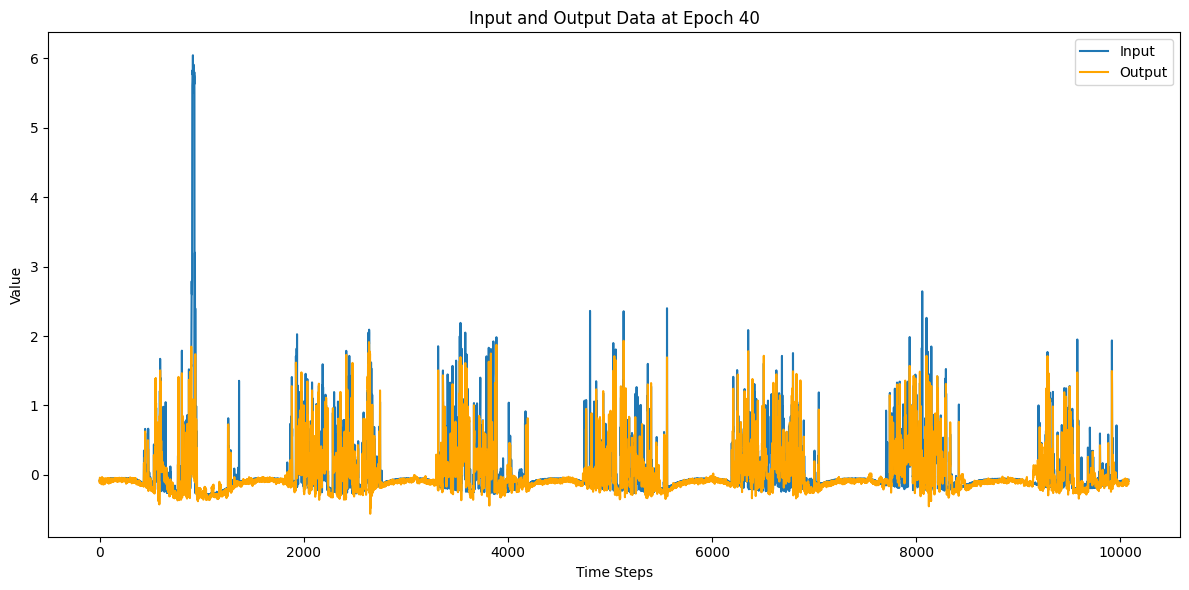

151/151 [==============================] - 7s 44ms/step - loss: 0.5702 - val_loss: 0.7419 - lr: 0.0010
Epoch 41/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5686 - val_loss: 0.7426 - lr: 0.0010
Epoch 42/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5684 - val_loss: 0.7420 - lr: 0.0010
Epoch 43/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5685 - val_loss: 0.7397 - lr: 0.0010
Epoch 44/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5814 - val_loss: 0.7576 - lr: 0.0010
Epoch 45/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5698 - val_loss: 0.7361 - lr: 0.0010
Epoch 46/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5638 - val_loss: 0.7352 - lr: 0.0010
Epoch 47/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5615 - val_loss: 0.7362 - lr: 0.0010
Epoch 48/10000
151/151 [==============================] - 5s 34ms/step 

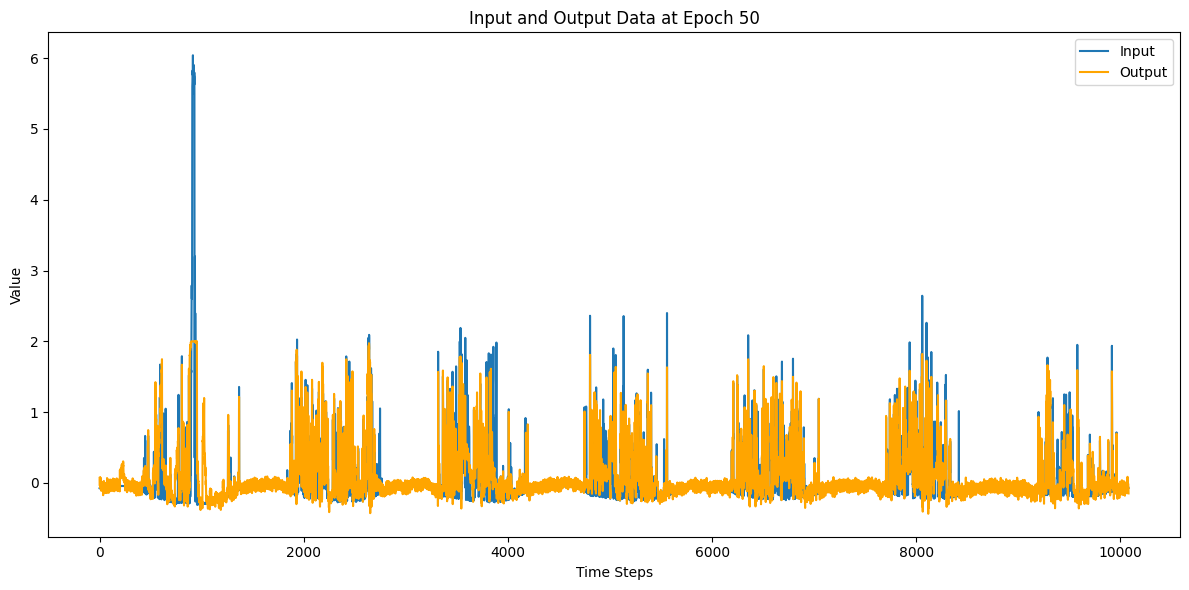

151/151 [==============================] - 6s 41ms/step - loss: 0.5611 - val_loss: 0.7451 - lr: 0.0010
Epoch 51/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5592 - val_loss: 0.7295 - lr: 0.0010
Epoch 52/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5557 - val_loss: 0.7290 - lr: 0.0010
Epoch 53/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5574 - val_loss: 0.7329 - lr: 0.0010
Epoch 54/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5560 - val_loss: 0.7266 - lr: 0.0010
Epoch 55/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5562 - val_loss: 0.7257 - lr: 0.0010
Epoch 56/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5538 - val_loss: 0.7267 - lr: 0.0010
Epoch 57/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5514 - val_loss: 0.7262 - lr: 0.0010
Epoch 58/10000
151/151 [==============================] - 5s 34ms/step 

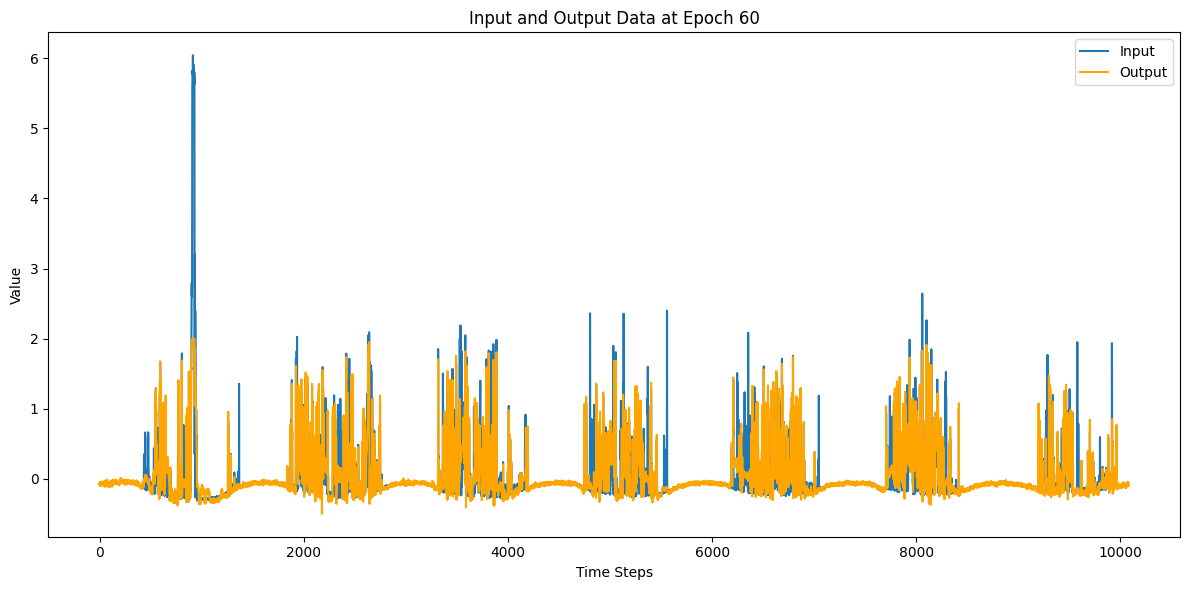

151/151 [==============================] - 6s 41ms/step - loss: 0.5504 - val_loss: 0.7236 - lr: 0.0010
Epoch 61/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5530 - val_loss: 0.7225 - lr: 0.0010
Epoch 62/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5491 - val_loss: 0.7230 - lr: 0.0010
Epoch 63/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5799 - val_loss: 0.7311 - lr: 0.0010
Epoch 64/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5537 - val_loss: 0.7247 - lr: 0.0010
Epoch 65/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5512 - val_loss: 0.7238 - lr: 0.0010
Epoch 66/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5499 - val_loss: 0.7218 - lr: 0.0010
Epoch 67/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5485 - val_loss: 0.7221 - lr: 0.0010
Epoch 68/10000
151/151 [==============================] - 5s 34ms/step 

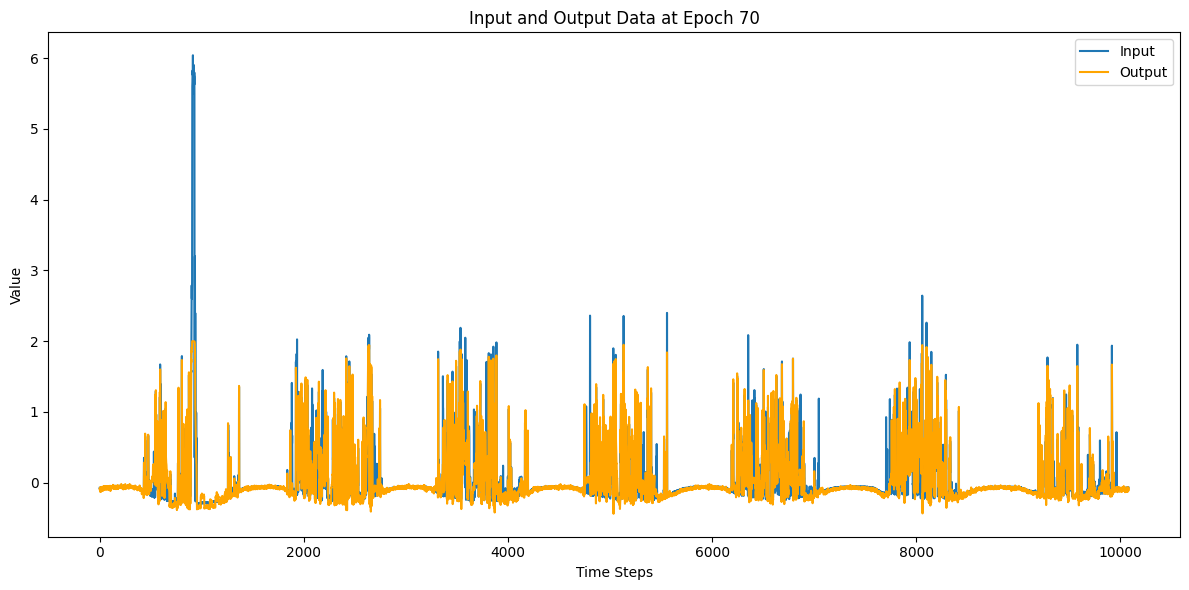

151/151 [==============================] - 6s 42ms/step - loss: 0.5476 - val_loss: 0.7213 - lr: 0.0010
Epoch 71/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5480 - val_loss: 0.7239 - lr: 0.0010
Epoch 72/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5501 - val_loss: 0.7224 - lr: 0.0010
Epoch 73/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5474 - val_loss: 0.7207 - lr: 0.0010
Epoch 74/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5471 - val_loss: 0.7207 - lr: 0.0010
Epoch 75/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5463 - val_loss: 0.7203 - lr: 0.0010
Epoch 76/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5464 - val_loss: 0.7212 - lr: 0.0010
Epoch 77/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5481 - val_loss: 0.7222 - lr: 0.0010
Epoch 78/10000
151/151 [==============================] - 5s 34ms/step 

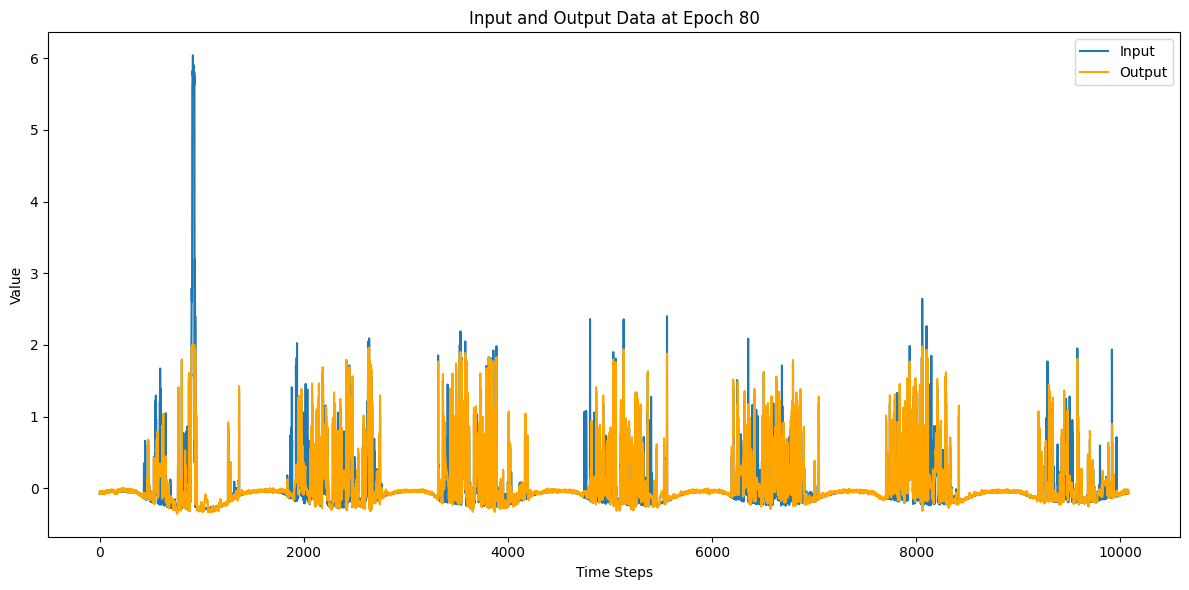

151/151 [==============================] - 6s 41ms/step - loss: 0.5465 - val_loss: 0.7195 - lr: 0.0010
Epoch 81/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5452 - val_loss: 0.7192 - lr: 0.0010
Epoch 82/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5452 - val_loss: 0.7192 - lr: 0.0010
Epoch 83/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5447 - val_loss: 0.7194 - lr: 0.0010
Epoch 84/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5449 - val_loss: 0.7184 - lr: 0.0010
Epoch 85/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5509 - val_loss: 0.7233 - lr: 0.0010
Epoch 86/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5481 - val_loss: 0.7193 - lr: 0.0010
Epoch 87/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5461 - val_loss: 0.7224 - lr: 0.0010
Epoch 88/10000
151/151 [==============================] - 5s 34ms/step 

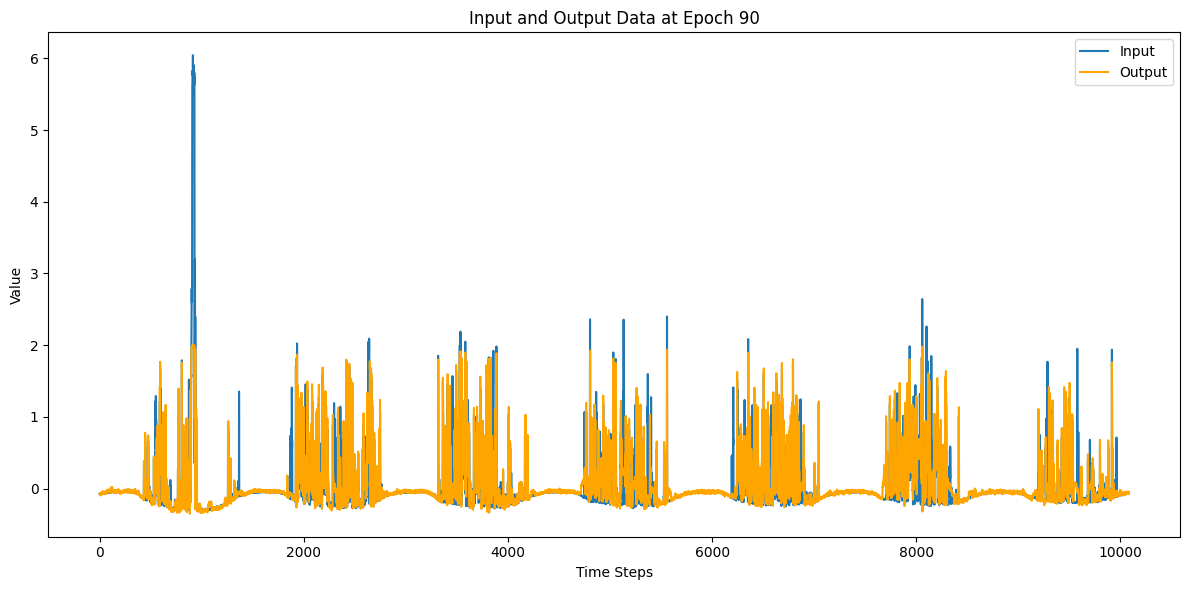

151/151 [==============================] - 7s 45ms/step - loss: 0.5464 - val_loss: 0.7191 - lr: 0.0010
Epoch 91/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5475 - val_loss: 0.7194 - lr: 0.0010
Epoch 92/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5472 - val_loss: 0.7201 - lr: 0.0010
Epoch 93/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5482 - val_loss: 0.7189 - lr: 0.0010
Epoch 94/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5468 - val_loss: 0.7190 - lr: 0.0010
Epoch 95/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5472 - val_loss: 0.7185 - lr: 0.0010
Epoch 96/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5452 - val_loss: 0.7193 - lr: 0.0010
Epoch 97/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5441 - val_loss: 0.7189 - lr: 0.0010
Epoch 98/10000
151/151 [==============================] - 5s 34ms/step 

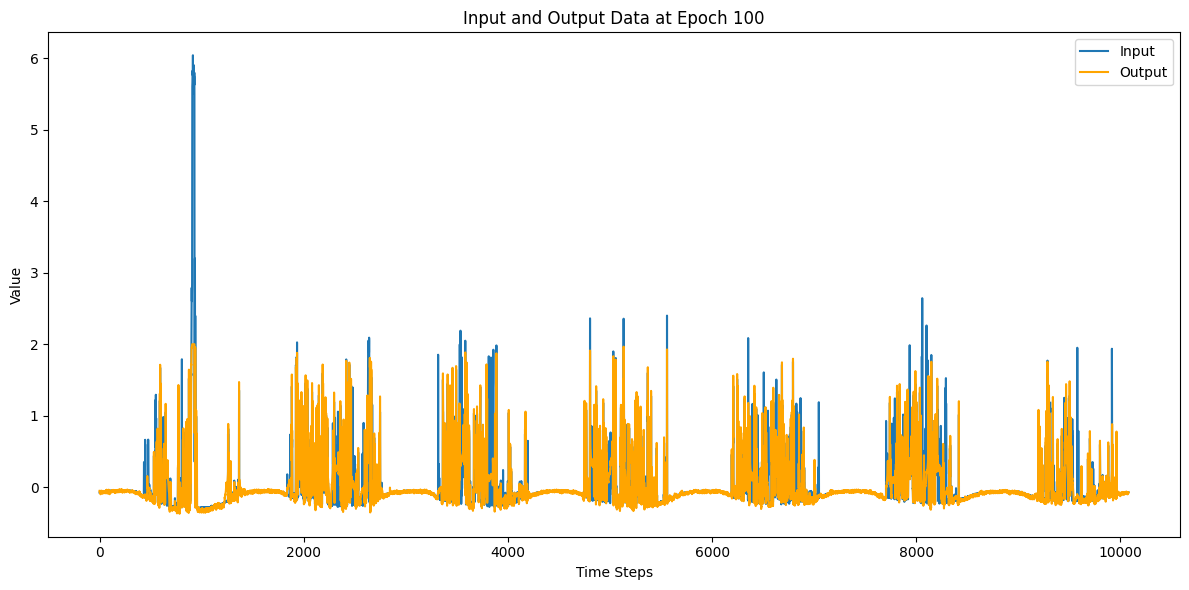

151/151 [==============================] - 6s 41ms/step - loss: 0.5447 - val_loss: 0.7179 - lr: 0.0010
Epoch 101/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5435 - val_loss: 0.7182 - lr: 0.0010
Epoch 102/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5438 - val_loss: 0.7180 - lr: 0.0010
Epoch 103/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5446 - val_loss: 0.7177 - lr: 0.0010
Epoch 104/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5430 - val_loss: 0.7173 - lr: 0.0010
Epoch 105/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5432 - val_loss: 0.7180 - lr: 0.0010
Epoch 106/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5436 - val_loss: 0.7179 - lr: 0.0010
Epoch 107/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5504 - val_loss: 0.7230 - lr: 0.0010
Epoch 108/10000
151/151 [==============================] - 5s 34

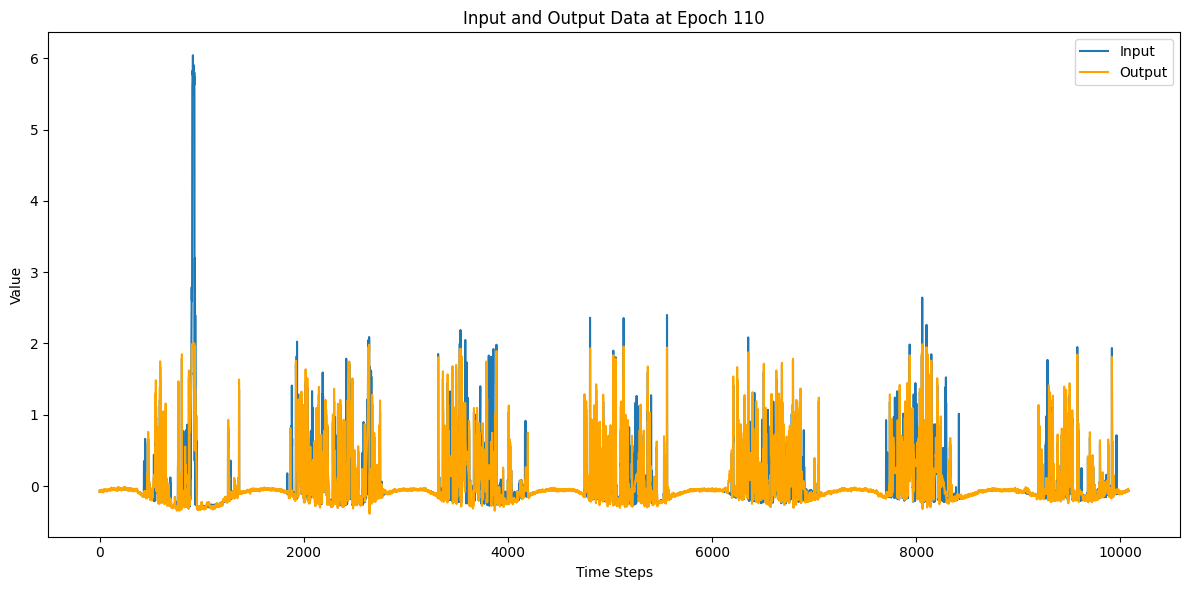

151/151 [==============================] - 6s 40ms/step - loss: 0.5437 - val_loss: 0.7177 - lr: 0.0010
Epoch 111/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5449 - val_loss: 0.7177 - lr: 0.0010
Epoch 112/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5470 - val_loss: 0.7186 - lr: 0.0010
Epoch 113/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5478 - val_loss: 0.7180 - lr: 0.0010
Epoch 114/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5431 - val_loss: 0.7173 - lr: 0.0010
Epoch 115/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5429 - val_loss: 0.7176 - lr: 0.0010
Epoch 116/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5480 - val_loss: 0.7180 - lr: 0.0010
Epoch 117/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5474 - val_loss: 0.7184 - lr: 0.0010
Epoch 118/10000
151/151 [==============================] - 6s 38

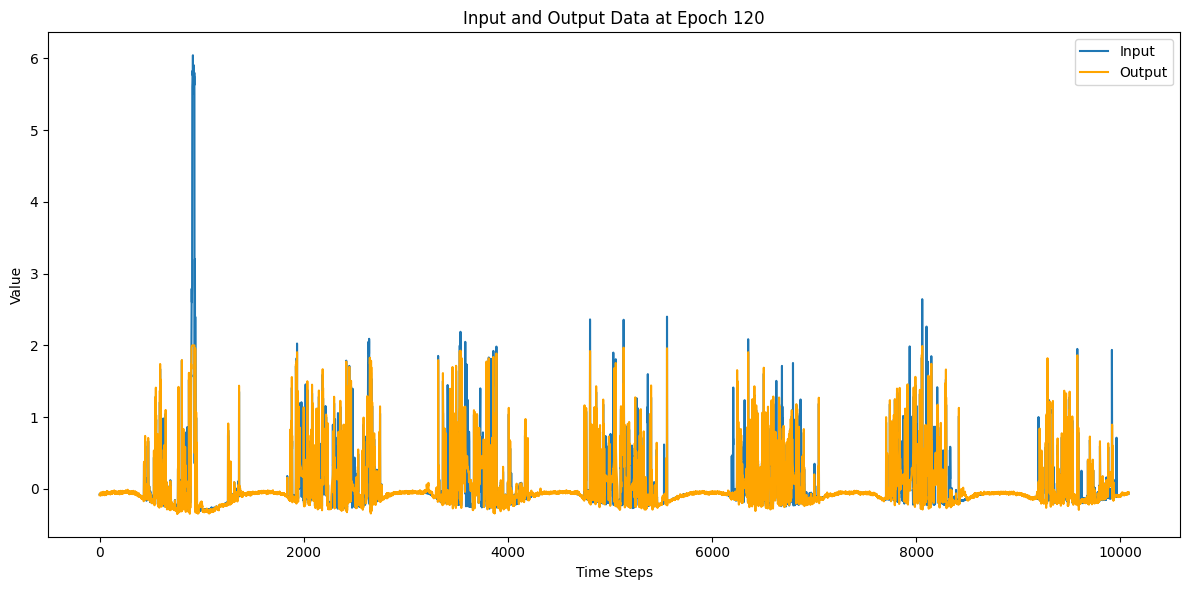

151/151 [==============================] - 6s 41ms/step - loss: 0.5457 - val_loss: 0.7173 - lr: 0.0010
Epoch 121/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5430 - val_loss: 0.7169 - lr: 0.0010
Epoch 122/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5424 - val_loss: 0.7166 - lr: 0.0010
Epoch 123/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5442 - val_loss: 0.7174 - lr: 0.0010
Epoch 124/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5425 - val_loss: 0.7177 - lr: 0.0010
Epoch 125/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5438 - val_loss: 0.7174 - lr: 0.0010
Epoch 126/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5426 - val_loss: 0.7169 - lr: 0.0010
Epoch 127/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5424 - val_loss: 0.7176 - lr: 0.0010
Epoch 128/10000
151/151 [==============================] - 5s 34

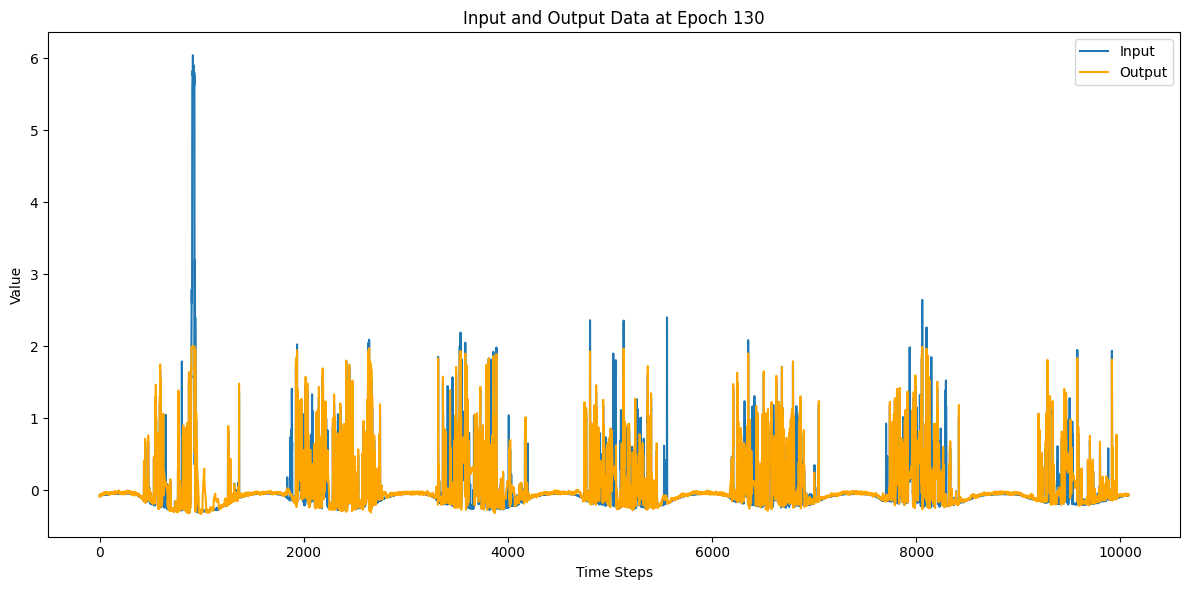

151/151 [==============================] - 6s 40ms/step - loss: 0.5437 - val_loss: 0.7168 - lr: 0.0010
Epoch 131/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5423 - val_loss: 0.7167 - lr: 0.0010
Epoch 132/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5423 - val_loss: 0.7171 - lr: 0.0010
Epoch 133/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5542 - val_loss: 0.7182 - lr: 0.0010
Epoch 134/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5429 - val_loss: 0.7193 - lr: 0.0010
Epoch 135/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5428 - val_loss: 0.7183 - lr: 0.0010
Epoch 136/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5425 - val_loss: 0.7173 - lr: 0.0010
Epoch 137/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5426 - val_loss: 0.7166 - lr: 0.0010
Epoch 138/10000
151/151 [==============================] - 5s 34

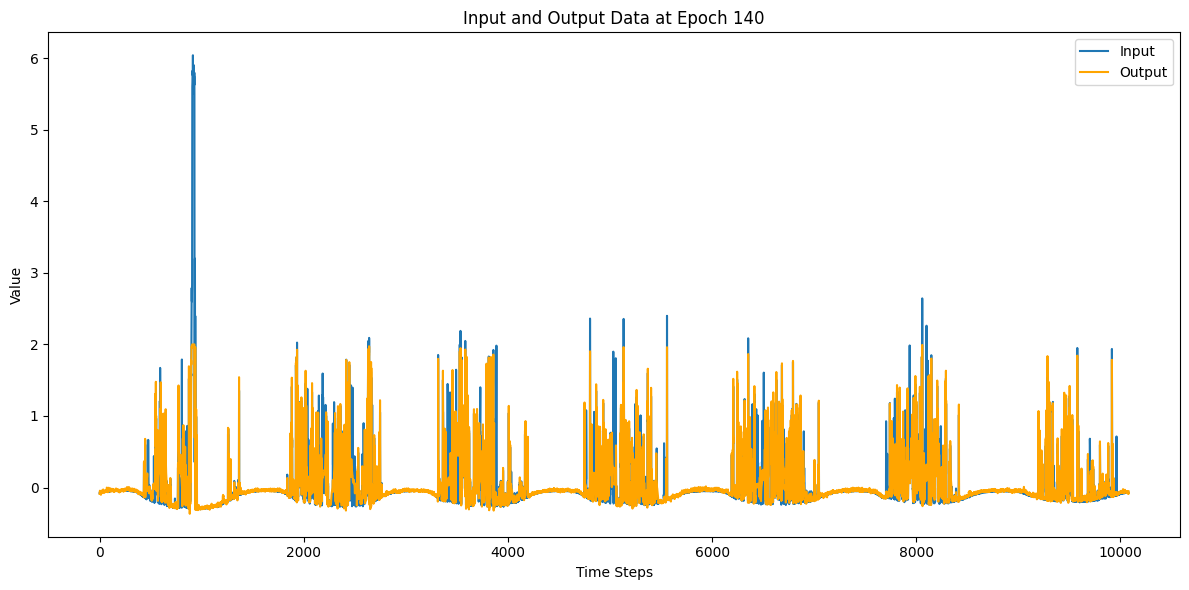

151/151 [==============================] - 6s 41ms/step - loss: 0.5438 - val_loss: 0.7169 - lr: 0.0010
Epoch 141/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5423 - val_loss: 0.7171 - lr: 0.0010
Epoch 142/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5422 - val_loss: 0.7172 - lr: 0.0010
Epoch 143/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5420 - val_loss: 0.7162 - lr: 0.0010
Epoch 144/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5471 - val_loss: 0.7185 - lr: 0.0010
Epoch 145/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5425 - val_loss: 0.7174 - lr: 0.0010
Epoch 146/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5420 - val_loss: 0.7171 - lr: 0.0010
Epoch 147/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5420 - val_loss: 0.7171 - lr: 0.0010
Epoch 148/10000
151/151 [==============================] - 5s 34

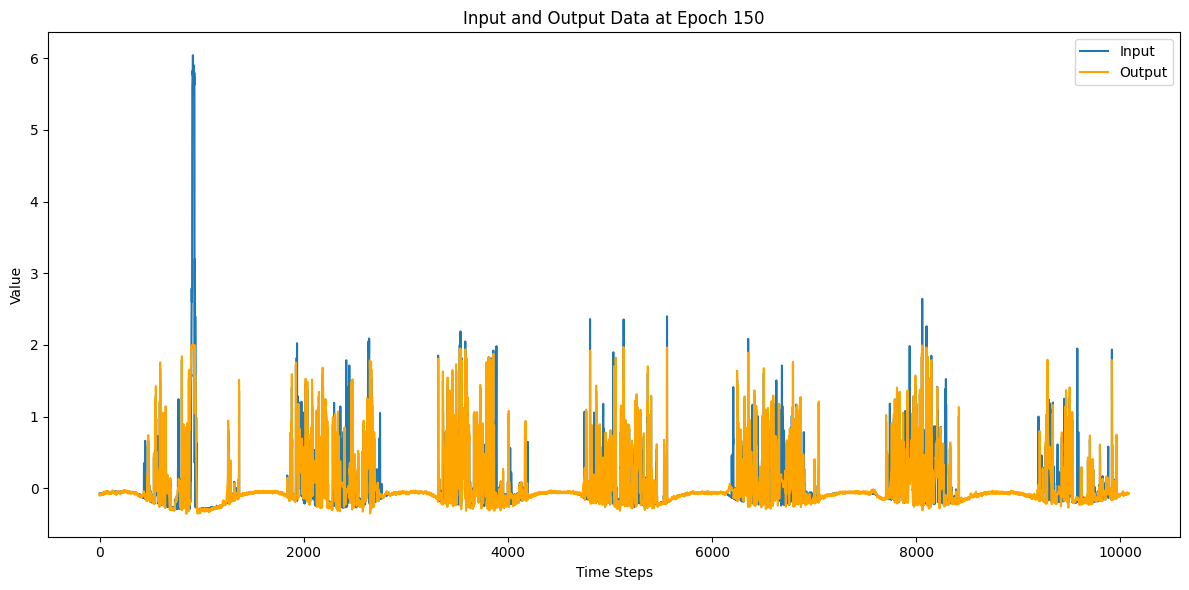

151/151 [==============================] - 6s 40ms/step - loss: 0.5423 - val_loss: 0.7166 - lr: 0.0010
Epoch 151/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5432 - val_loss: 0.7166 - lr: 0.0010
Epoch 152/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5415 - val_loss: 0.7163 - lr: 0.0010
Epoch 153/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5448 - val_loss: 0.7165 - lr: 0.0010
Epoch 154/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5478 - val_loss: 0.7185 - lr: 0.0010
Epoch 155/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5438 - val_loss: 0.7165 - lr: 0.0010
Epoch 156/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5434 - val_loss: 0.7187 - lr: 0.0010
Epoch 157/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5431 - val_loss: 0.7181 - lr: 0.0010
Epoch 158/10000
151/151 [==============================] - 5s 34

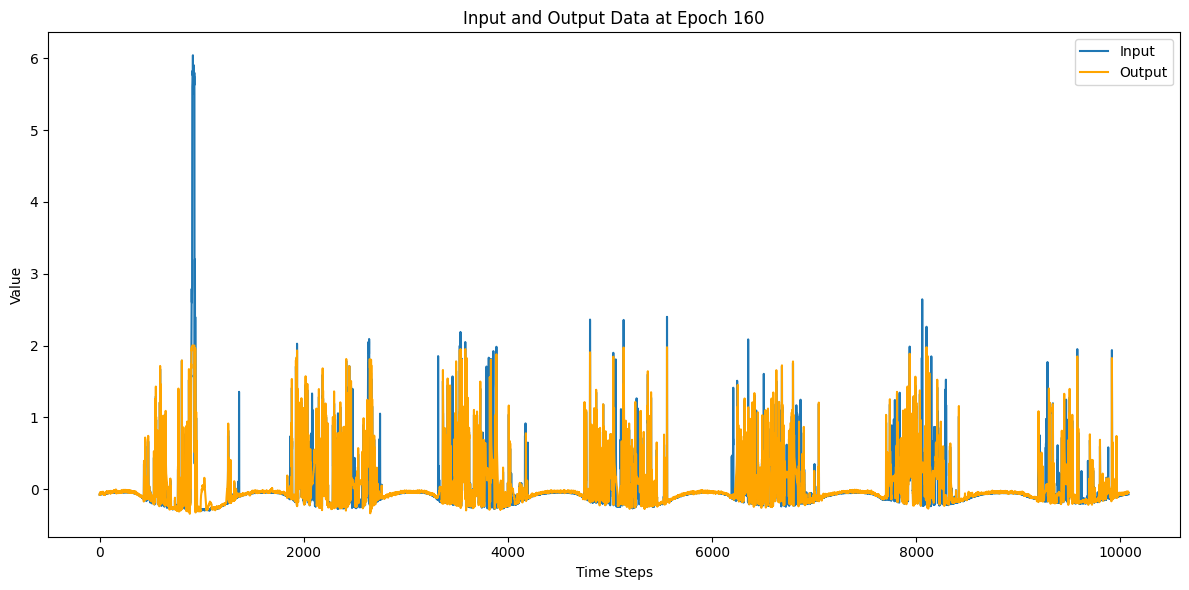

151/151 [==============================] - 6s 40ms/step - loss: 0.5416 - val_loss: 0.7164 - lr: 0.0010
Epoch 161/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5531 - val_loss: 0.7164 - lr: 0.0010
Epoch 162/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7167 - lr: 0.0010
Epoch 163/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5427 - val_loss: 0.7173 - lr: 0.0010
Epoch 164/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5423 - val_loss: 0.7167 - lr: 0.0010
Epoch 165/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5432 - val_loss: 0.7164 - lr: 0.0010
Epoch 166/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5437 - val_loss: 0.7186 - lr: 0.0010
Epoch 167/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5419 - val_loss: 0.7165 - lr: 0.0010
Epoch 168/10000
151/151 [==============================] - 5s 34

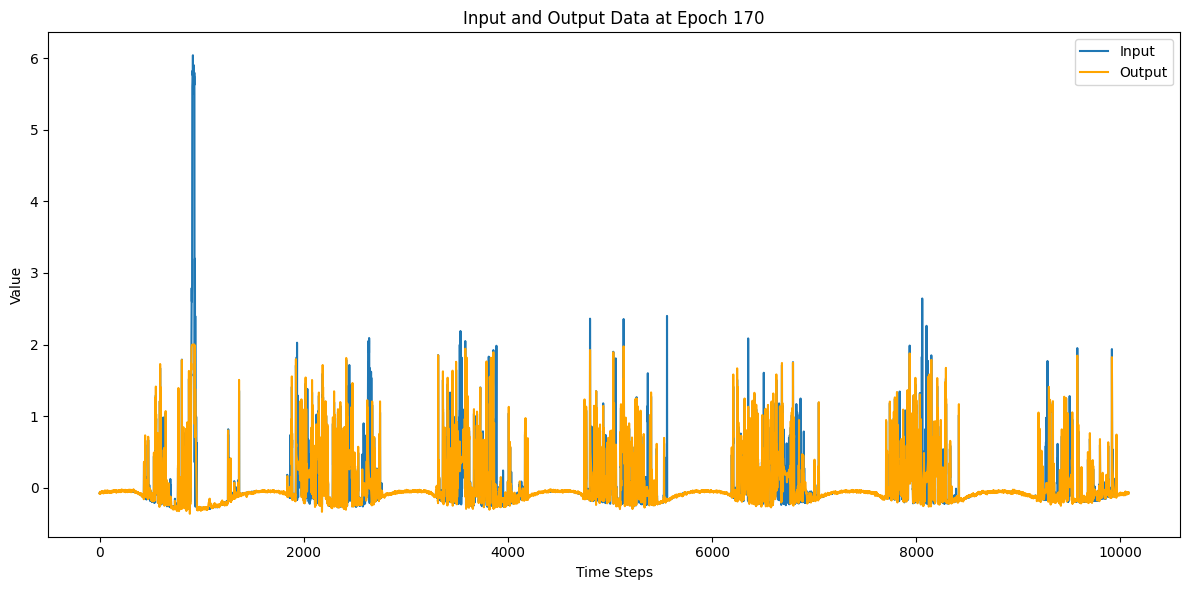

151/151 [==============================] - 6s 40ms/step - loss: 0.5418 - val_loss: 0.7167 - lr: 0.0010
Epoch 171/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5434 - val_loss: 0.7163 - lr: 0.0010
Epoch 172/10000
151/151 [==============================] - 6s 37ms/step - loss: 0.5424 - val_loss: 0.7163 - lr: 0.0010
Epoch 173/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5416 - val_loss: 0.7162 - lr: 0.0010
Epoch 174/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5421 - val_loss: 0.7167 - lr: 0.0010
Epoch 175/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7164 - lr: 0.0010
Epoch 176/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7163 - lr: 0.0010
Epoch 177/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5416 - val_loss: 0.7165 - lr: 0.0010
Epoch 178/10000
151/151 [==============================] - 5s 34

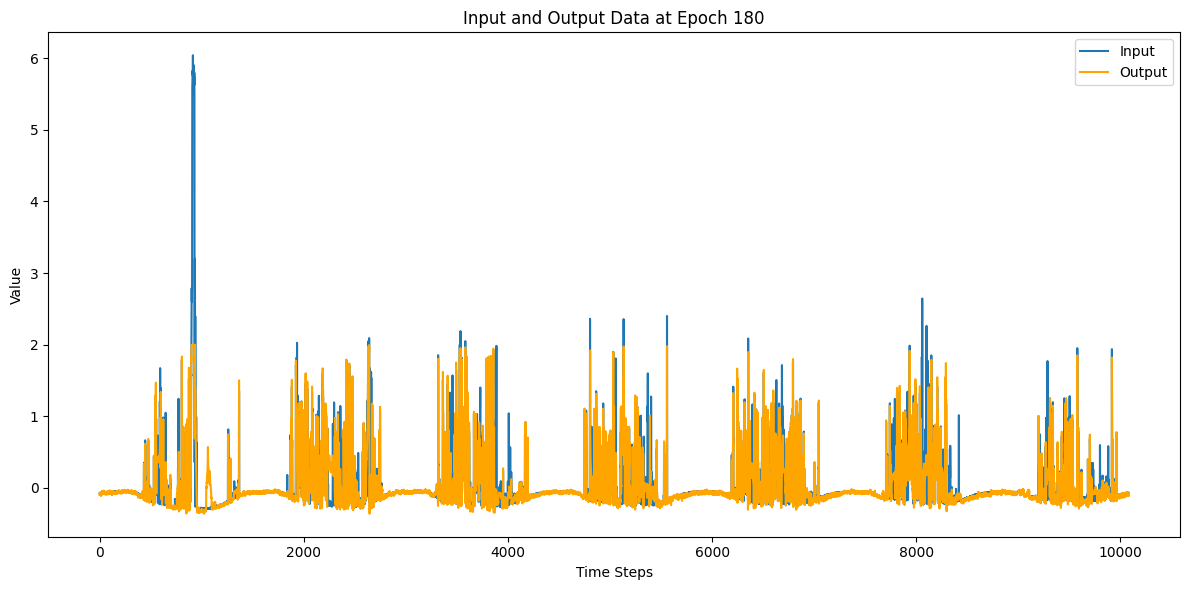

151/151 [==============================] - 6s 41ms/step - loss: 0.5431 - val_loss: 0.7192 - lr: 0.0010
Epoch 181/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5431 - val_loss: 0.7200 - lr: 0.0010
Epoch 182/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5457 - val_loss: 0.7173 - lr: 0.0010
Epoch 183/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5450 - val_loss: 0.7163 - lr: 0.0010
Epoch 184/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5423 - val_loss: 0.7170 - lr: 0.0010
Epoch 185/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5413 - val_loss: 0.7166 - lr: 0.0010
Epoch 186/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7160 - lr: 0.0010
Epoch 187/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5410 - val_loss: 0.7182 - lr: 0.0010
Epoch 188/10000
151/151 [==============================] - 5s 34

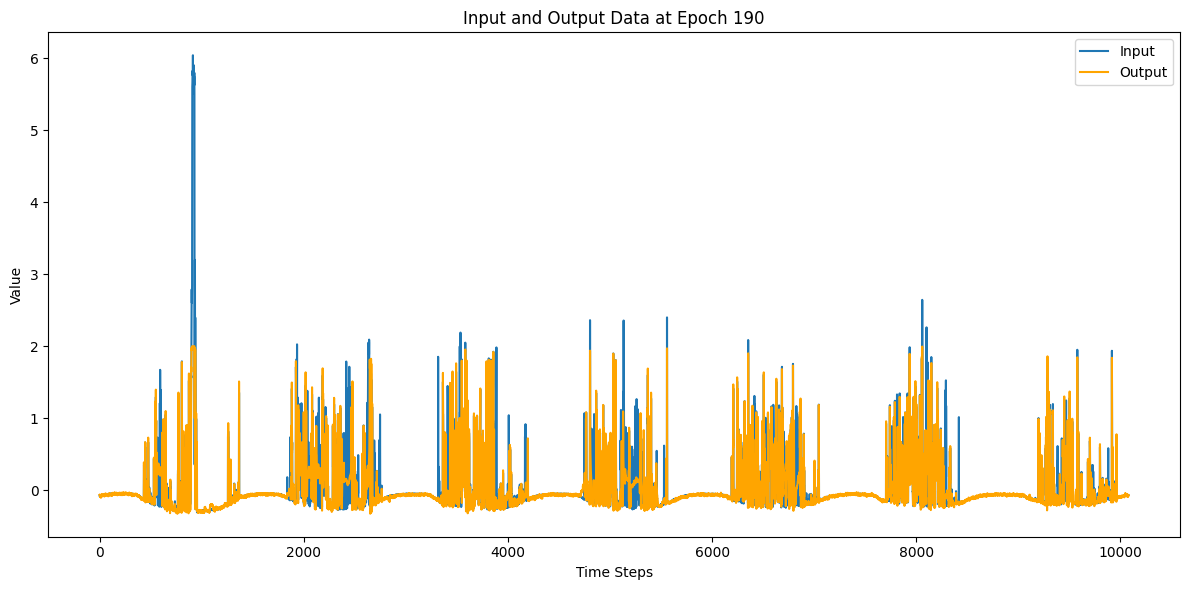

151/151 [==============================] - 6s 40ms/step - loss: 0.5423 - val_loss: 0.7169 - lr: 0.0010
Epoch 191/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5449 - val_loss: 0.7178 - lr: 0.0010
Epoch 192/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5413 - val_loss: 0.7160 - lr: 0.0010
Epoch 193/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5413 - val_loss: 0.7166 - lr: 0.0010
Epoch 194/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5417 - val_loss: 0.7173 - lr: 0.0010
Epoch 195/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5416 - val_loss: 0.7161 - lr: 0.0010
Epoch 196/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7162 - lr: 0.0010
Epoch 197/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5409 - val_loss: 0.7160 - lr: 0.0010
Epoch 198/10000
151/151 [==============================] - 5s 34

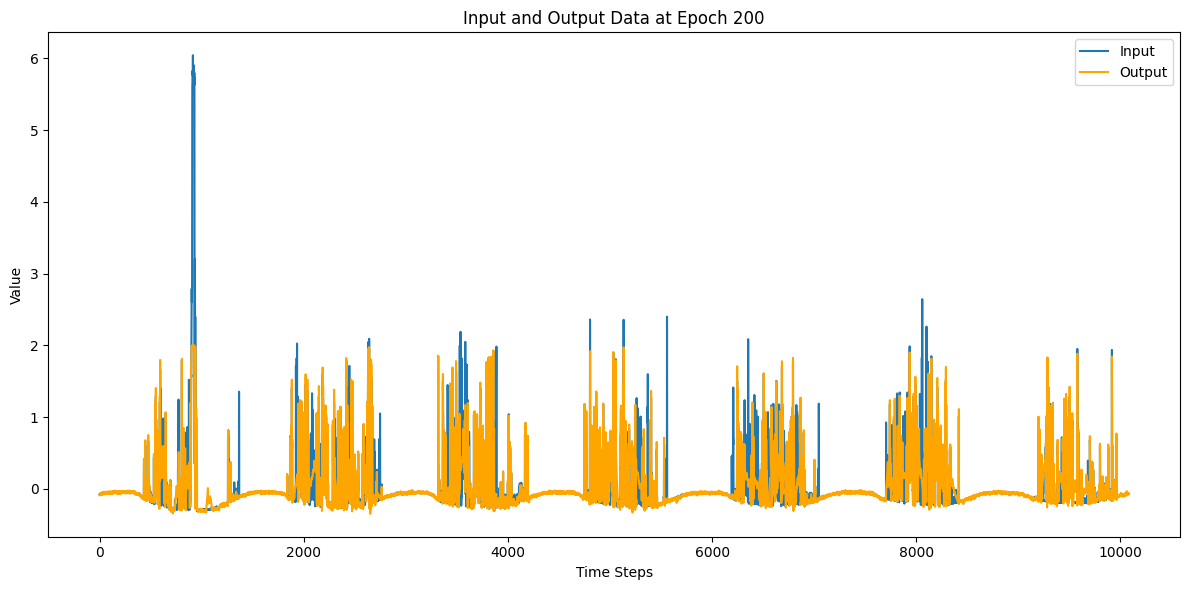

151/151 [==============================] - 6s 43ms/step - loss: 0.5426 - val_loss: 0.7163 - lr: 0.0010
Epoch 201/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5419 - val_loss: 0.7169 - lr: 0.0010
Epoch 202/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5427 - val_loss: 0.7214 - lr: 0.0010
Epoch 203/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5447 - val_loss: 0.7163 - lr: 0.0010
Epoch 204/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5417 - val_loss: 0.7168 - lr: 0.0010
Epoch 205/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7179 - lr: 0.0010
Epoch 206/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5443 - val_loss: 0.7176 - lr: 0.0010
Epoch 207/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5412 - val_loss: 0.7163 - lr: 0.0010
Epoch 208/10000
151/151 [==============================] - 5s 33

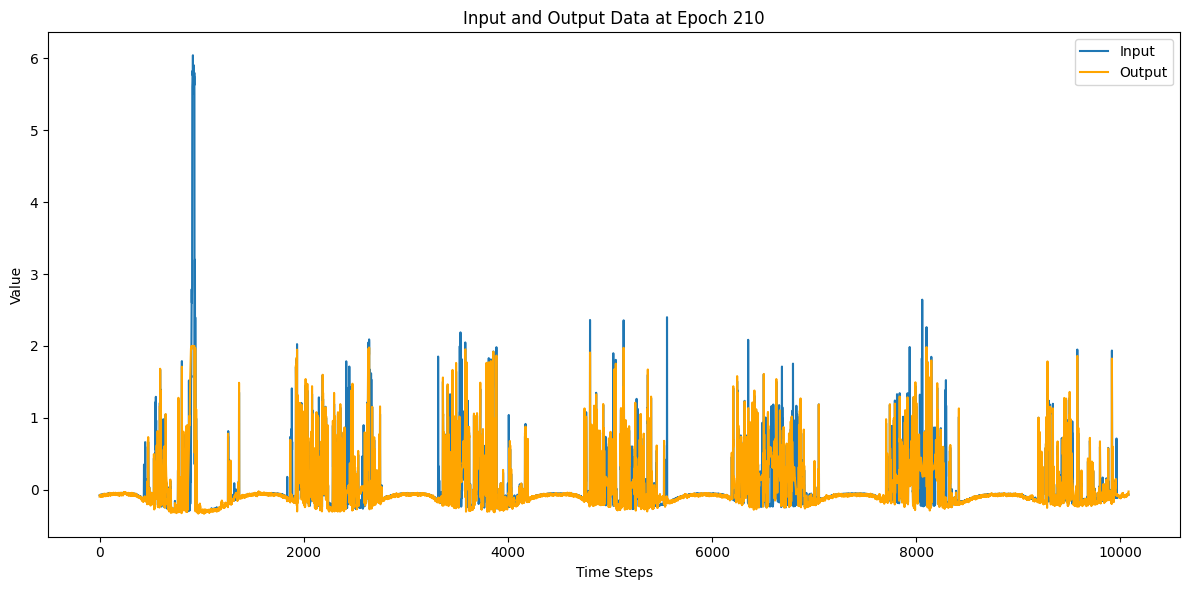

151/151 [==============================] - 6s 41ms/step - loss: 0.5410 - val_loss: 0.7159 - lr: 0.0010
Epoch 211/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7161 - lr: 0.0010
Epoch 212/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7159 - lr: 0.0010
Epoch 213/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5431 - val_loss: 0.7175 - lr: 0.0010
Epoch 214/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5419 - val_loss: 0.7164 - lr: 0.0010
Epoch 215/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5410 - val_loss: 0.7169 - lr: 0.0010
Epoch 216/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7164 - lr: 0.0010
Epoch 217/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5408 - val_loss: 0.7160 - lr: 0.0010
Epoch 218/10000
151/151 [==============================] - 5s 34

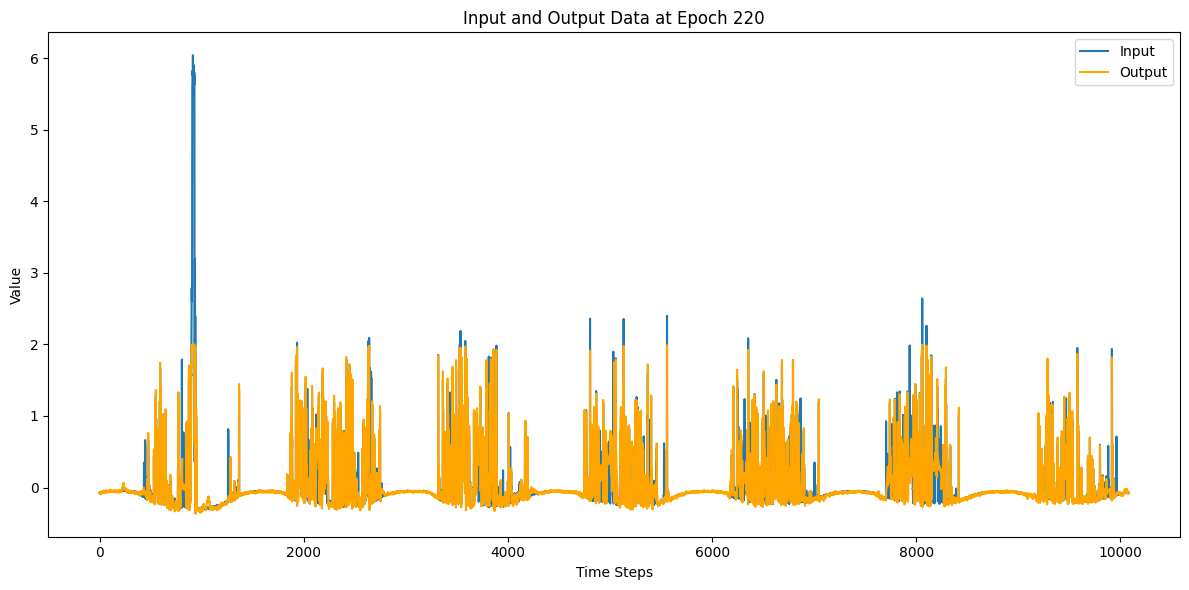

151/151 [==============================] - 6s 40ms/step - loss: 0.5463 - val_loss: 0.7162 - lr: 0.0010
Epoch 221/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7170 - lr: 0.0010
Epoch 222/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5415 - val_loss: 0.7165 - lr: 0.0010
Epoch 223/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7163 - lr: 0.0010
Epoch 224/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7160 - lr: 0.0010
Epoch 225/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5410 - val_loss: 0.7158 - lr: 0.0010
Epoch 226/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7165 - lr: 0.0010
Epoch 227/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7158 - lr: 0.0010
Epoch 228/10000
151/151 [==============================] - 5s 34

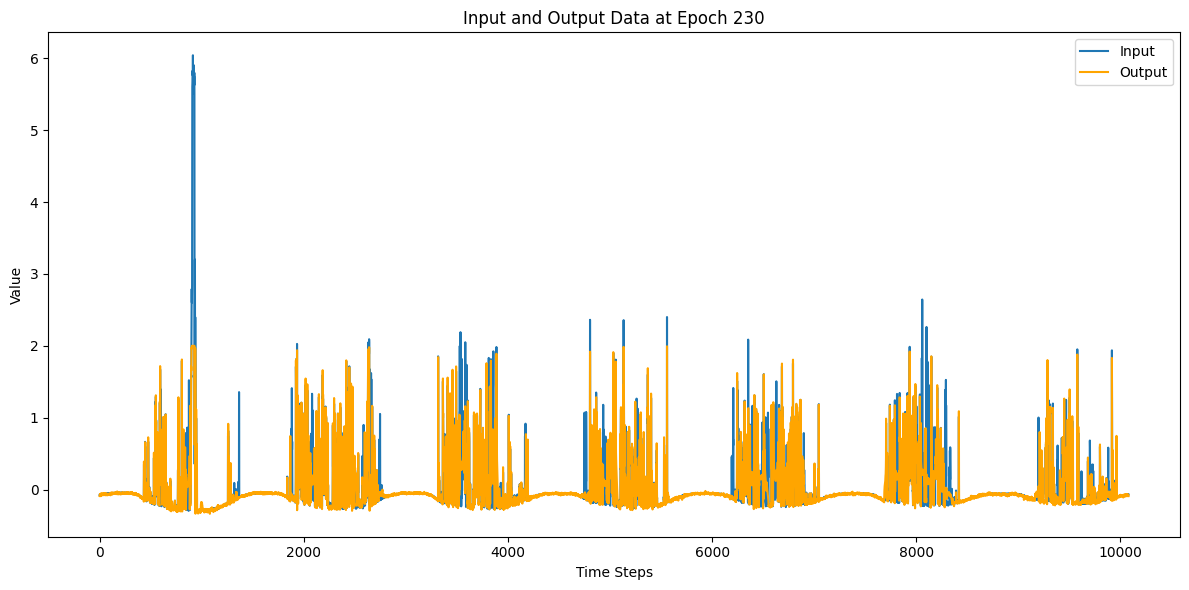

151/151 [==============================] - 7s 45ms/step - loss: 0.5410 - val_loss: 0.7157 - lr: 0.0010
Epoch 231/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5554 - val_loss: 0.7196 - lr: 0.0010
Epoch 232/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5456 - val_loss: 0.7177 - lr: 0.0010
Epoch 233/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5426 - val_loss: 0.7171 - lr: 0.0010
Epoch 234/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5418 - val_loss: 0.7169 - lr: 0.0010
Epoch 235/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5418 - val_loss: 0.7167 - lr: 0.0010
Epoch 236/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5435 - val_loss: 0.7296 - lr: 0.0010
Epoch 237/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5545 - val_loss: 0.7173 - lr: 0.0010
Epoch 238/10000
151/151 [==============================] - 5s 34

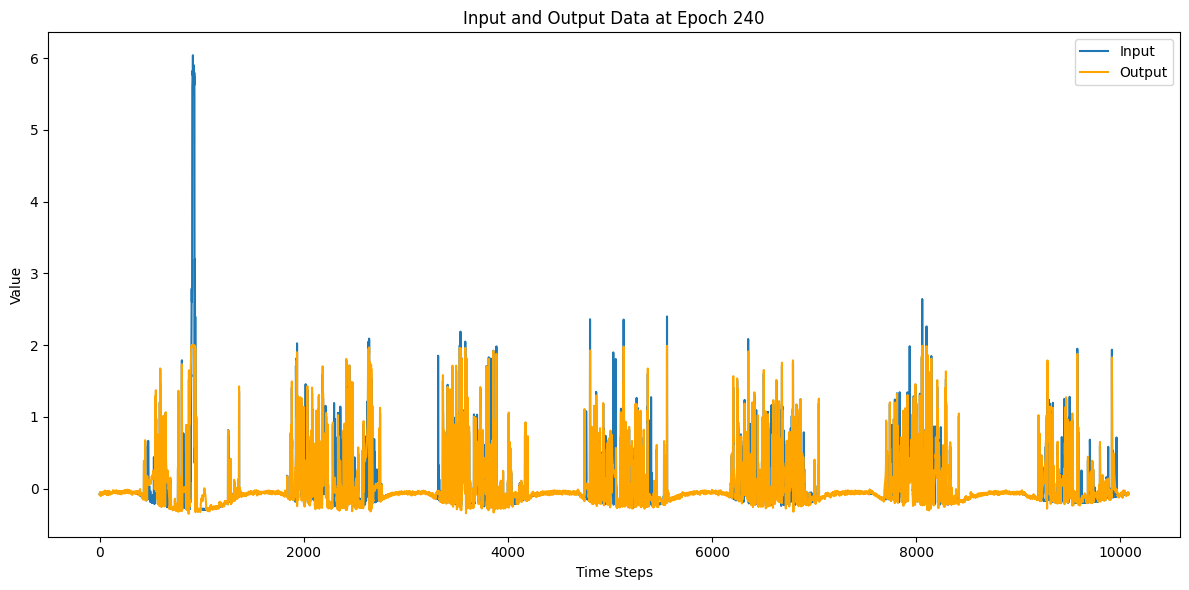

151/151 [==============================] - 6s 40ms/step - loss: 0.5413 - val_loss: 0.7166 - lr: 0.0010
Epoch 241/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5413 - val_loss: 0.7165 - lr: 0.0010
Epoch 242/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5409 - val_loss: 0.7161 - lr: 0.0010
Epoch 243/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7165 - lr: 0.0010
Epoch 244/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5410 - val_loss: 0.7157 - lr: 0.0010
Epoch 245/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7165 - lr: 0.0010
Epoch 246/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5424 - val_loss: 0.7188 - lr: 0.0010
Epoch 247/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5416 - val_loss: 0.7168 - lr: 0.0010
Epoch 248/10000
151/151 [==============================] - 5s 33

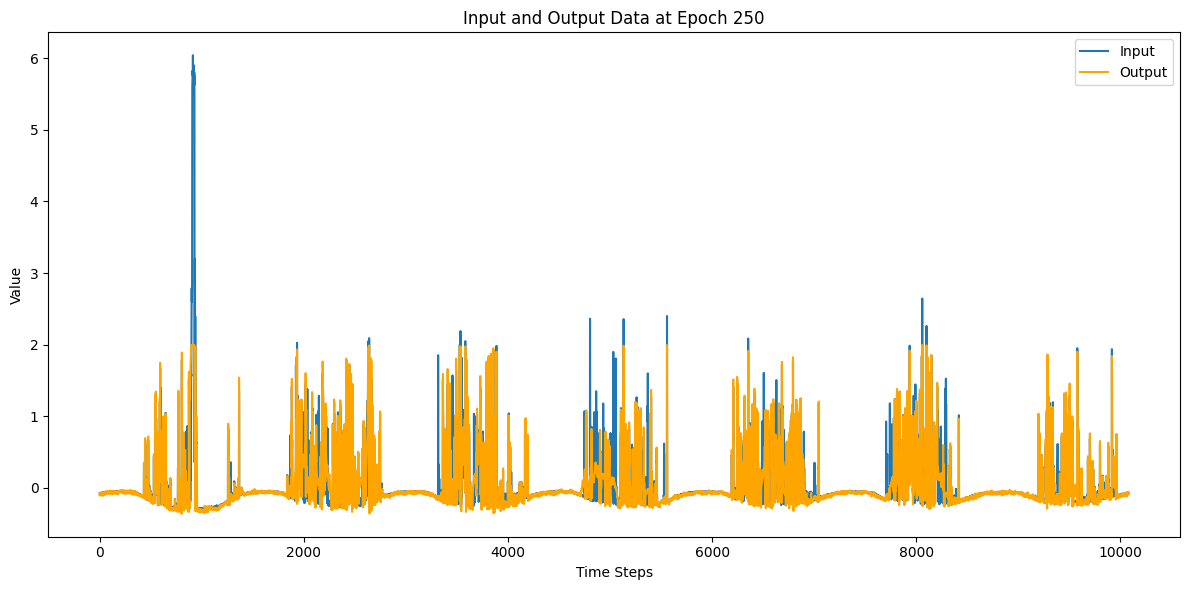

151/151 [==============================] - 6s 41ms/step - loss: 0.5418 - val_loss: 0.7178 - lr: 0.0010
Epoch 251/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5418 - val_loss: 0.7159 - lr: 0.0010
Epoch 252/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5448 - val_loss: 0.7163 - lr: 0.0010
Epoch 253/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7174 - lr: 0.0010
Epoch 254/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5410 - val_loss: 0.7157 - lr: 0.0010
Epoch 255/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5415 - val_loss: 0.7161 - lr: 0.0010
Epoch 256/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5407 - val_loss: 0.7157 - lr: 0.0010
Epoch 257/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7167 - lr: 0.0010
Epoch 258/10000
151/151 [==============================] - 5s 34

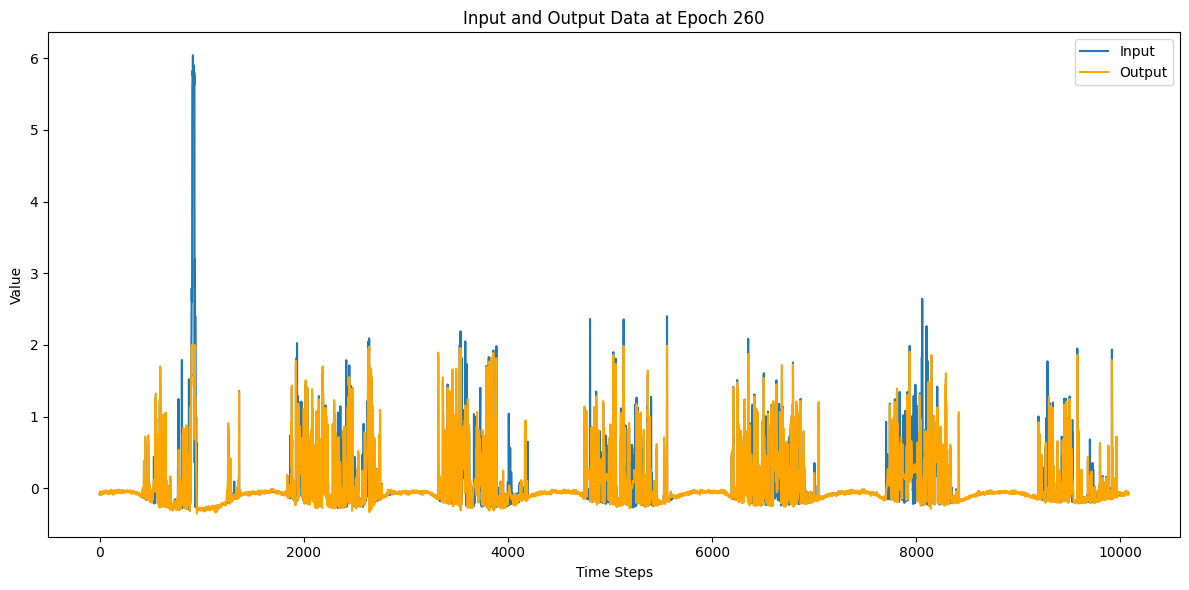

151/151 [==============================] - 6s 40ms/step - loss: 0.5417 - val_loss: 0.7163 - lr: 0.0010
Epoch 261/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5450 - val_loss: 0.7169 - lr: 0.0010
Epoch 262/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5550 - val_loss: 0.7179 - lr: 0.0010
Epoch 263/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5428 - val_loss: 0.7167 - lr: 0.0010
Epoch 264/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5410 - val_loss: 0.7158 - lr: 0.0010
Epoch 265/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5406 - val_loss: 0.7159 - lr: 0.0010
Epoch 266/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5473 - val_loss: 0.7159 - lr: 0.0010
Epoch 267/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5405 - val_loss: 0.7163 - lr: 0.0010
Epoch 268/10000
151/151 [==============================] - 5s 34

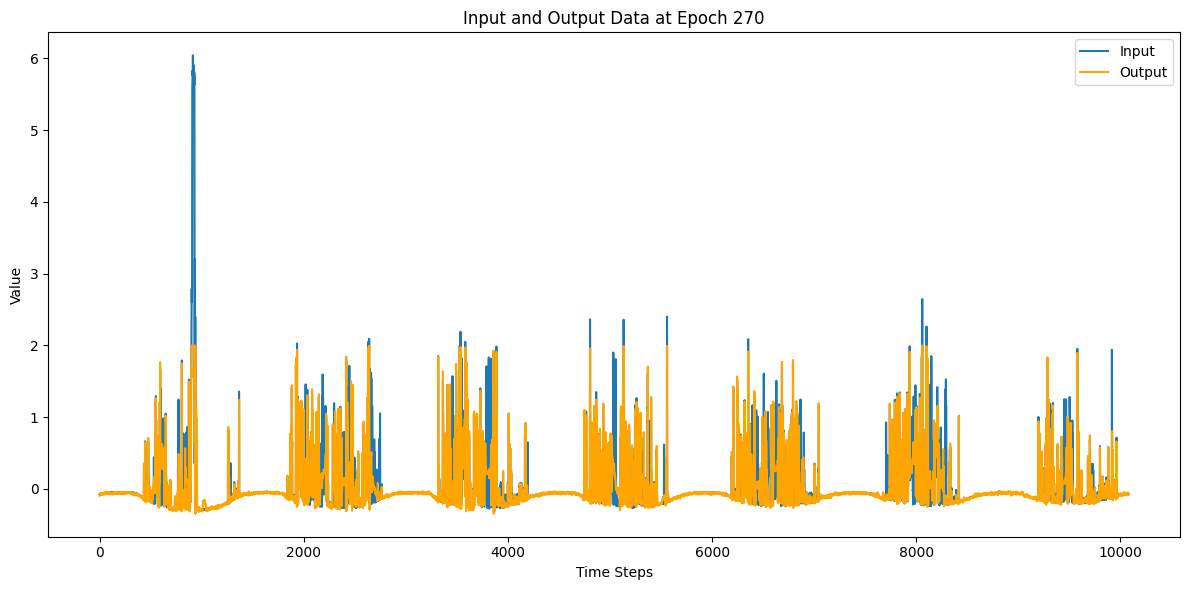

151/151 [==============================] - 6s 41ms/step - loss: 0.5417 - val_loss: 0.7164 - lr: 0.0010
Epoch 271/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7170 - lr: 0.0010
Epoch 272/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5424 - val_loss: 0.7161 - lr: 0.0010
Epoch 273/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5440 - val_loss: 0.7156 - lr: 0.0010
Epoch 274/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5405 - val_loss: 0.7151 - lr: 0.0010
Epoch 275/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5407 - val_loss: 0.7157 - lr: 0.0010
Epoch 276/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5419 - val_loss: 0.7166 - lr: 0.0010
Epoch 277/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7189 - lr: 0.0010
Epoch 278/10000
151/151 [==============================] - 5s 34

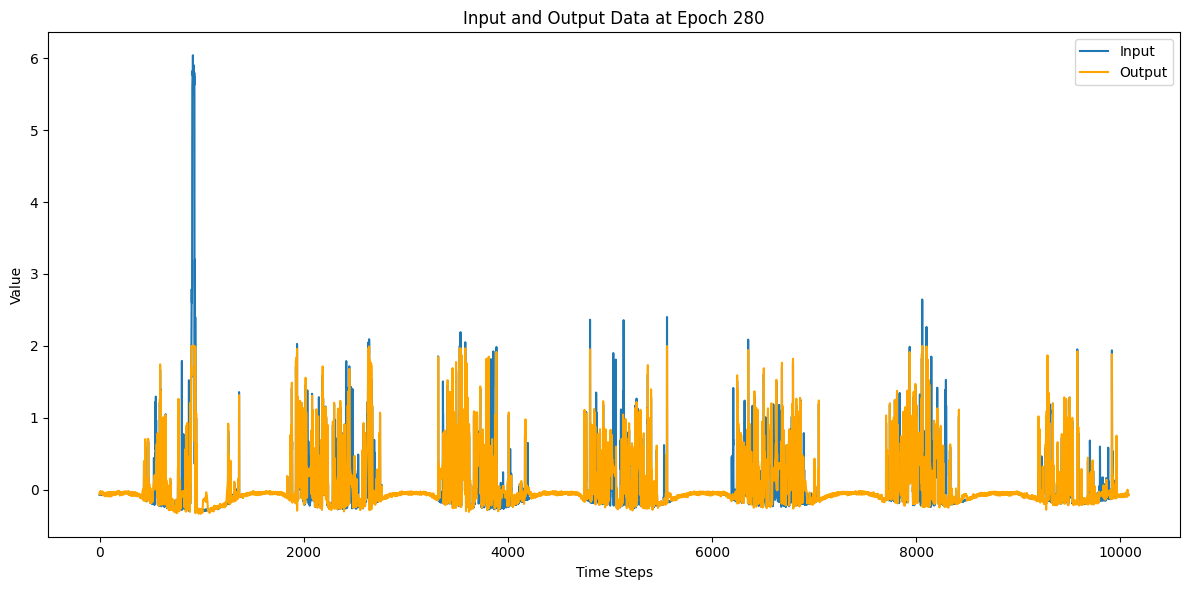

151/151 [==============================] - 6s 41ms/step - loss: 0.5404 - val_loss: 0.7160 - lr: 0.0010
Epoch 281/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5487 - val_loss: 0.7160 - lr: 0.0010
Epoch 282/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5424 - val_loss: 0.7163 - lr: 0.0010
Epoch 283/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7182 - lr: 0.0010
Epoch 284/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5424 - val_loss: 0.7158 - lr: 0.0010
Epoch 285/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7157 - lr: 0.0010
Epoch 286/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7161 - lr: 0.0010
Epoch 287/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5405 - val_loss: 0.7180 - lr: 0.0010
Epoch 288/10000
151/151 [==============================] - 5s 34

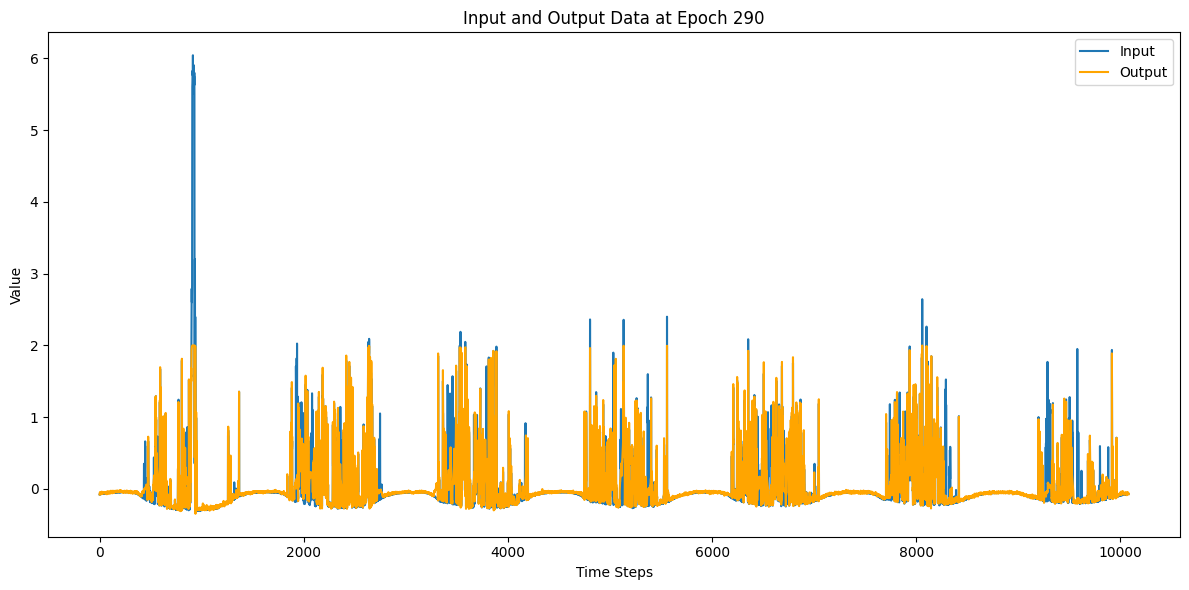

151/151 [==============================] - 6s 40ms/step - loss: 0.5408 - val_loss: 0.7159 - lr: 0.0010
Epoch 291/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7161 - lr: 0.0010
Epoch 292/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5405 - val_loss: 0.7157 - lr: 0.0010
Epoch 293/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5406 - val_loss: 0.7155 - lr: 0.0010
Epoch 294/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5409 - val_loss: 0.7160 - lr: 0.0010
Epoch 295/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5421 - val_loss: 0.7187 - lr: 0.0010
Epoch 296/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5445 - val_loss: 0.7159 - lr: 0.0010
Epoch 297/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5415 - val_loss: 0.7162 - lr: 0.0010
Epoch 298/10000
151/151 [==============================] - 5s 34

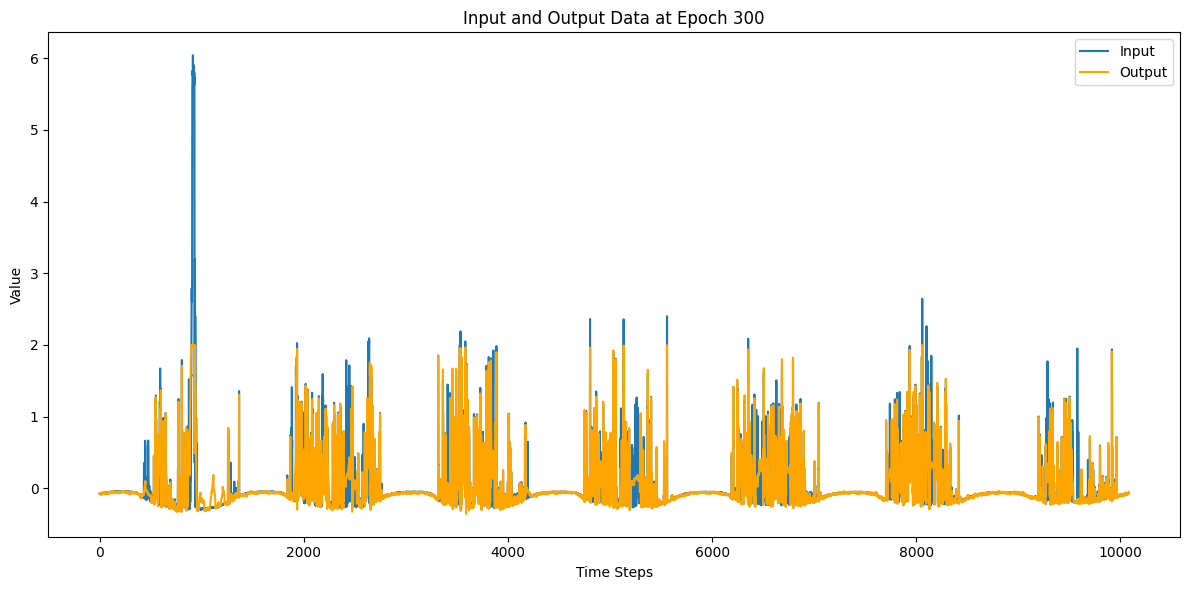

151/151 [==============================] - 6s 40ms/step - loss: 0.5434 - val_loss: 0.7164 - lr: 0.0010
Epoch 301/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5422 - val_loss: 0.7162 - lr: 0.0010
Epoch 302/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7154 - lr: 0.0010
Epoch 303/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5403 - val_loss: 0.7155 - lr: 0.0010
Epoch 304/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5403 - val_loss: 0.7151 - lr: 0.0010
Epoch 305/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7155 - lr: 0.0010
Epoch 306/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7160 - lr: 0.0010
Epoch 307/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7152 - lr: 0.0010
Epoch 308/10000
151/151 [==============================] - 5s 34

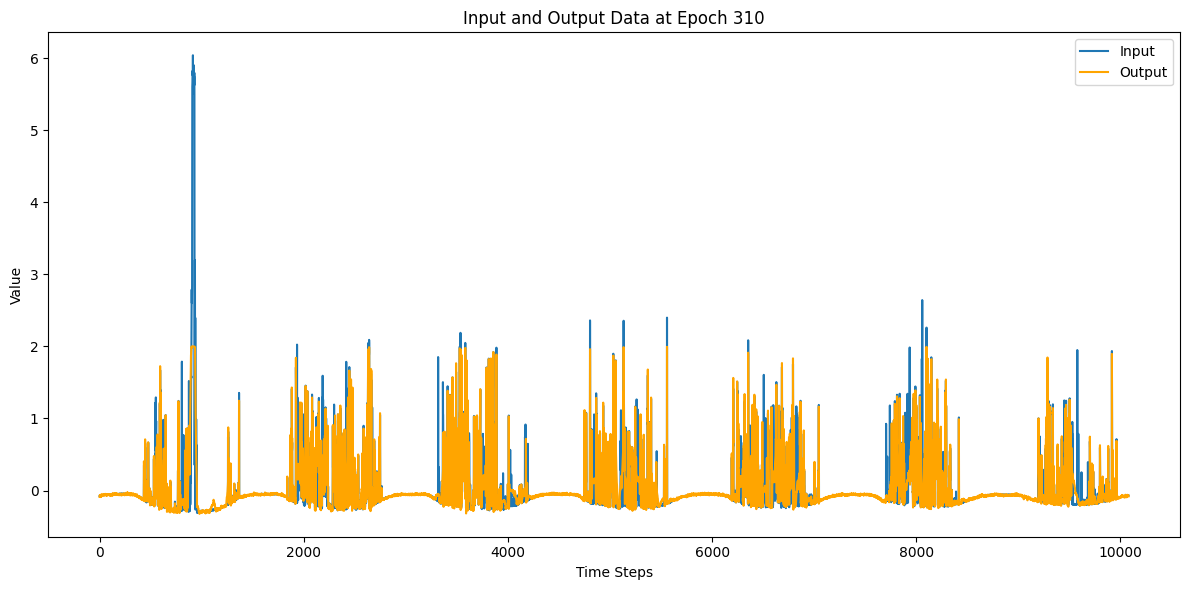

151/151 [==============================] - 7s 45ms/step - loss: 0.5404 - val_loss: 0.7158 - lr: 0.0010
Epoch 311/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5403 - val_loss: 0.7154 - lr: 0.0010
Epoch 312/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7161 - lr: 0.0010
Epoch 313/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5436 - val_loss: 0.7157 - lr: 0.0010
Epoch 314/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5406 - val_loss: 0.7158 - lr: 0.0010
Epoch 315/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5402 - val_loss: 0.7154 - lr: 0.0010
Epoch 316/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5401 - val_loss: 0.7157 - lr: 0.0010
Epoch 317/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5401 - val_loss: 0.7151 - lr: 0.0010
Epoch 318/10000
151/151 [==============================] - 5s 34

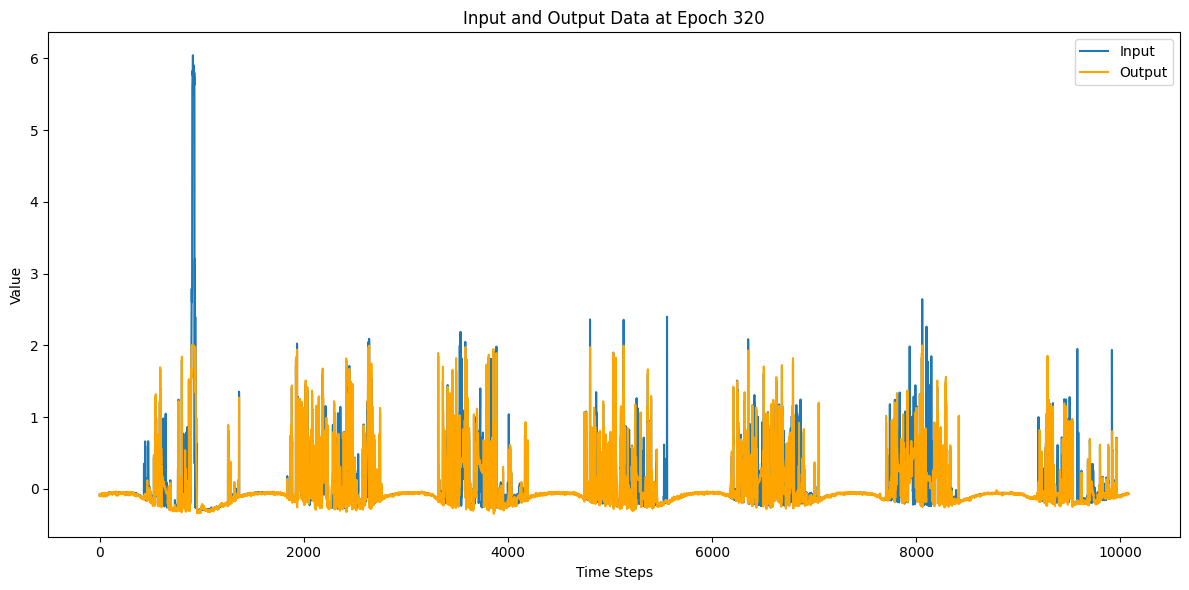

151/151 [==============================] - 6s 40ms/step - loss: 0.5413 - val_loss: 0.7163 - lr: 0.0010
Epoch 321/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7156 - lr: 0.0010
Epoch 322/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5419 - val_loss: 0.7177 - lr: 0.0010
Epoch 323/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7153 - lr: 0.0010
Epoch 324/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5430 - val_loss: 0.7179 - lr: 0.0010
Epoch 325/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5405 - val_loss: 0.7158 - lr: 0.0010
Epoch 326/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5407 - val_loss: 0.7151 - lr: 0.0010
Epoch 327/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7155 - lr: 0.0010
Epoch 328/10000
151/151 [==============================] - 5s 34

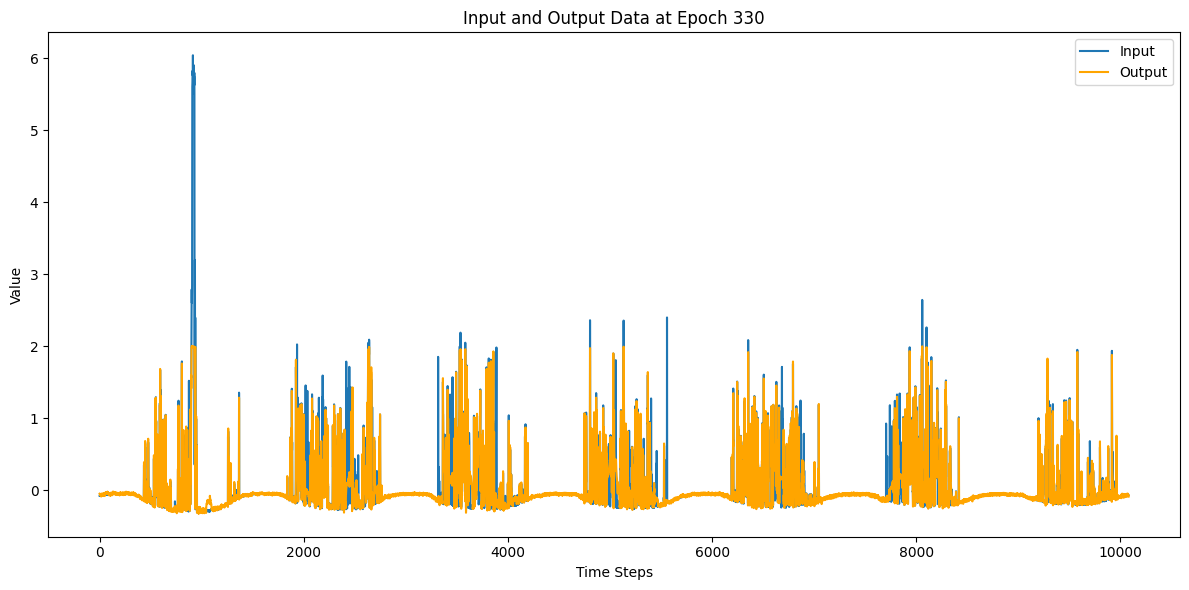

151/151 [==============================] - 6s 41ms/step - loss: 0.5400 - val_loss: 0.7158 - lr: 0.0010
Epoch 331/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5398 - val_loss: 0.7155 - lr: 0.0010
Epoch 332/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5432 - val_loss: 0.7168 - lr: 0.0010
Epoch 333/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5413 - val_loss: 0.7162 - lr: 0.0010
Epoch 334/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7160 - lr: 0.0010
Epoch 335/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5403 - val_loss: 0.7152 - lr: 0.0010
Epoch 336/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5410 - val_loss: 0.7163 - lr: 0.0010
Epoch 337/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7172 - lr: 0.0010
Epoch 338/10000
151/151 [==============================] - 5s 34

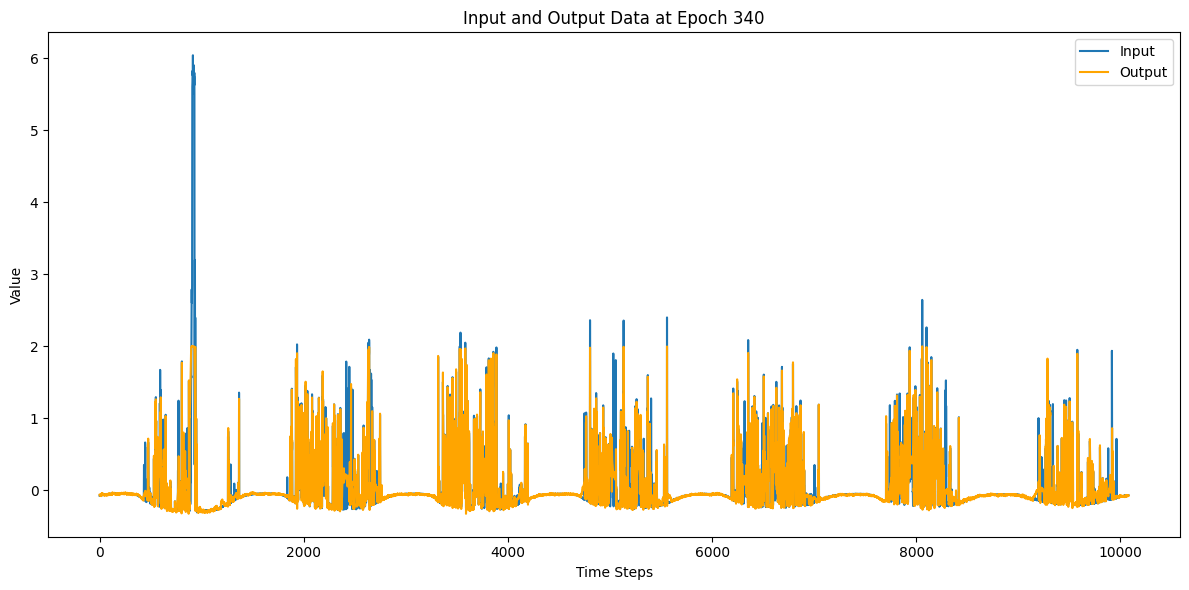

151/151 [==============================] - 6s 41ms/step - loss: 0.5400 - val_loss: 0.7150 - lr: 0.0010
Epoch 341/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7161 - lr: 0.0010
Epoch 342/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7157 - lr: 0.0010
Epoch 343/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5416 - val_loss: 0.7157 - lr: 0.0010
Epoch 344/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5436 - val_loss: 0.7164 - lr: 0.0010
Epoch 345/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5411 - val_loss: 0.7158 - lr: 0.0010
Epoch 346/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5401 - val_loss: 0.7159 - lr: 0.0010
Epoch 347/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5400 - val_loss: 0.7154 - lr: 0.0010
Epoch 348/10000
151/151 [==============================] - 5s 34

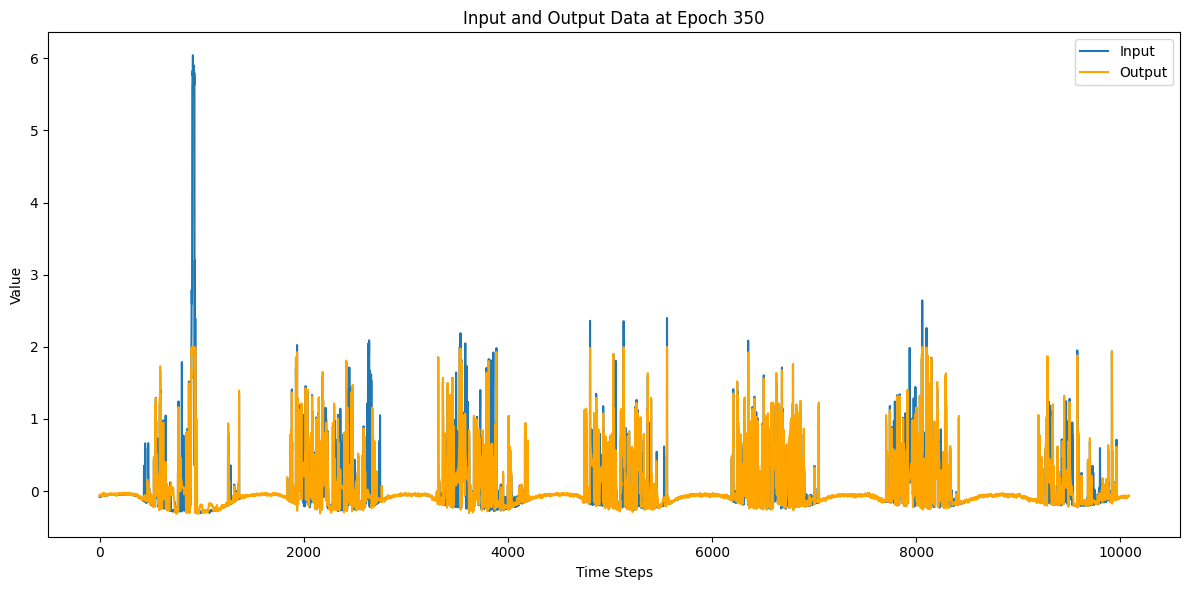

151/151 [==============================] - 6s 41ms/step - loss: 0.5403 - val_loss: 0.7176 - lr: 0.0010
Epoch 351/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5407 - val_loss: 0.7158 - lr: 0.0010
Epoch 352/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5415 - val_loss: 0.7153 - lr: 0.0010
Epoch 353/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5505 - val_loss: 0.7152 - lr: 0.0010
Epoch 354/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7156 - lr: 0.0010
Epoch 355/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7158 - lr: 0.0010
Epoch 356/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7158 - lr: 0.0010
Epoch 357/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5438 - val_loss: 0.7190 - lr: 0.0010
Epoch 358/10000
151/151 [==============================] - 5s 34

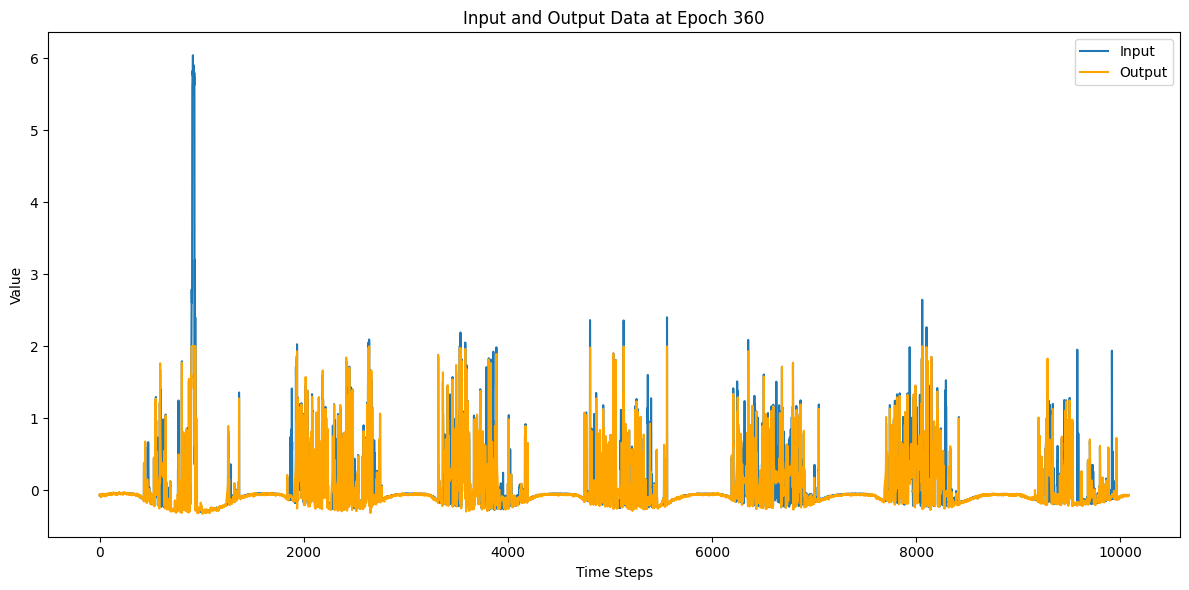

151/151 [==============================] - 6s 41ms/step - loss: 0.5399 - val_loss: 0.7154 - lr: 0.0010
Epoch 361/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7160 - lr: 0.0010
Epoch 362/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5419 - val_loss: 0.7156 - lr: 0.0010
Epoch 363/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5400 - val_loss: 0.7165 - lr: 0.0010
Epoch 364/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5442 - val_loss: 0.7152 - lr: 0.0010
Epoch 365/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7154 - lr: 0.0010
Epoch 366/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7162 - lr: 0.0010
Epoch 367/10000
151/151 [==============================] - 6s 37ms/step - loss: 0.5409 - val_loss: 0.7180 - lr: 0.0010
Epoch 368/10000
151/151 [==============================] - 5s 34

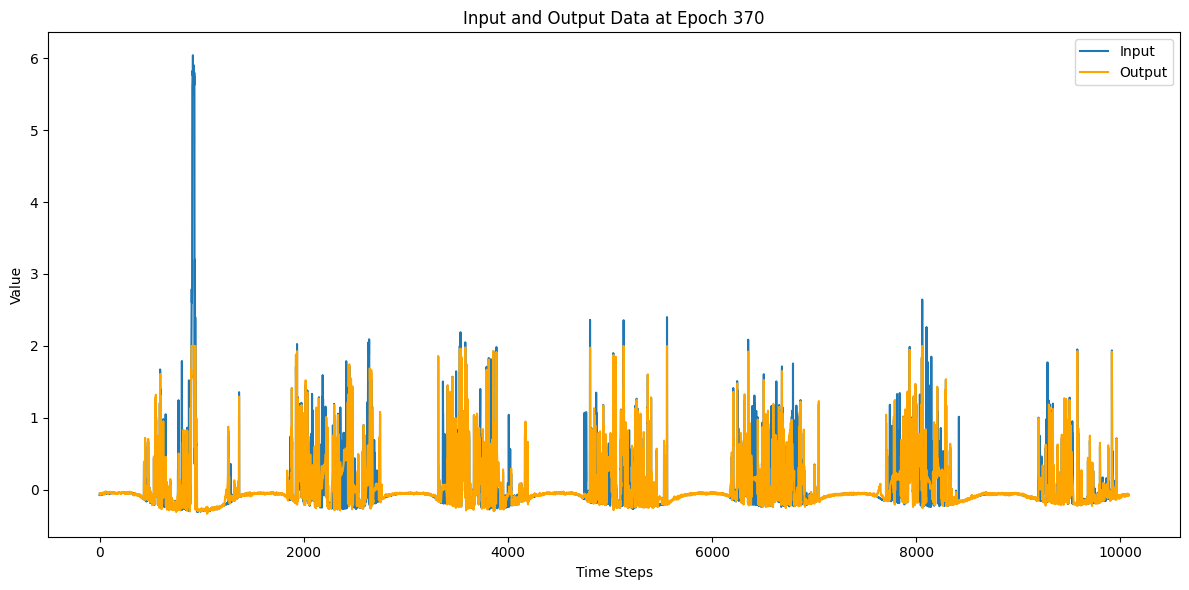

151/151 [==============================] - 6s 40ms/step - loss: 0.5409 - val_loss: 0.7155 - lr: 0.0010
Epoch 371/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5405 - val_loss: 0.7158 - lr: 0.0010
Epoch 372/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5400 - val_loss: 0.7155 - lr: 0.0010
Epoch 373/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5398 - val_loss: 0.7154 - lr: 0.0010
Epoch 374/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7155 - lr: 0.0010
Epoch 375/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5398 - val_loss: 0.7152 - lr: 0.0010
Epoch 376/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7157 - lr: 0.0010
Epoch 377/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7151 - lr: 0.0010
Epoch 378/10000
151/151 [==============================] - 5s 34

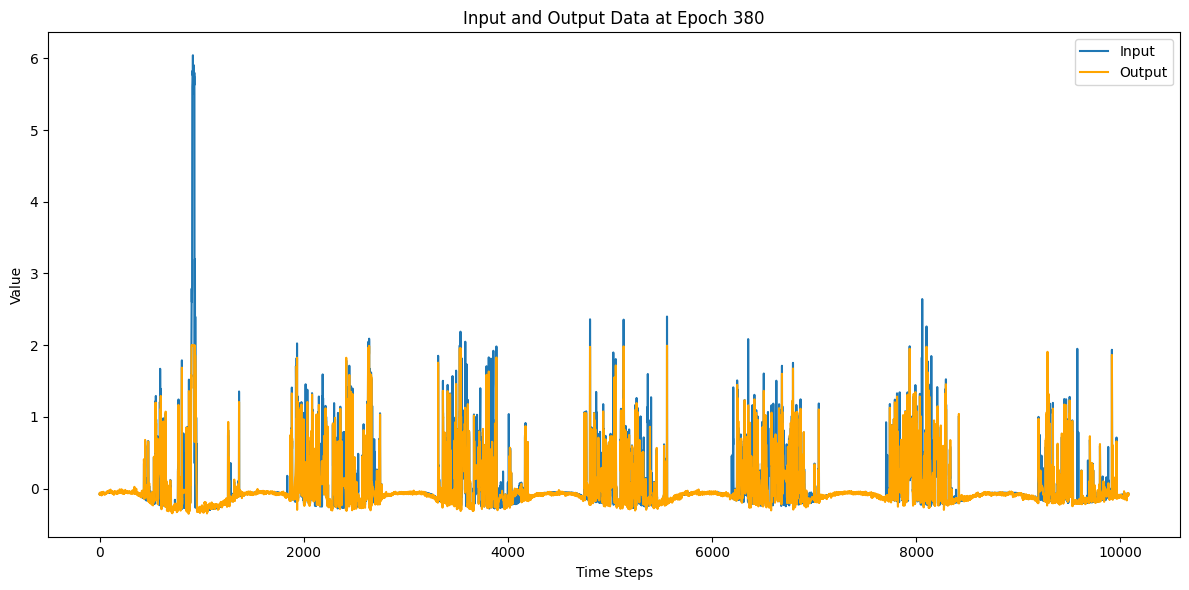

151/151 [==============================] - 6s 40ms/step - loss: 0.5445 - val_loss: 0.7179 - lr: 0.0010
Epoch 381/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7158 - lr: 0.0010
Epoch 382/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5400 - val_loss: 0.7168 - lr: 0.0010
Epoch 383/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5457 - val_loss: 0.7157 - lr: 0.0010
Epoch 384/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7154 - lr: 0.0010
Epoch 385/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5400 - val_loss: 0.7172 - lr: 0.0010
Epoch 386/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5403 - val_loss: 0.7156 - lr: 0.0010
Epoch 387/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5518 - val_loss: 0.7154 - lr: 0.0010
Epoch 388/10000
151/151 [==============================] - 5s 34

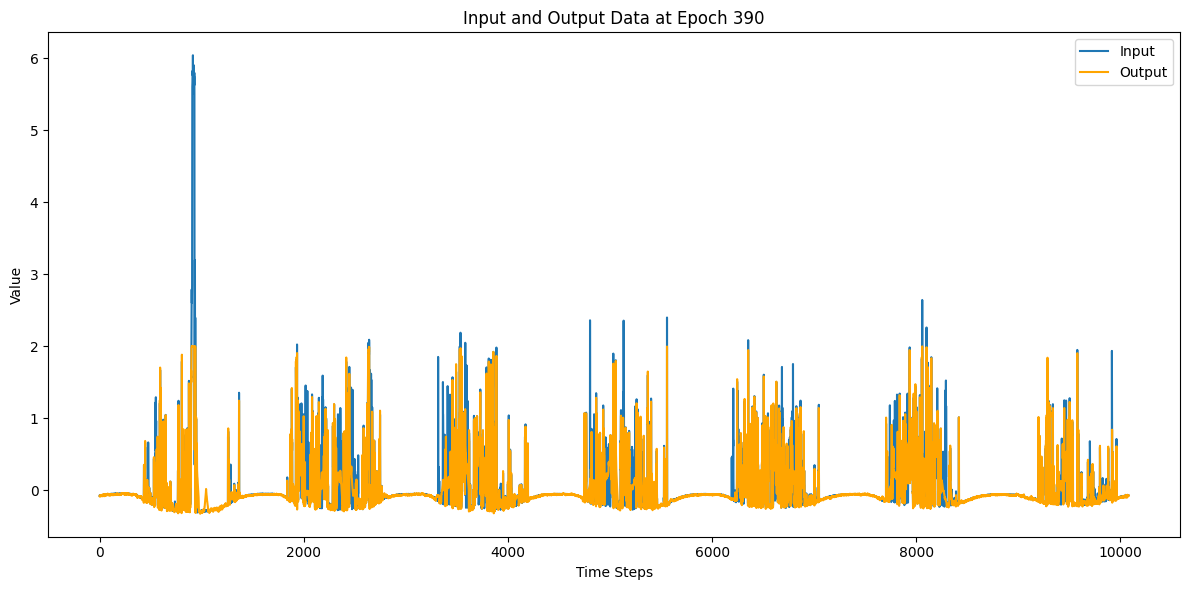

151/151 [==============================] - 6s 41ms/step - loss: 0.5403 - val_loss: 0.7160 - lr: 0.0010
Epoch 391/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5400 - val_loss: 0.7167 - lr: 0.0010
Epoch 392/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5401 - val_loss: 0.7152 - lr: 0.0010
Epoch 393/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5444 - val_loss: 0.7155 - lr: 0.0010
Epoch 394/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5469 - val_loss: 0.7178 - lr: 0.0010
Epoch 395/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5422 - val_loss: 0.7155 - lr: 0.0010
Epoch 396/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5434 - val_loss: 0.7155 - lr: 0.0010
Epoch 397/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7157 - lr: 0.0010
Epoch 398/10000
151/151 [==============================] - 5s 34

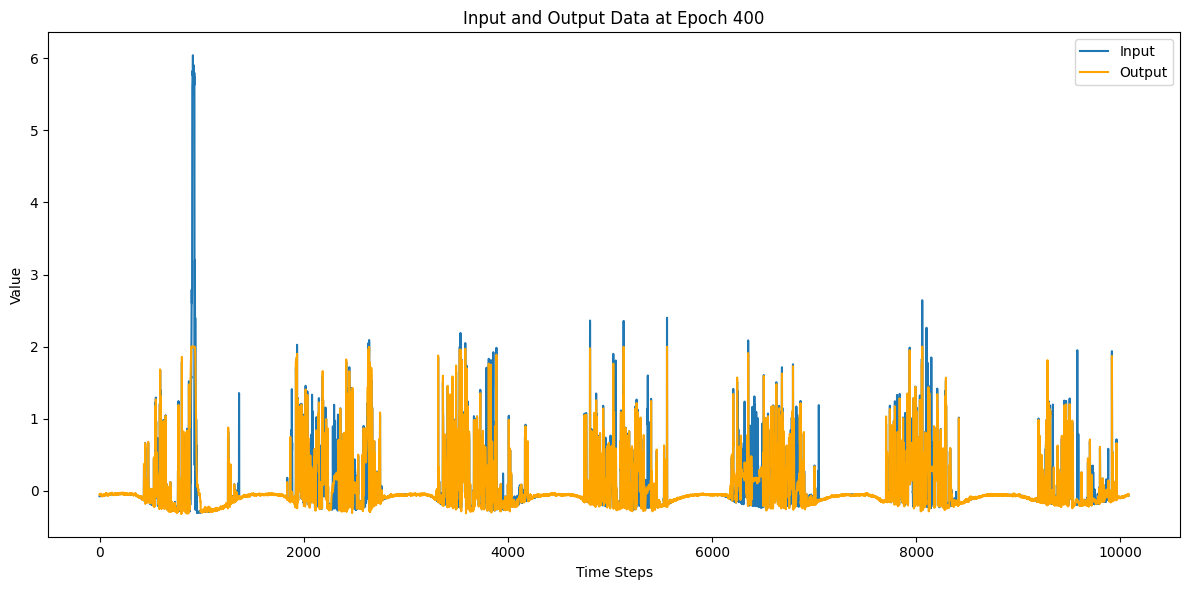

151/151 [==============================] - 6s 41ms/step - loss: 0.5397 - val_loss: 0.7149 - lr: 0.0010
Epoch 401/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7154 - lr: 0.0010
Epoch 402/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5407 - val_loss: 0.7157 - lr: 0.0010
Epoch 403/10000
151/151 [==============================] - ETA: 0s - loss: 0.5398
Epoch 403: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
151/151 [==============================] - 5s 34ms/step - loss: 0.5398 - val_loss: 0.7156 - lr: 0.0010
Epoch 404/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5395 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 405/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 406/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 407/10000
151/151 [==

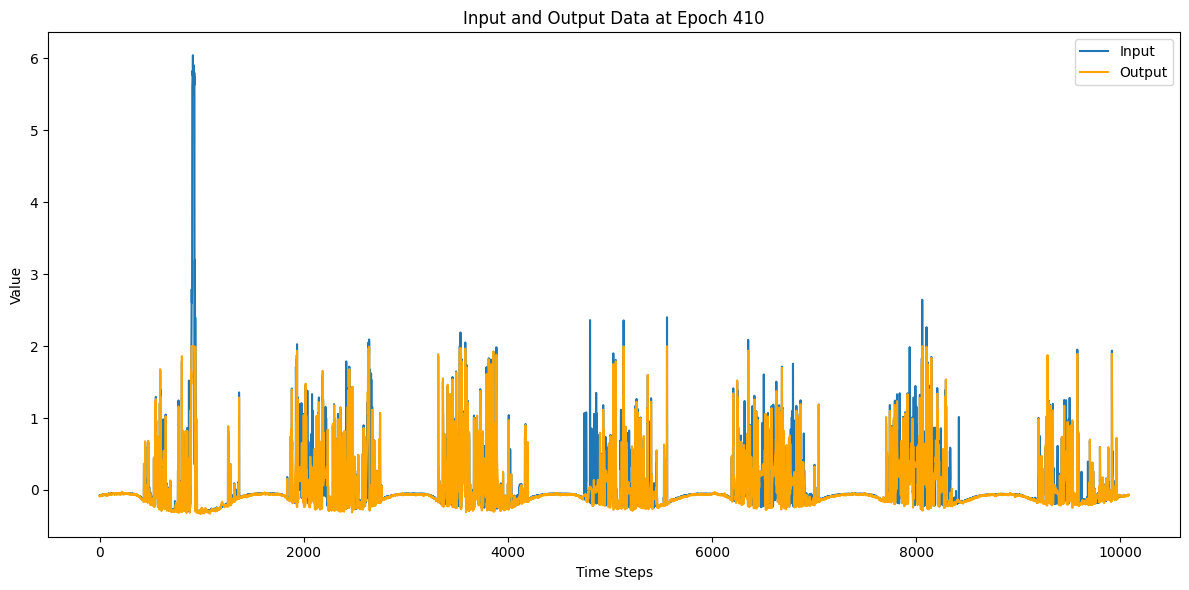

151/151 [==============================] - 6s 40ms/step - loss: 0.5395 - val_loss: 0.7157 - lr: 5.0000e-04
Epoch 411/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5477 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 412/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 413/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 414/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 415/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 416/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 417/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 418/10000
151/151 [=======

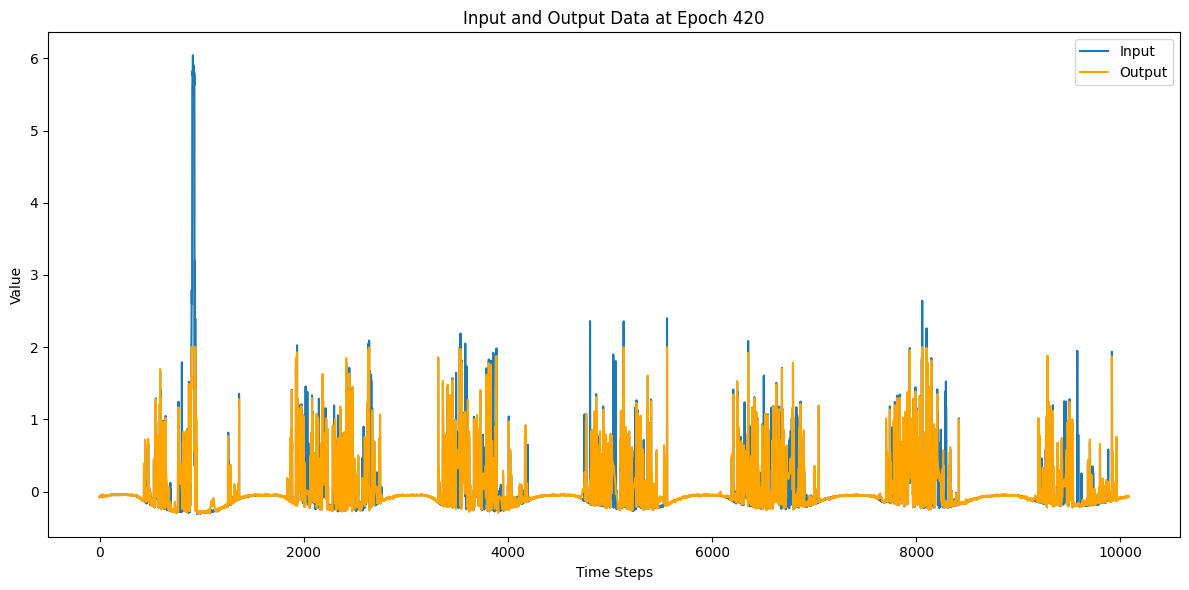

151/151 [==============================] - 6s 41ms/step - loss: 0.5392 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 421/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 422/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5393 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 423/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5426 - val_loss: 0.7155 - lr: 5.0000e-04
Epoch 424/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5463 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 425/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5395 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 426/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7164 - lr: 5.0000e-04
Epoch 427/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7157 - lr: 5.0000e-04
Epoch 428/10000
151/151 [=======

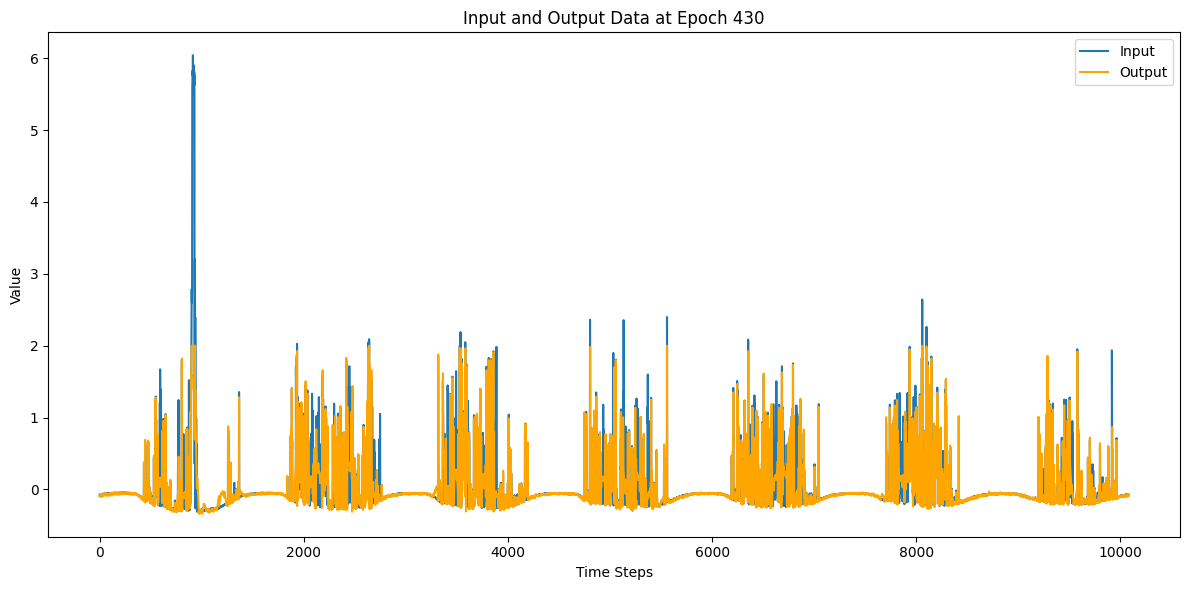

151/151 [==============================] - 6s 40ms/step - loss: 0.5392 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 431/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7158 - lr: 5.0000e-04
Epoch 432/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 433/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5582 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 434/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 435/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7147 - lr: 5.0000e-04
Epoch 436/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5465 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 437/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 438/10000
151/151 [=======

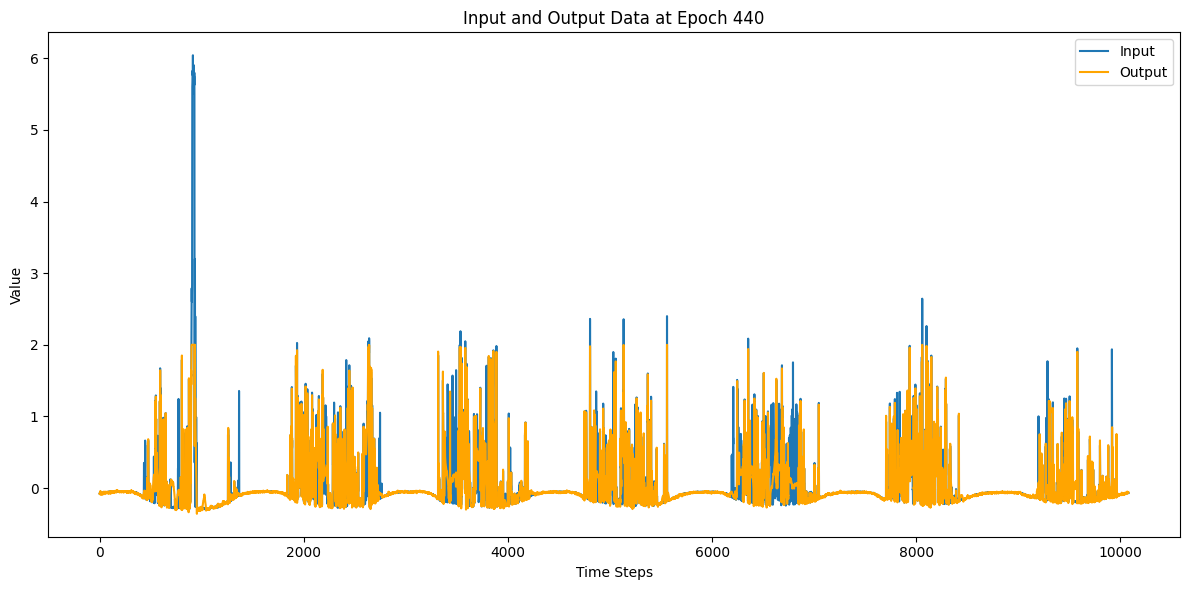

151/151 [==============================] - 6s 41ms/step - loss: 0.5392 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 441/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5429 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 442/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5396 - val_loss: 0.7155 - lr: 5.0000e-04
Epoch 443/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5428 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 444/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5428 - val_loss: 0.7157 - lr: 5.0000e-04
Epoch 445/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5401 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 446/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 447/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 448/10000
151/151 [=======

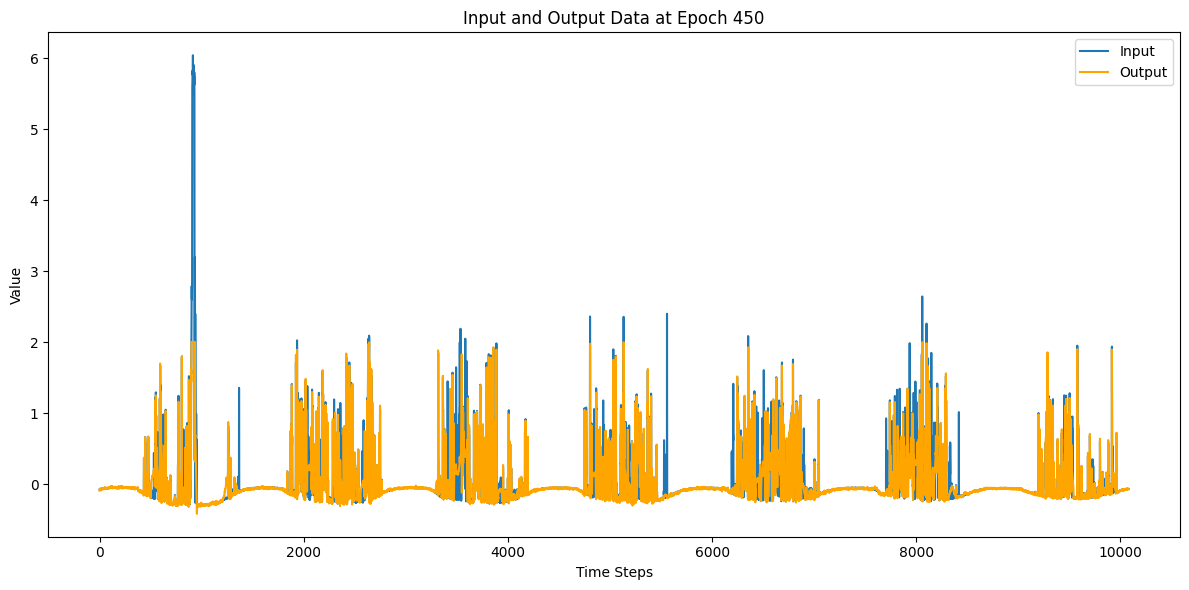

151/151 [==============================] - 7s 44ms/step - loss: 0.5428 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 451/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7145 - lr: 5.0000e-04
Epoch 452/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5395 - val_loss: 0.7154 - lr: 5.0000e-04
Epoch 453/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5434 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 454/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5395 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 455/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 456/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5400 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 457/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 458/10000
151/151 [=======

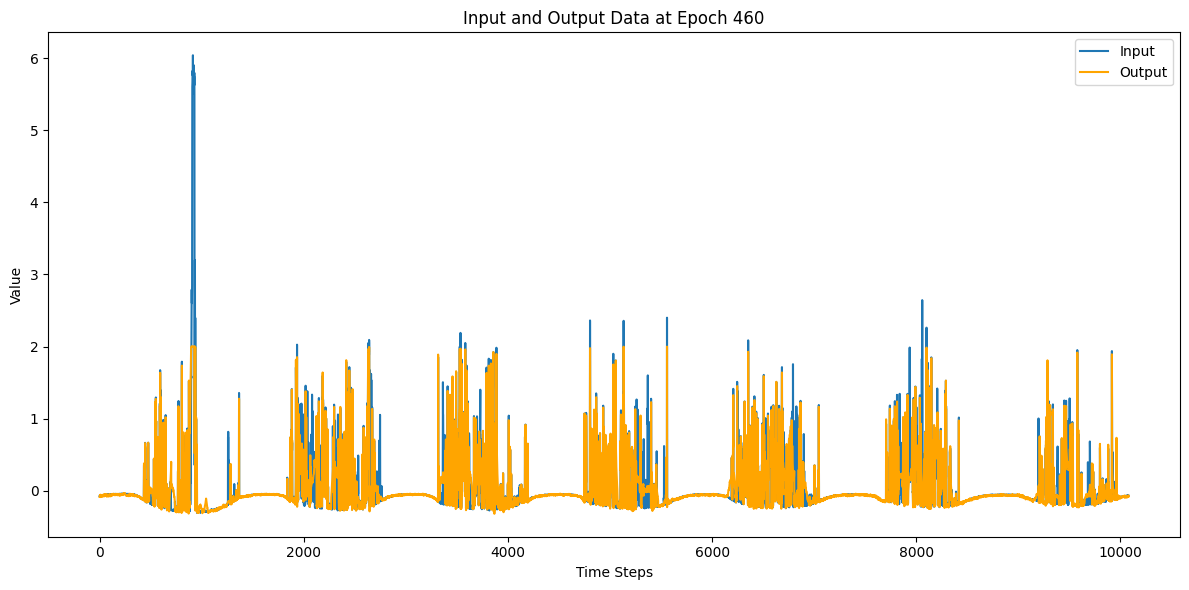

151/151 [==============================] - 6s 41ms/step - loss: 0.5395 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 461/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 462/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 463/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 464/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 465/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5406 - val_loss: 0.7147 - lr: 5.0000e-04
Epoch 466/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 467/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 468/10000
151/151 [=======

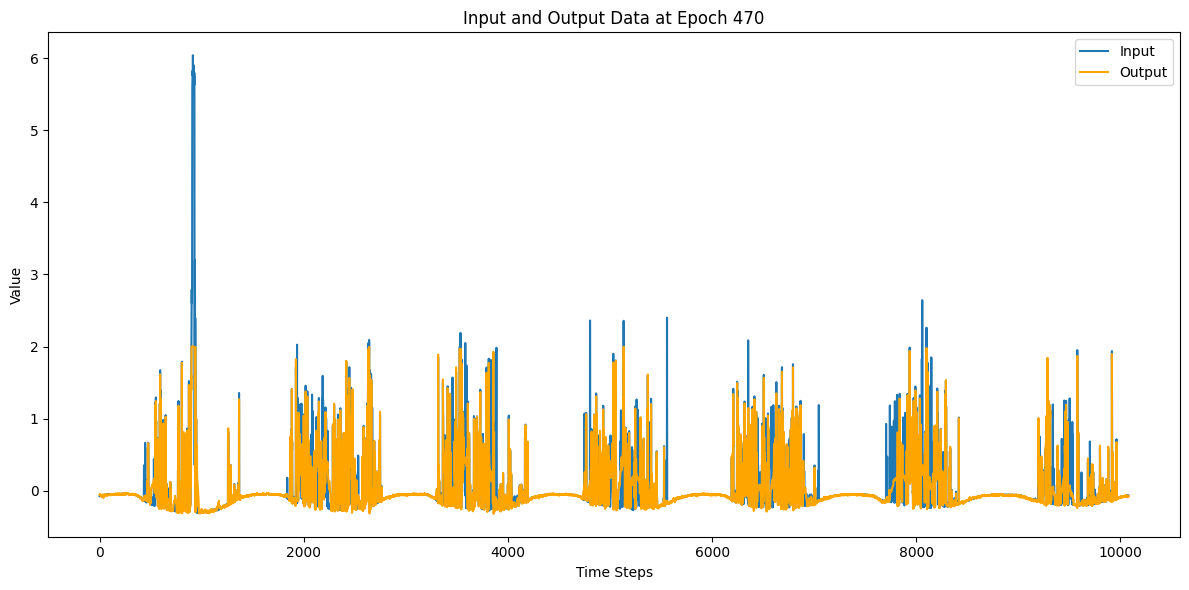

151/151 [==============================] - 6s 40ms/step - loss: 0.5399 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 471/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 472/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7147 - lr: 5.0000e-04
Epoch 473/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 474/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5391 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 475/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 476/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5403 - val_loss: 0.7157 - lr: 5.0000e-04
Epoch 477/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5396 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 478/10000
151/151 [=======

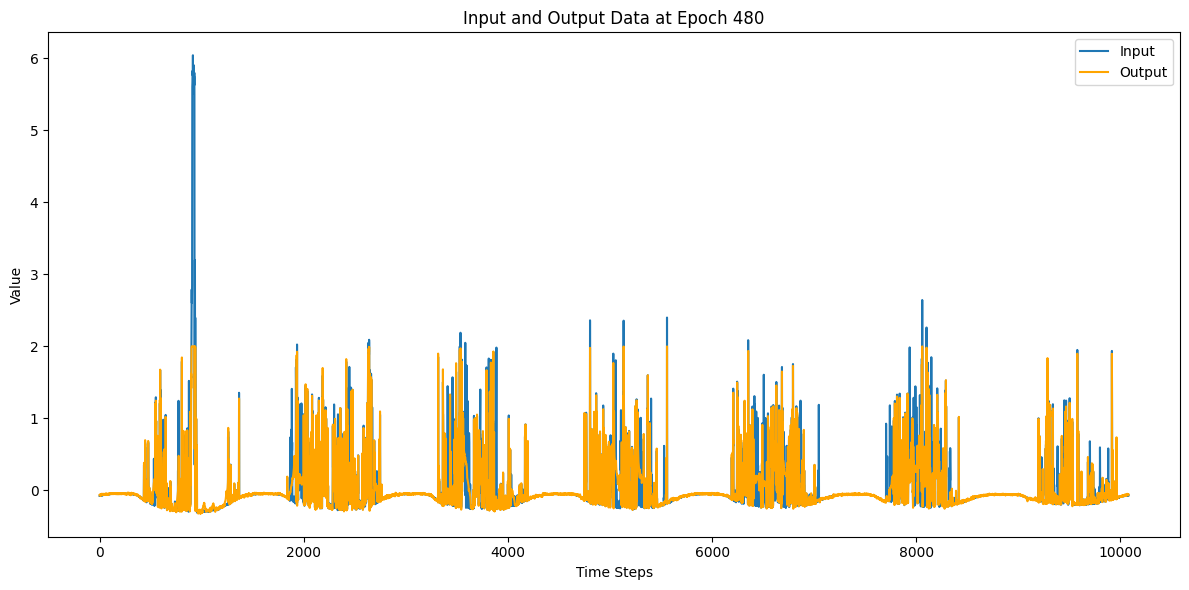

151/151 [==============================] - 6s 40ms/step - loss: 0.5392 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 481/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5427 - val_loss: 0.7154 - lr: 5.0000e-04
Epoch 482/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7154 - lr: 5.0000e-04
Epoch 483/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 484/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5441 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 485/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7154 - lr: 5.0000e-04
Epoch 486/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7153 - lr: 5.0000e-04
Epoch 487/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 488/10000
151/151 [=======

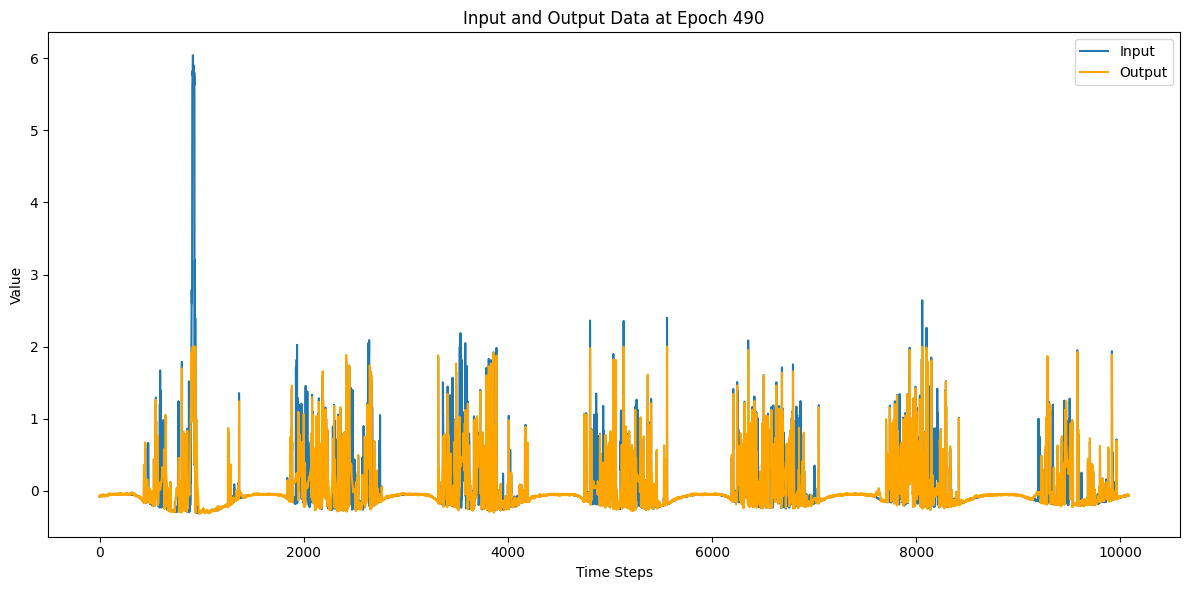

151/151 [==============================] - 6s 41ms/step - loss: 0.5400 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 491/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5396 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 492/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 493/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 494/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5427 - val_loss: 0.7147 - lr: 5.0000e-04
Epoch 495/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5401 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 496/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7146 - lr: 5.0000e-04
Epoch 497/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7146 - lr: 5.0000e-04
Epoch 498/10000
151/151 [=======

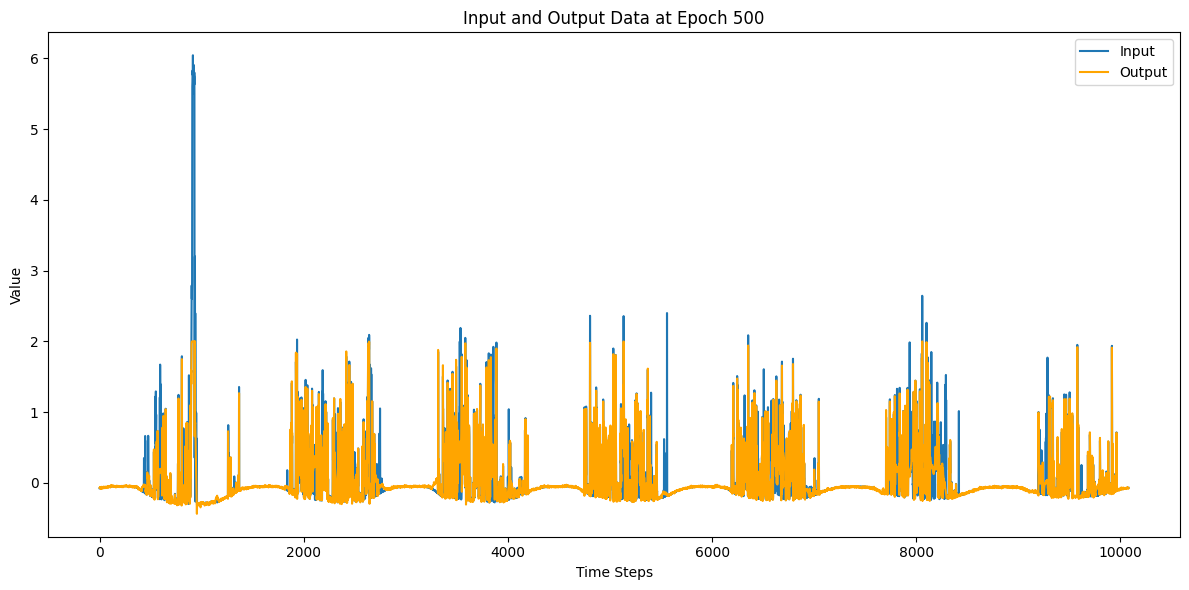

151/151 [==============================] - 7s 45ms/step - loss: 0.5396 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 501/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5424 - val_loss: 0.7152 - lr: 5.0000e-04
Epoch 502/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 503/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7147 - lr: 5.0000e-04
Epoch 504/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7145 - lr: 5.0000e-04
Epoch 505/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5404 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 506/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5390 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 507/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 508/10000
151/151 [=======

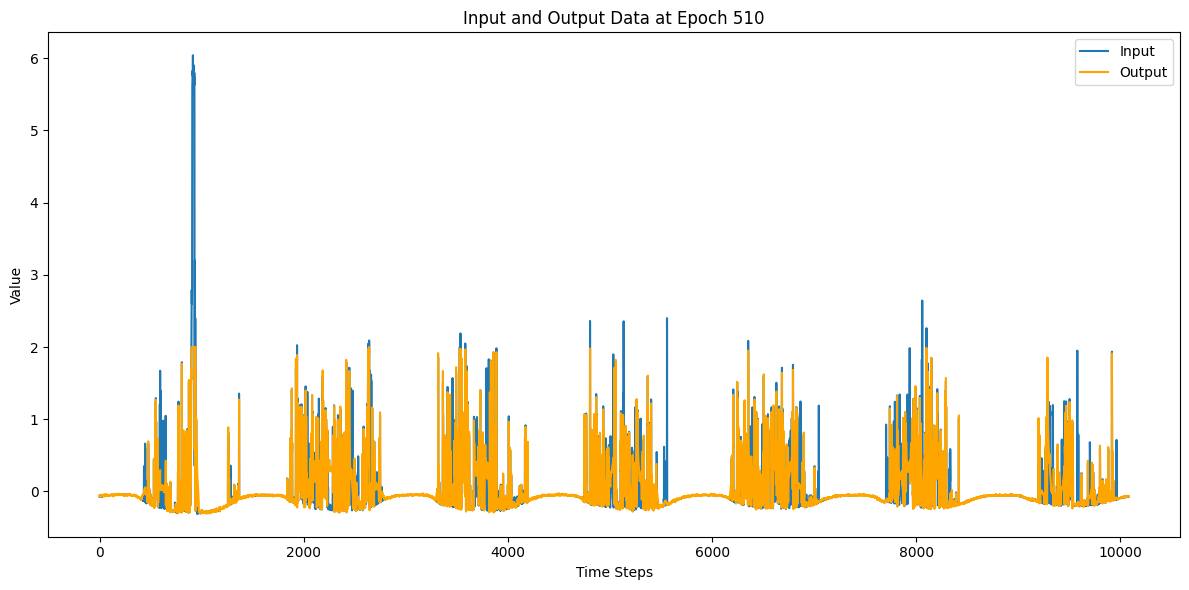

151/151 [==============================] - 6s 41ms/step - loss: 0.5430 - val_loss: 0.7151 - lr: 5.0000e-04
Epoch 511/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7150 - lr: 5.0000e-04
Epoch 512/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5391 - val_loss: 0.7146 - lr: 5.0000e-04
Epoch 513/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7148 - lr: 5.0000e-04
Epoch 514/10000
151/151 [==============================] - ETA: 0s - loss: 0.5404
Epoch 514: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
151/151 [==============================] - 5s 34ms/step - loss: 0.5404 - val_loss: 0.7149 - lr: 5.0000e-04
Epoch 515/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7146 - lr: 2.5000e-04
Epoch 516/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7150 - lr: 2.5000e-04
Epoch 517/1

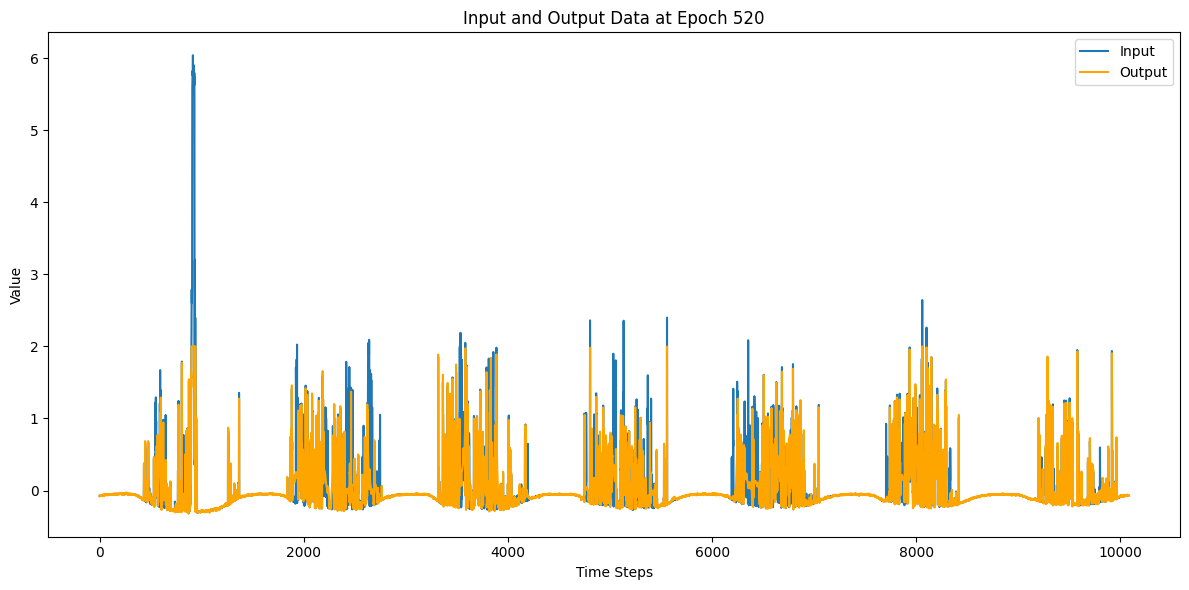

151/151 [==============================] - 6s 41ms/step - loss: 0.5389 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 521/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5391 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 522/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7143 - lr: 2.5000e-04
Epoch 523/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7150 - lr: 2.5000e-04
Epoch 524/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5390 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 525/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7143 - lr: 2.5000e-04
Epoch 526/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7151 - lr: 2.5000e-04
Epoch 527/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5388 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 528/10000
151/151 [=======

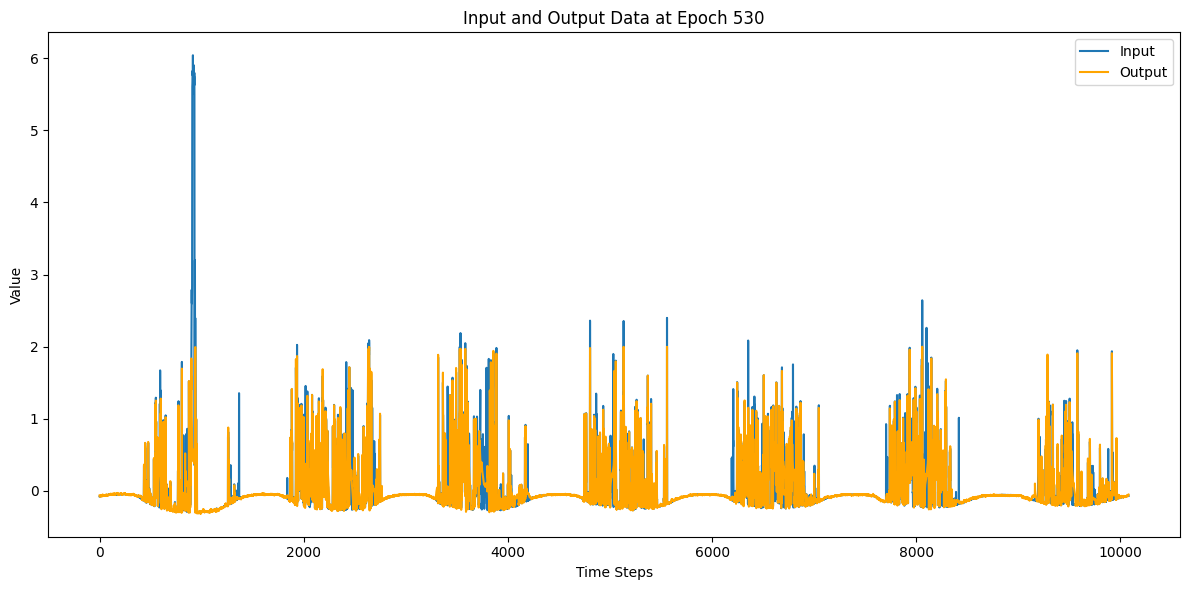

151/151 [==============================] - 6s 40ms/step - loss: 0.5388 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 531/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5397 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 532/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 533/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7142 - lr: 2.5000e-04
Epoch 534/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7149 - lr: 2.5000e-04
Epoch 535/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7145 - lr: 2.5000e-04
Epoch 536/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5412 - val_loss: 0.7150 - lr: 2.5000e-04
Epoch 537/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5416 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 538/10000
151/151 [=======

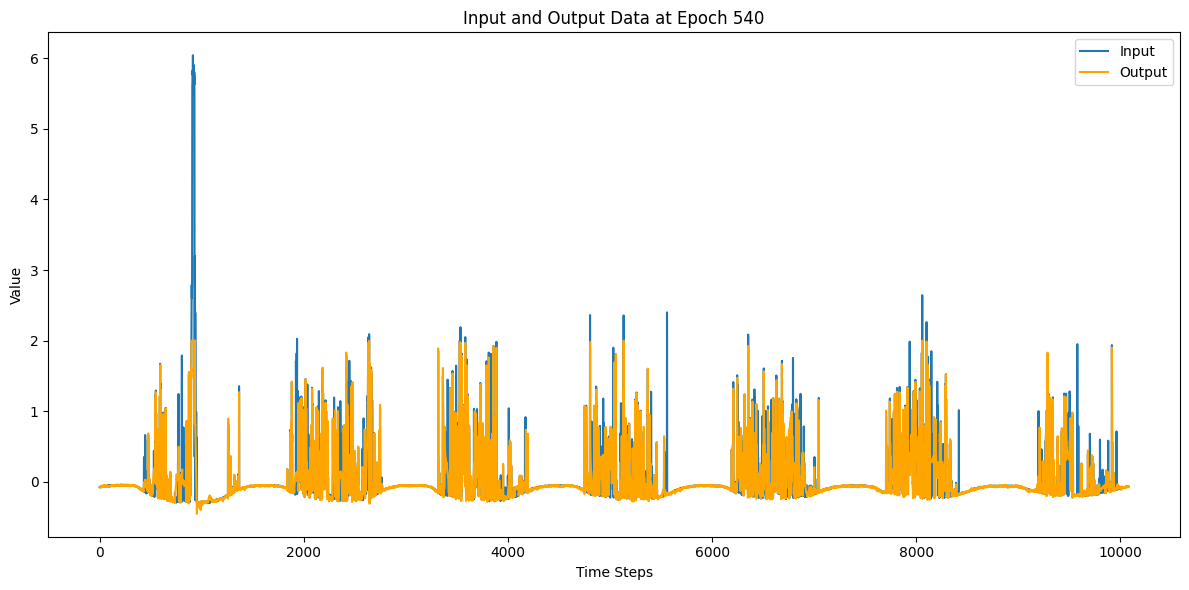

151/151 [==============================] - 6s 41ms/step - loss: 0.5450 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 541/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7145 - lr: 2.5000e-04
Epoch 542/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5473 - val_loss: 0.7146 - lr: 2.5000e-04
Epoch 543/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7150 - lr: 2.5000e-04
Epoch 544/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 545/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 546/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5452 - val_loss: 0.7146 - lr: 2.5000e-04
Epoch 547/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 548/10000
151/151 [=======

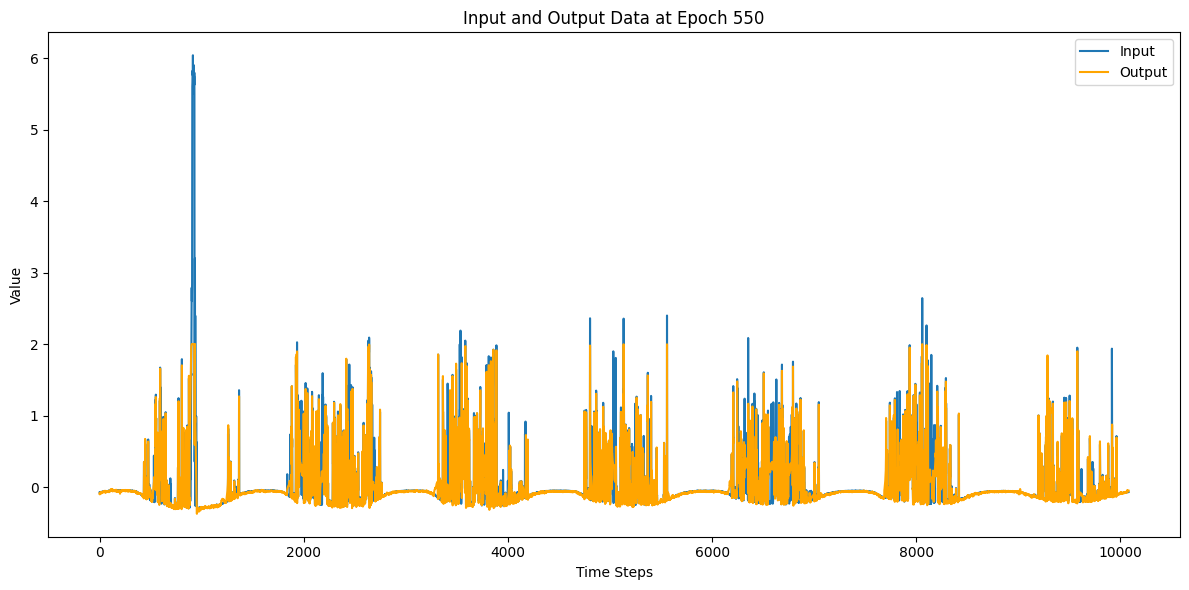

151/151 [==============================] - 6s 41ms/step - loss: 0.5424 - val_loss: 0.7146 - lr: 2.5000e-04
Epoch 551/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5389 - val_loss: 0.7145 - lr: 2.5000e-04
Epoch 552/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 553/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5390 - val_loss: 0.7149 - lr: 2.5000e-04
Epoch 554/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5389 - val_loss: 0.7149 - lr: 2.5000e-04
Epoch 555/10000
151/151 [==============================] - 6s 37ms/step - loss: 0.5387 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 556/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7145 - lr: 2.5000e-04
Epoch 557/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 558/10000
151/151 [=======

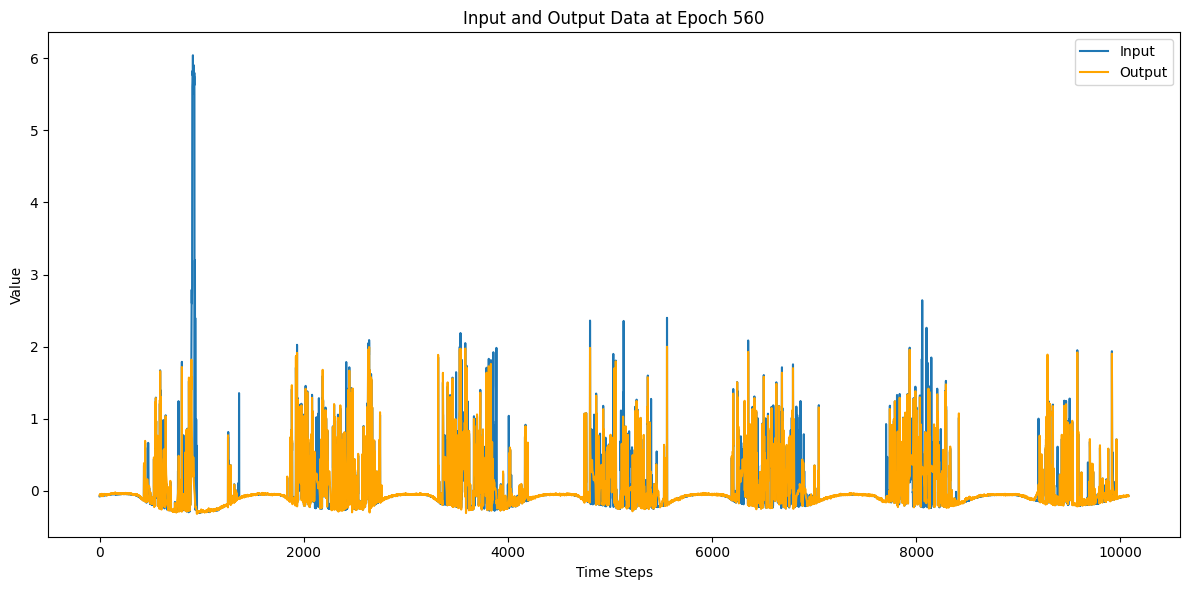

151/151 [==============================] - 6s 41ms/step - loss: 0.5389 - val_loss: 0.7143 - lr: 2.5000e-04
Epoch 561/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5396 - val_loss: 0.7142 - lr: 2.5000e-04
Epoch 562/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 563/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 564/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 565/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7146 - lr: 2.5000e-04
Epoch 566/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7145 - lr: 2.5000e-04
Epoch 567/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5460 - val_loss: 0.7143 - lr: 2.5000e-04
Epoch 568/10000
151/151 [=======

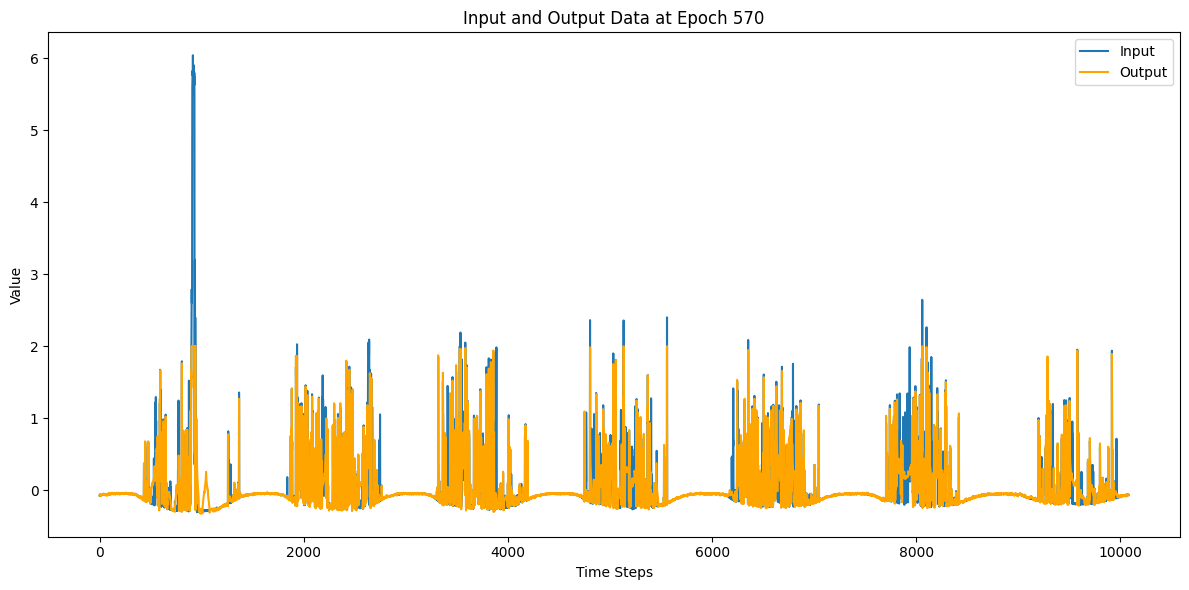

151/151 [==============================] - 6s 40ms/step - loss: 0.5387 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 571/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 572/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7149 - lr: 2.5000e-04
Epoch 573/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 574/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7146 - lr: 2.5000e-04
Epoch 575/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 576/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5423 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 577/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 578/10000
151/151 [=======

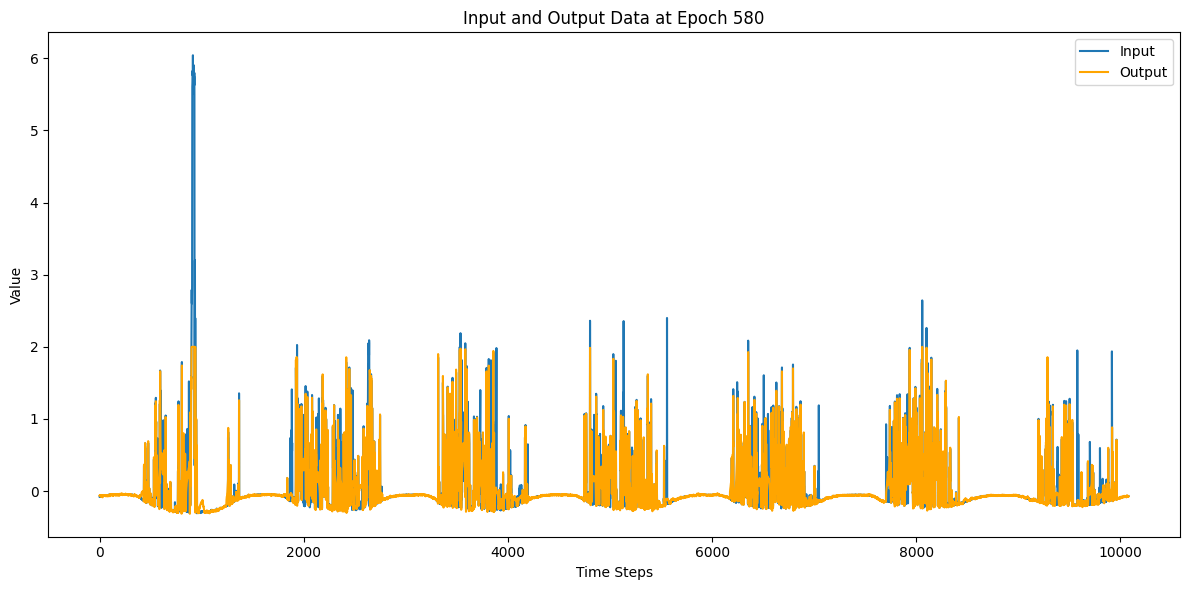

151/151 [==============================] - 6s 40ms/step - loss: 0.5389 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 581/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5427 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 582/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 583/10000
151/151 [==============================] - 6s 37ms/step - loss: 0.5416 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 584/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7150 - lr: 2.5000e-04
Epoch 585/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 586/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7145 - lr: 2.5000e-04
Epoch 587/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 588/10000
151/151 [=======

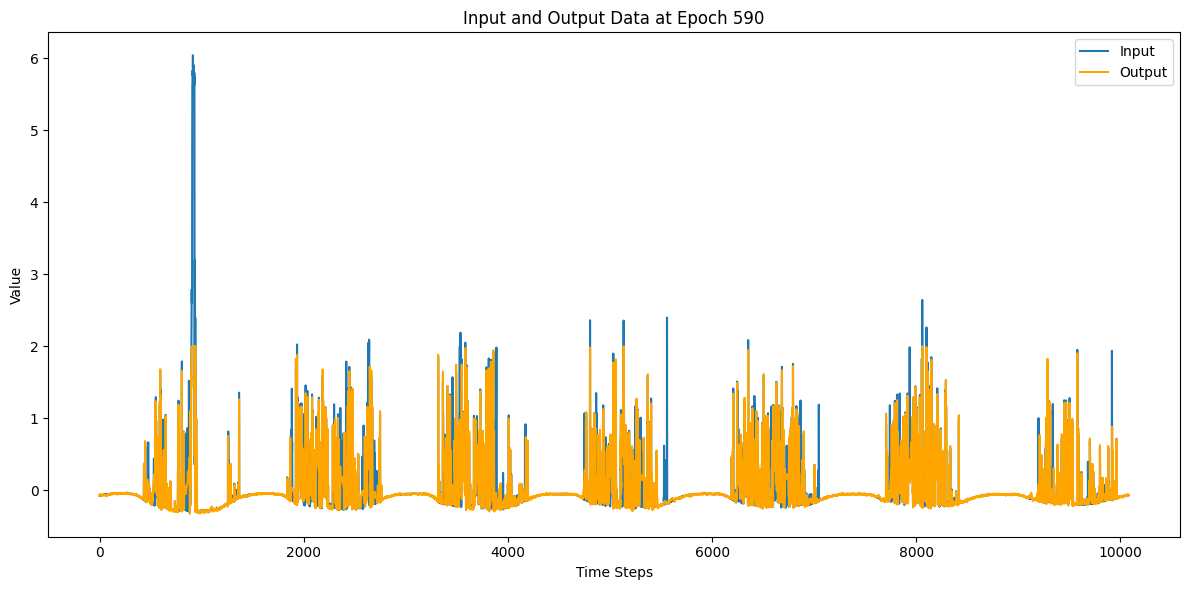

151/151 [==============================] - 6s 40ms/step - loss: 0.5388 - val_loss: 0.7144 - lr: 2.5000e-04
Epoch 591/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7146 - lr: 2.5000e-04
Epoch 592/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7149 - lr: 2.5000e-04
Epoch 593/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7145 - lr: 2.5000e-04
Epoch 594/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7147 - lr: 2.5000e-04
Epoch 595/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 596/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7148 - lr: 2.5000e-04
Epoch 597/10000
151/151 [==============================] - ETA: 0s - loss: 0.5389
Epoch 597: ReduceLROnPlateau reducing learning rate to 0.0001250000059371

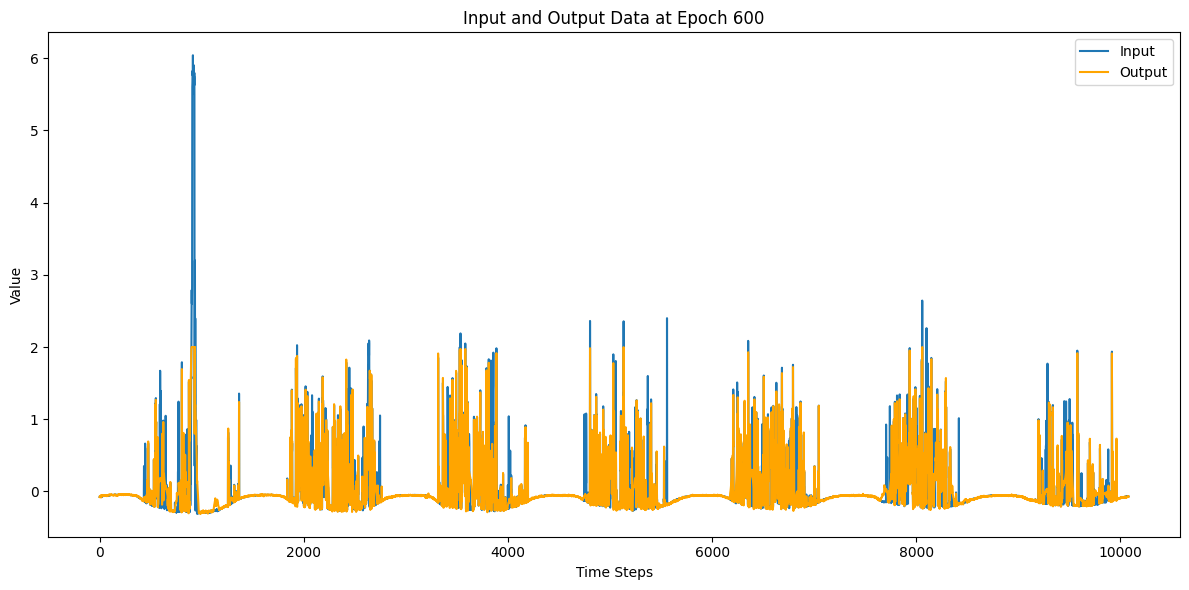

151/151 [==============================] - 6s 41ms/step - loss: 0.5409 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 601/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5387 - val_loss: 0.7139 - lr: 1.2500e-04
Epoch 602/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5431 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 603/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 604/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 605/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 606/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 607/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 608/10000
151/151 [=======

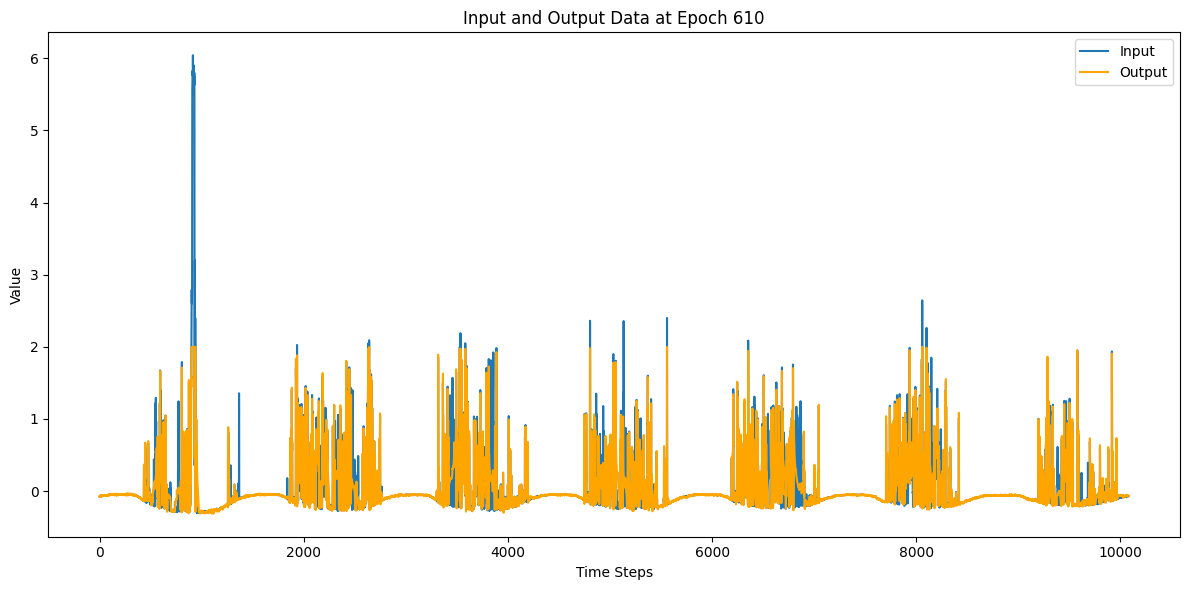

151/151 [==============================] - 6s 41ms/step - loss: 0.5501 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 611/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5409 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 612/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5386 - val_loss: 0.7147 - lr: 1.2500e-04
Epoch 613/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5424 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 614/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 615/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5425 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 616/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 617/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 618/10000
151/151 [=======

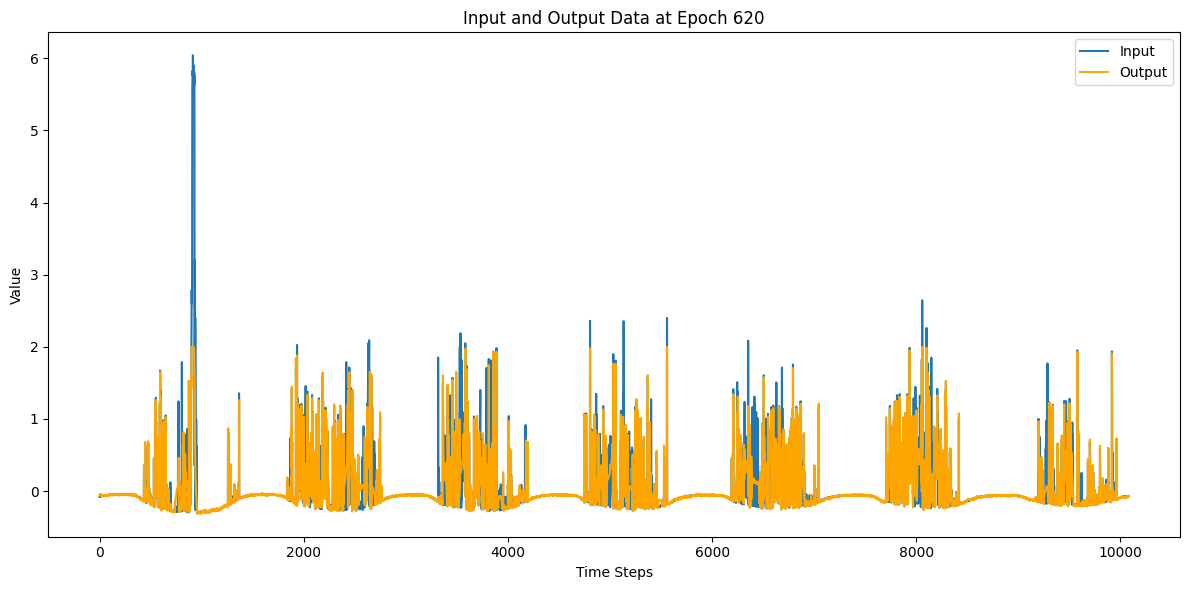

151/151 [==============================] - 6s 41ms/step - loss: 0.5387 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 621/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 622/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 623/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5502 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 624/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5405 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 625/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 626/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5401 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 627/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 628/10000
151/151 [=======

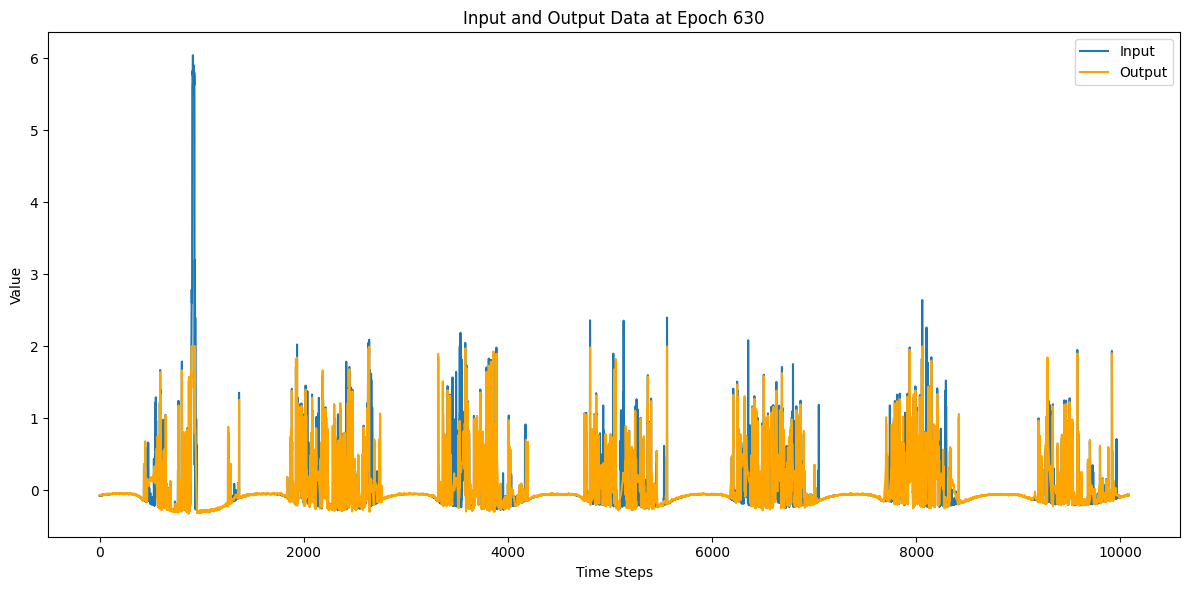

151/151 [==============================] - 6s 40ms/step - loss: 0.5386 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 631/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7148 - lr: 1.2500e-04
Epoch 632/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 633/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5502 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 634/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 635/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5386 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 636/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 637/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 638/10000
151/151 [=======

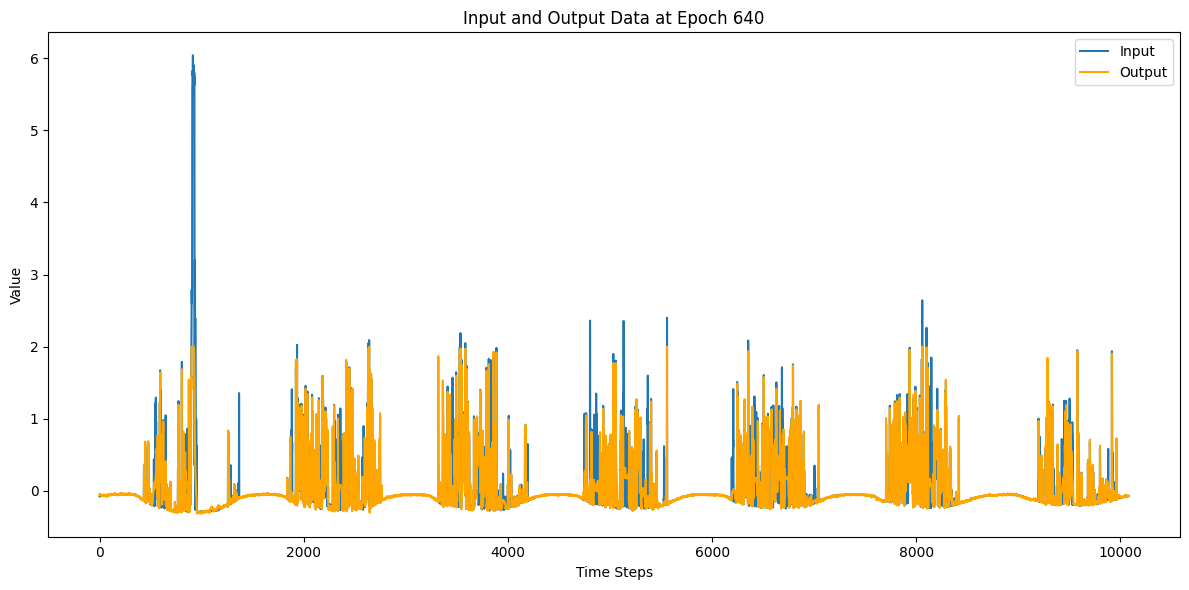

151/151 [==============================] - 7s 44ms/step - loss: 0.5398 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 641/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 642/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 643/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 644/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 645/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 646/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5469 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 647/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 648/10000
151/151 [=======

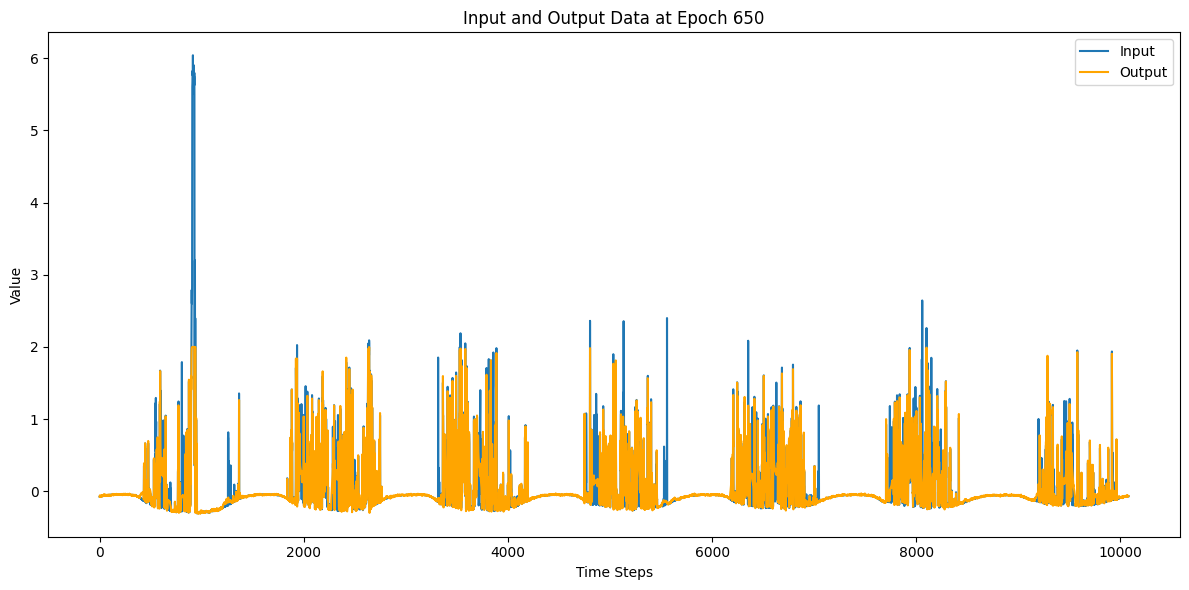

151/151 [==============================] - 6s 42ms/step - loss: 0.5468 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 651/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 652/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 653/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7147 - lr: 1.2500e-04
Epoch 654/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 655/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7148 - lr: 1.2500e-04
Epoch 656/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 657/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 658/10000
151/151 [=======

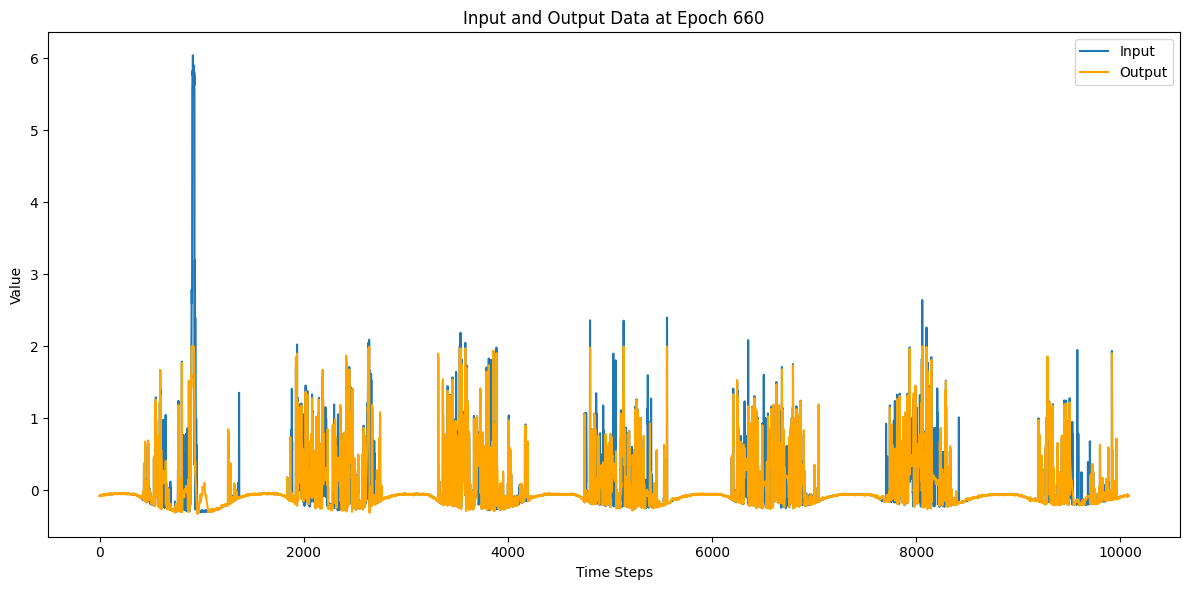

151/151 [==============================] - 6s 40ms/step - loss: 0.5386 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 661/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 662/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 663/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 664/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 665/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5386 - val_loss: 0.7137 - lr: 1.2500e-04
Epoch 666/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 667/10000
151/151 [==============================] - 6s 37ms/step - loss: 0.5386 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 668/10000
151/151 [=======

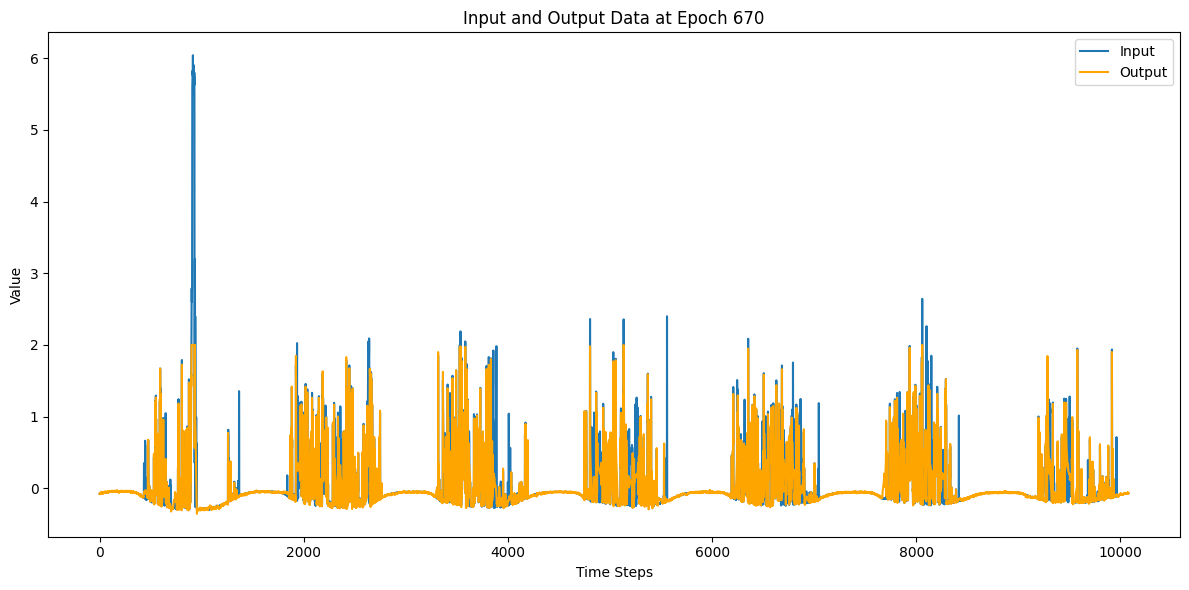

151/151 [==============================] - 6s 40ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 671/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7147 - lr: 1.2500e-04
Epoch 672/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 673/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 674/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 675/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 676/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5531 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 677/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 678/10000
151/151 [=======

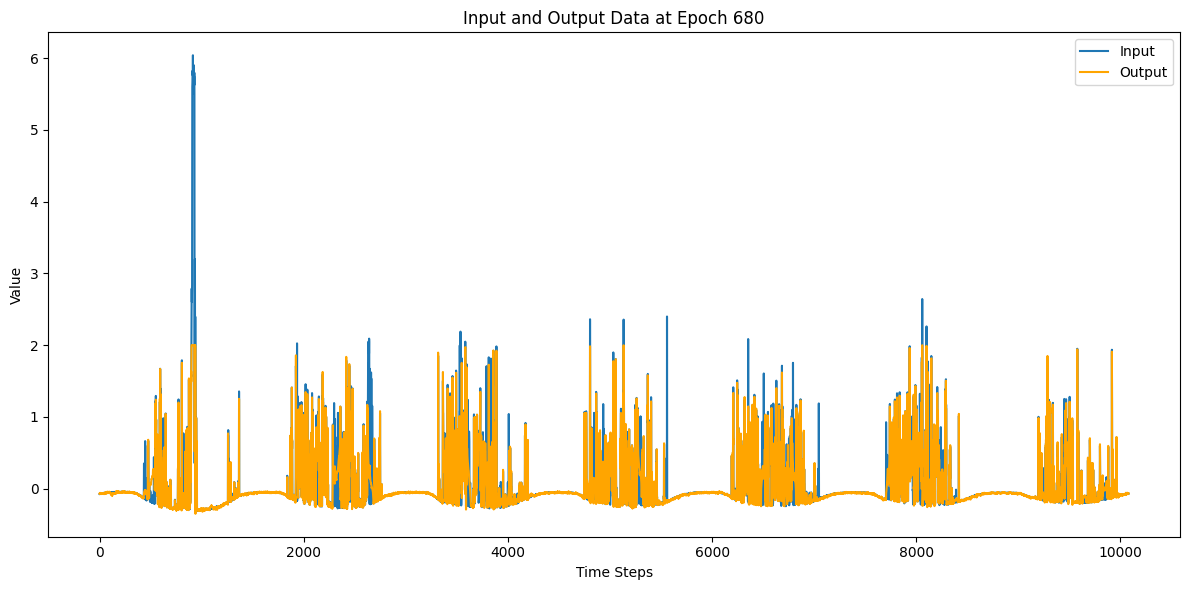

151/151 [==============================] - 6s 40ms/step - loss: 0.5437 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 681/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5385 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 682/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5392 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 683/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 684/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5422 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 685/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5428 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 686/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 687/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 688/10000
151/151 [=======

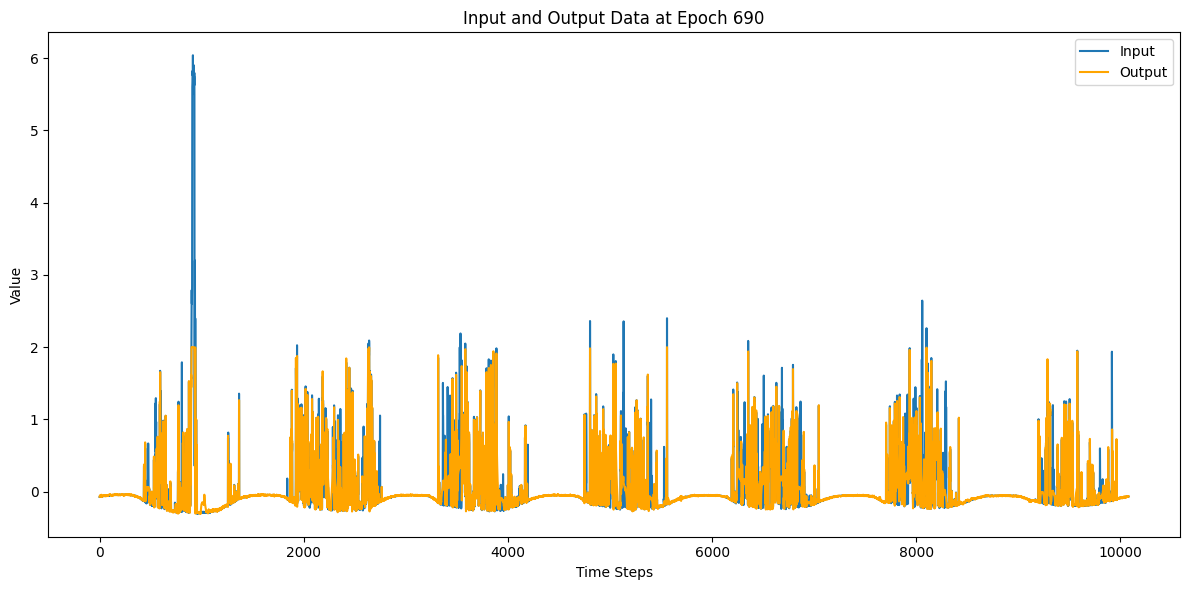

151/151 [==============================] - 6s 40ms/step - loss: 0.5421 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 691/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 692/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 693/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 694/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 695/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 696/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5407 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 697/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 698/10000
151/151 [=======

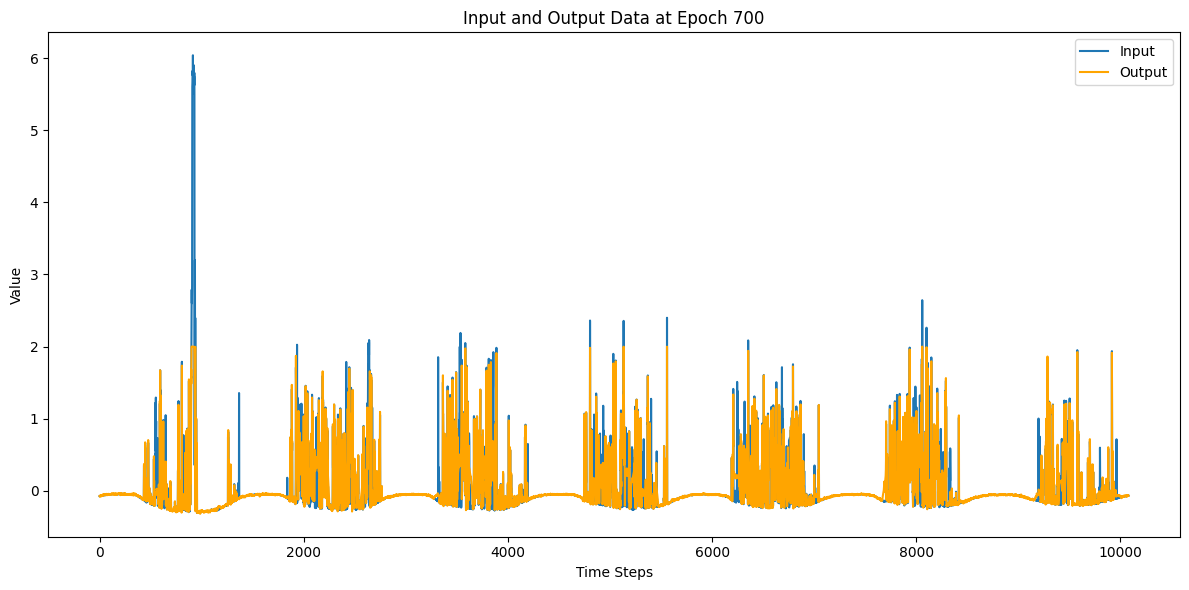

151/151 [==============================] - 6s 41ms/step - loss: 0.5398 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 701/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 702/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5420 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 703/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 704/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5491 - val_loss: 0.7145 - lr: 1.2500e-04
Epoch 705/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 706/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 707/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5384 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 708/10000
151/151 [=======

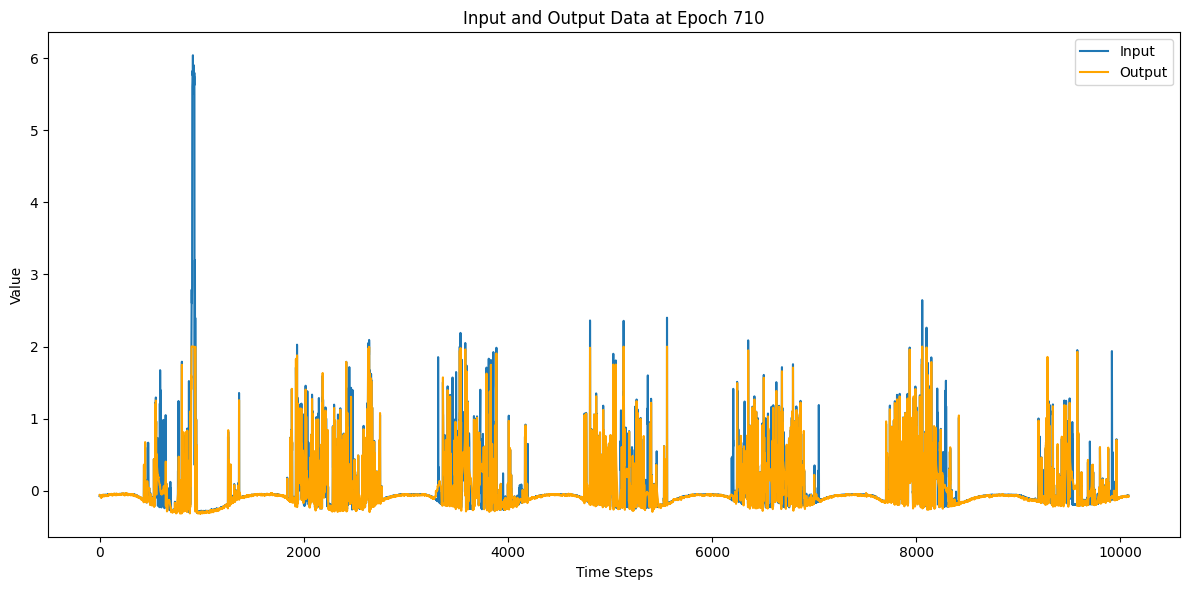

151/151 [==============================] - 6s 41ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 711/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 712/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 713/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 714/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 715/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5394 - val_loss: 0.7147 - lr: 1.2500e-04
Epoch 716/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5393 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 717/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 718/10000
151/151 [=======

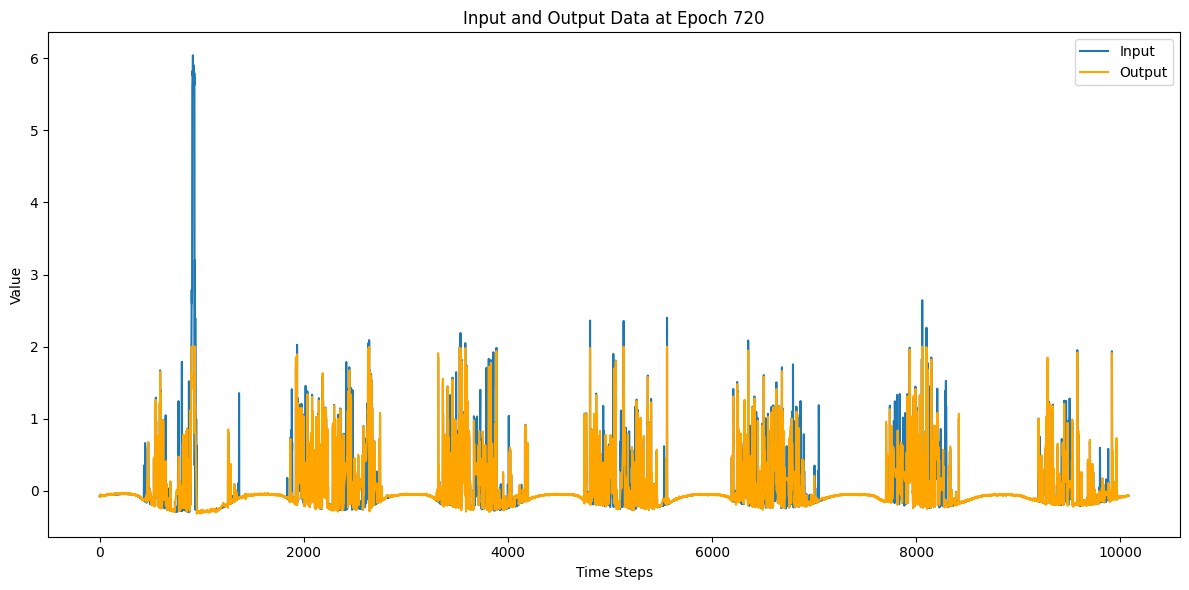

151/151 [==============================] - 6s 41ms/step - loss: 0.5386 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 721/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7142 - lr: 1.2500e-04
Epoch 722/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 723/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7147 - lr: 1.2500e-04
Epoch 724/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 725/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5406 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 726/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 727/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7147 - lr: 1.2500e-04
Epoch 728/10000
151/151 [=======

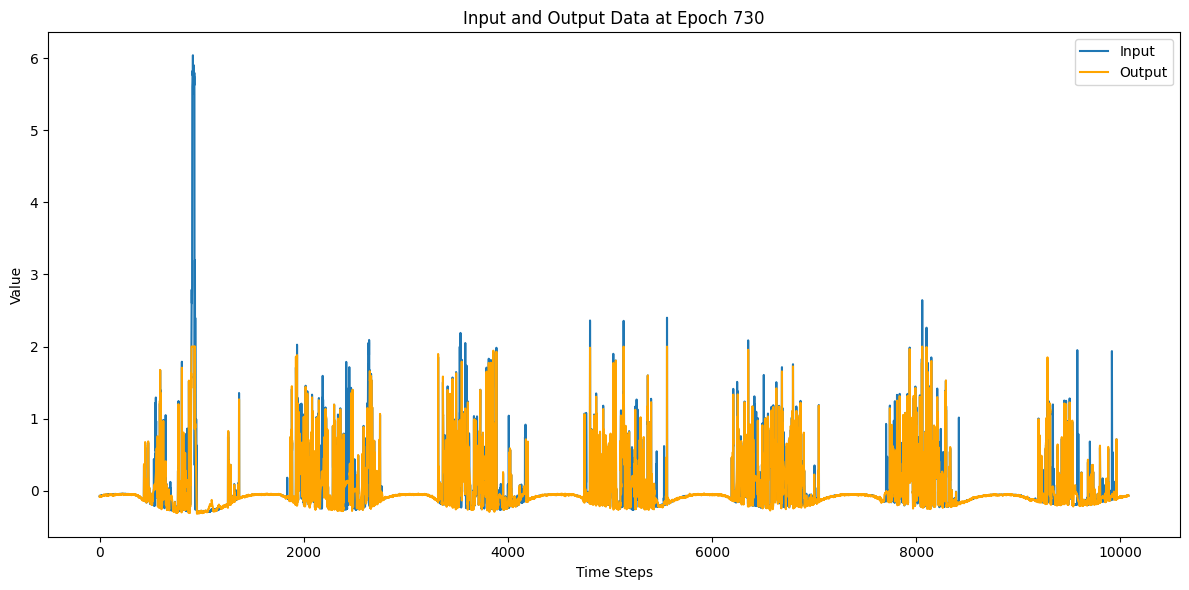

151/151 [==============================] - 6s 40ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 731/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5409 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 732/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7146 - lr: 1.2500e-04
Epoch 733/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 734/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5537 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 735/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5502 - val_loss: 0.7143 - lr: 1.2500e-04
Epoch 736/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 737/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5403 - val_loss: 0.7141 - lr: 1.2500e-04
Epoch 738/10000
151/151 [=======

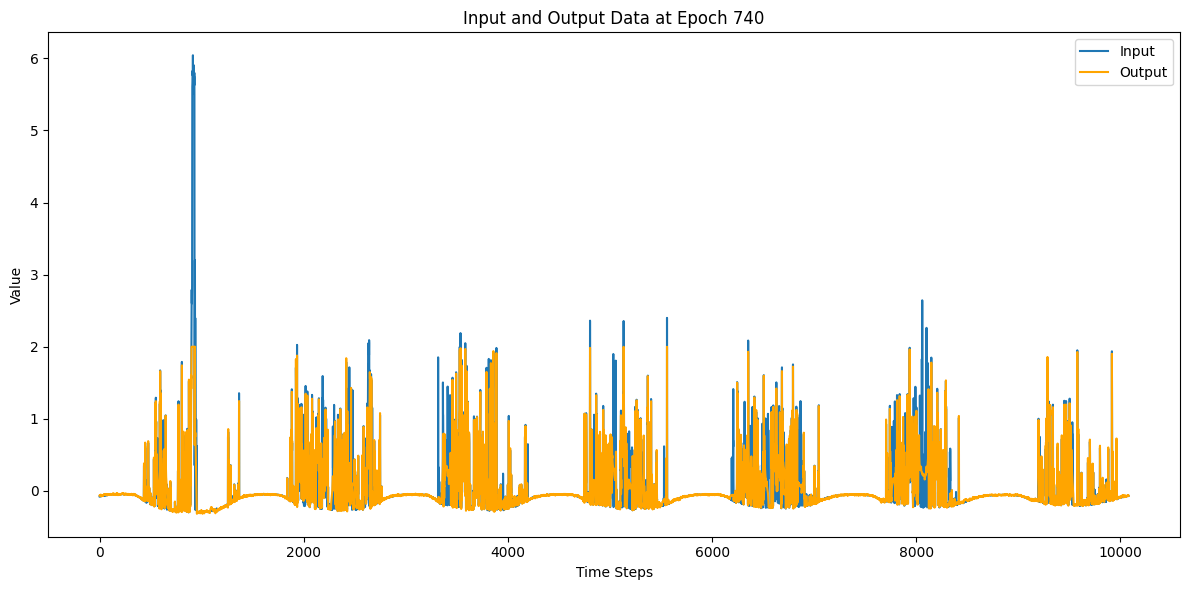

151/151 [==============================] - 6s 41ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.2500e-04
Epoch 741/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5393 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 742/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 743/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5406 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 744/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 745/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7148 - lr: 1.0000e-04
Epoch 746/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 747/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 748/10000
151/151 [=======

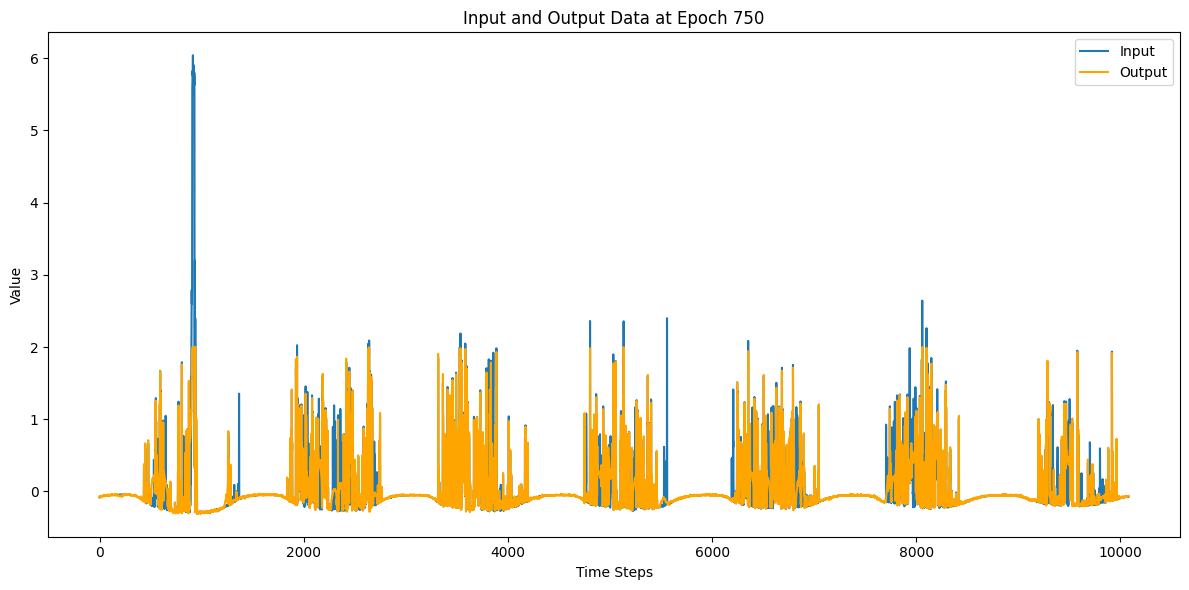

151/151 [==============================] - 6s 41ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 751/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 752/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 753/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 754/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 755/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 756/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 757/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 758/10000
151/151 [=======

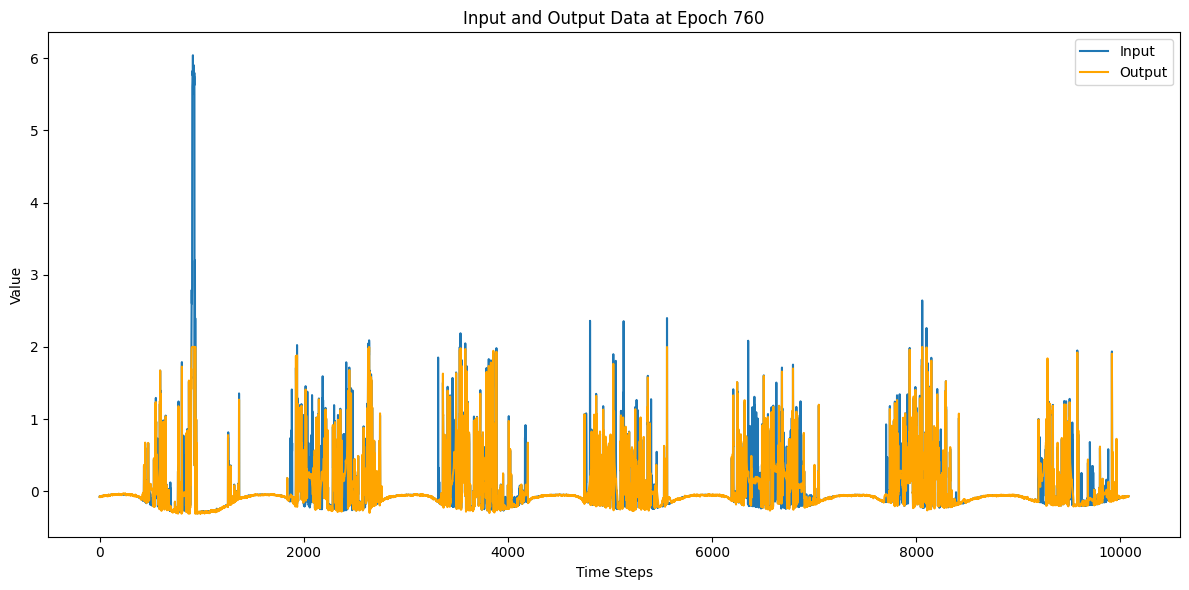

151/151 [==============================] - 6s 40ms/step - loss: 0.5385 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 761/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 762/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5422 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 763/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 764/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 765/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 766/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5410 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 767/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 768/10000
151/151 [=======

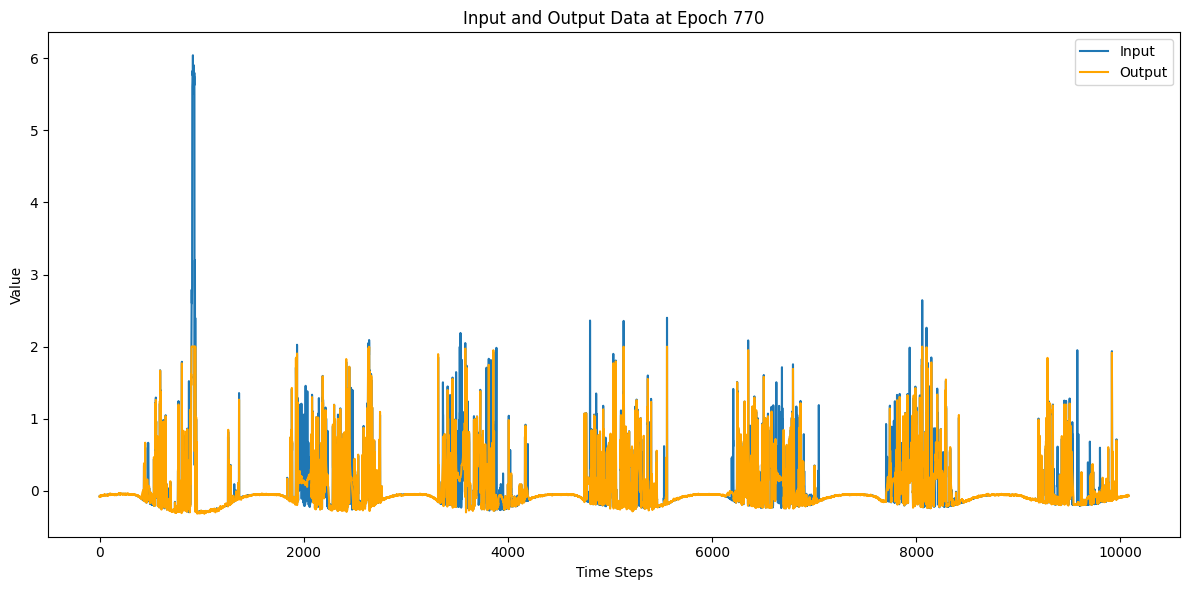

151/151 [==============================] - 6s 40ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 771/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 772/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 773/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 774/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 775/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 776/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 777/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5383 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 778/10000
151/151 [=======

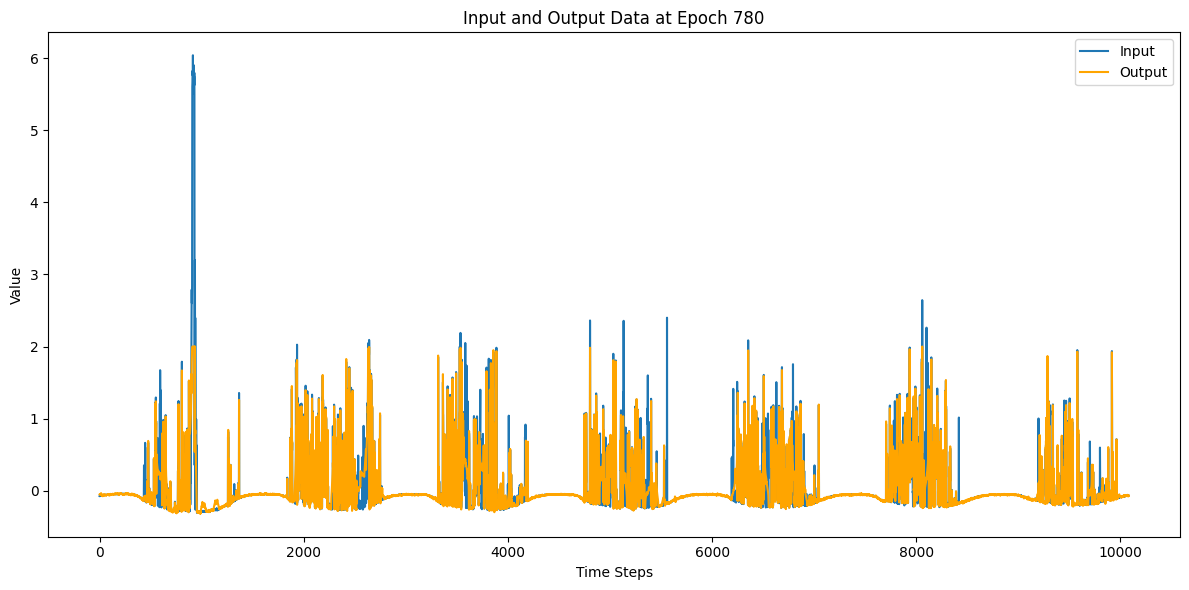

151/151 [==============================] - 6s 40ms/step - loss: 0.5385 - val_loss: 0.7147 - lr: 1.0000e-04
Epoch 781/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 782/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5388 - val_loss: 0.7147 - lr: 1.0000e-04
Epoch 783/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 784/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 785/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 786/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5402 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 787/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 788/10000
151/151 [=======

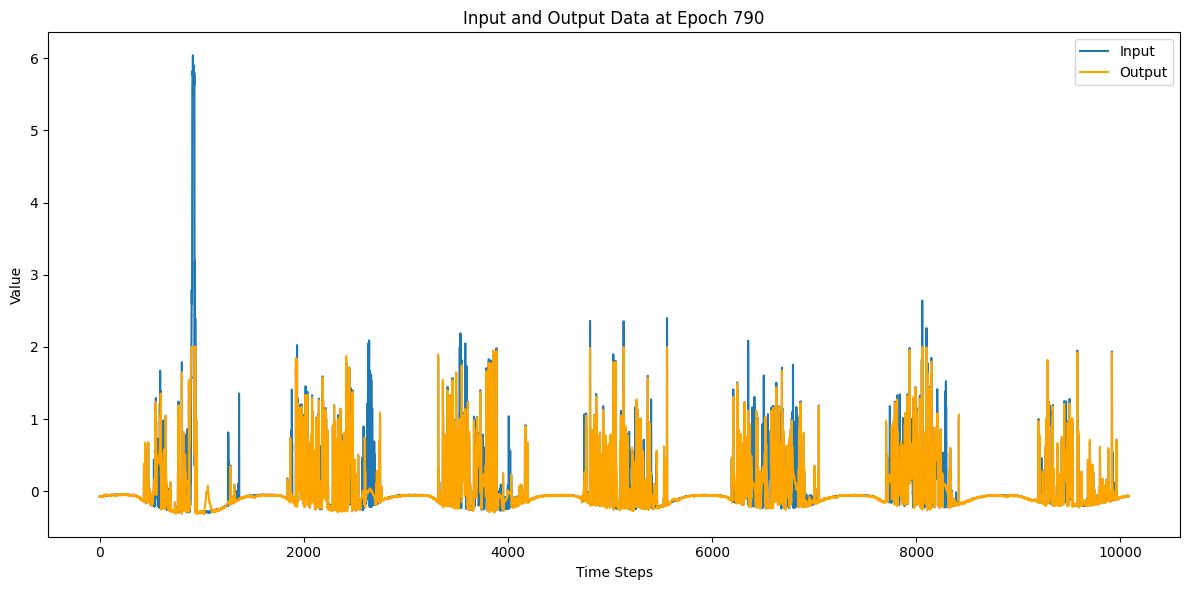

151/151 [==============================] - 6s 40ms/step - loss: 0.5383 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 791/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 792/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5419 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 793/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 794/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 795/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7147 - lr: 1.0000e-04
Epoch 796/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 797/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 798/10000
151/151 [=======

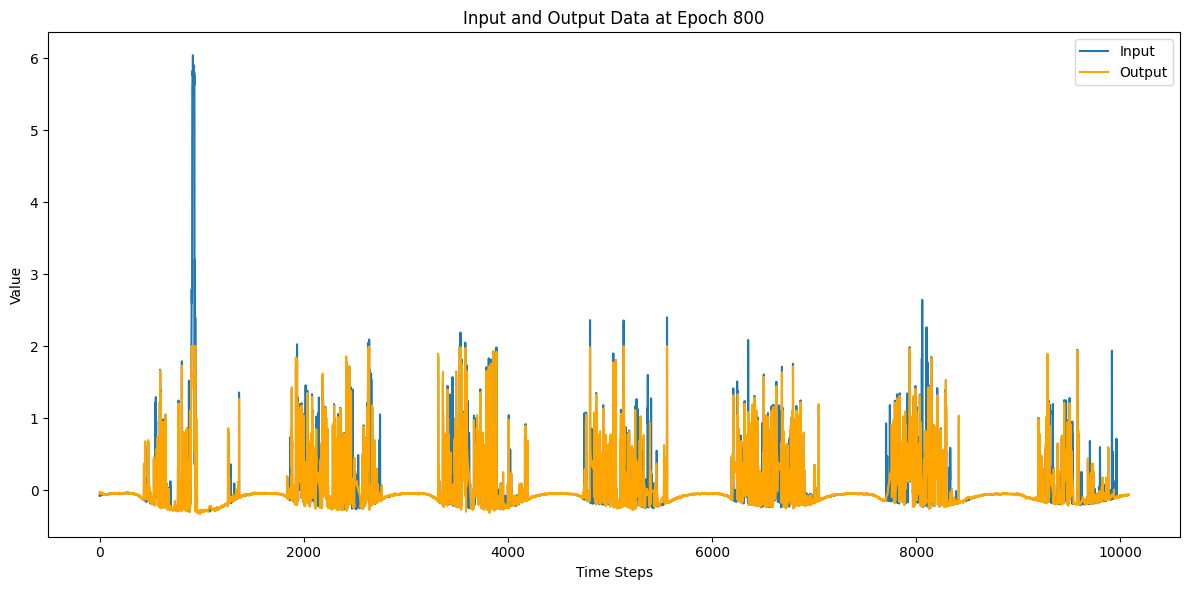

151/151 [==============================] - 6s 41ms/step - loss: 0.5384 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 801/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 802/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 803/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 804/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 805/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 806/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 807/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 808/10000
151/151 [=======

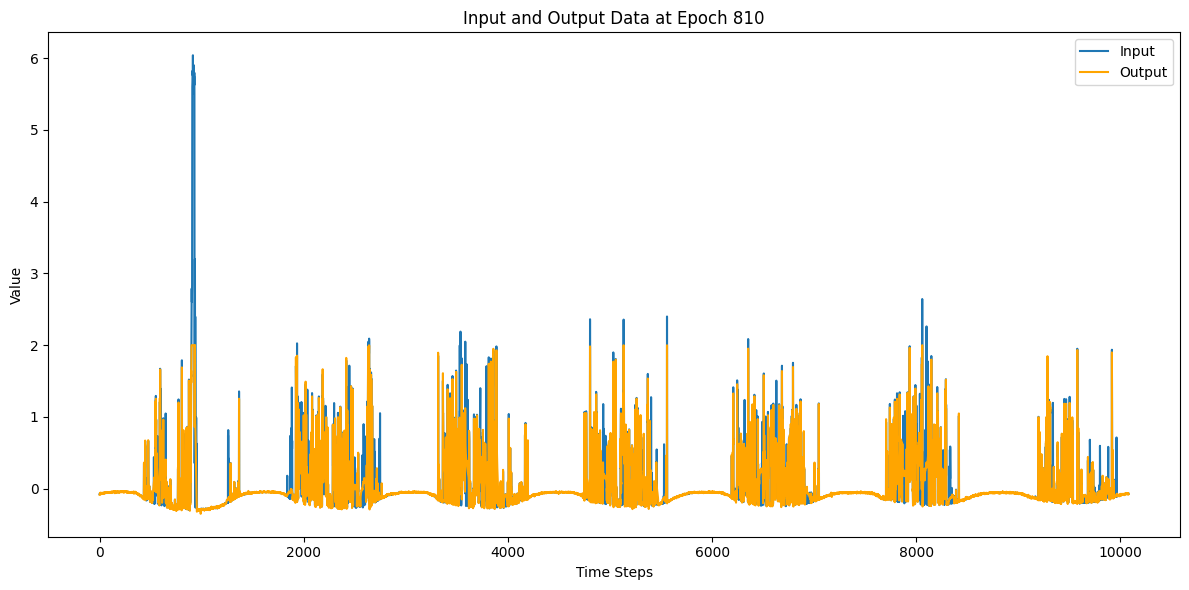

151/151 [==============================] - 6s 41ms/step - loss: 0.5384 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 811/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 812/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 813/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7147 - lr: 1.0000e-04
Epoch 814/10000
151/151 [==============================] - 5s 33ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 815/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 816/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 817/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5406 - val_loss: 0.7140 - lr: 1.0000e-04
Epoch 818/10000
151/151 [=======

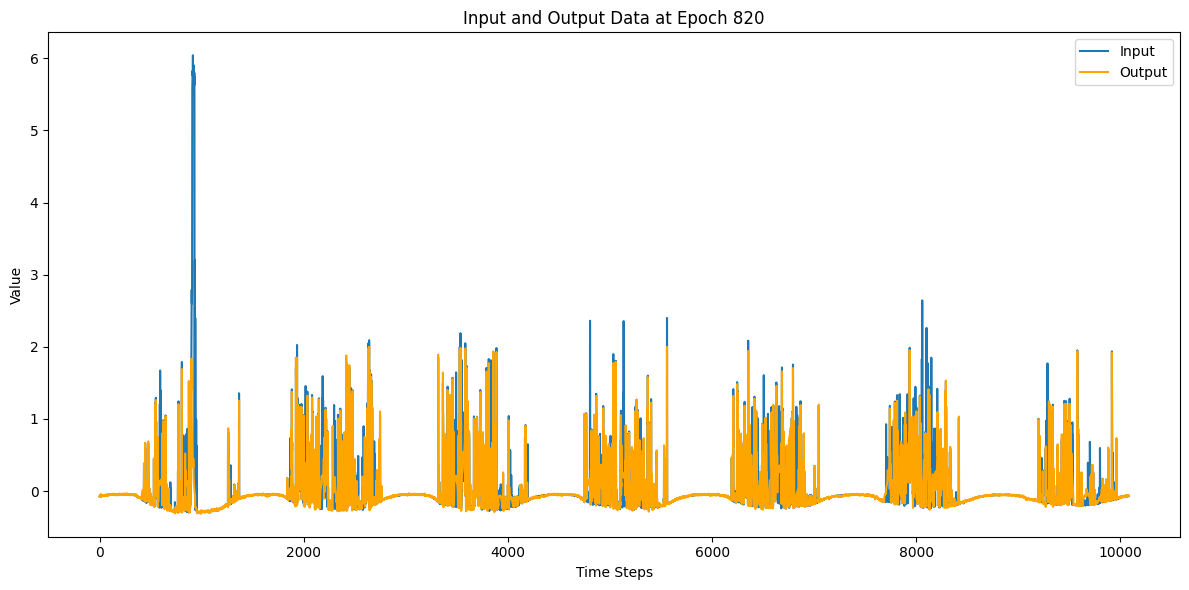

151/151 [==============================] - 6s 41ms/step - loss: 0.5446 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 821/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7139 - lr: 1.0000e-04
Epoch 822/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5456 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 823/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 824/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7147 - lr: 1.0000e-04
Epoch 825/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7140 - lr: 1.0000e-04
Epoch 826/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 827/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 828/10000
151/151 [=======

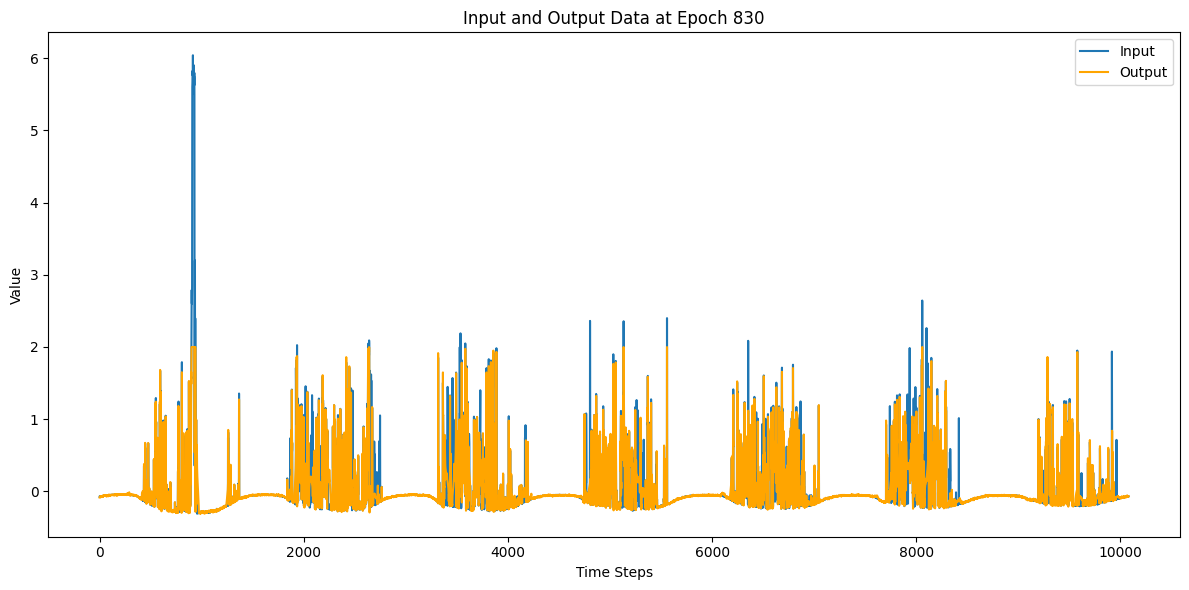

151/151 [==============================] - 6s 40ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 831/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 832/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 833/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 834/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 835/10000
151/151 [==============================] - 6s 37ms/step - loss: 0.5385 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 836/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 837/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7149 - lr: 1.0000e-04
Epoch 838/10000
151/151 [=======

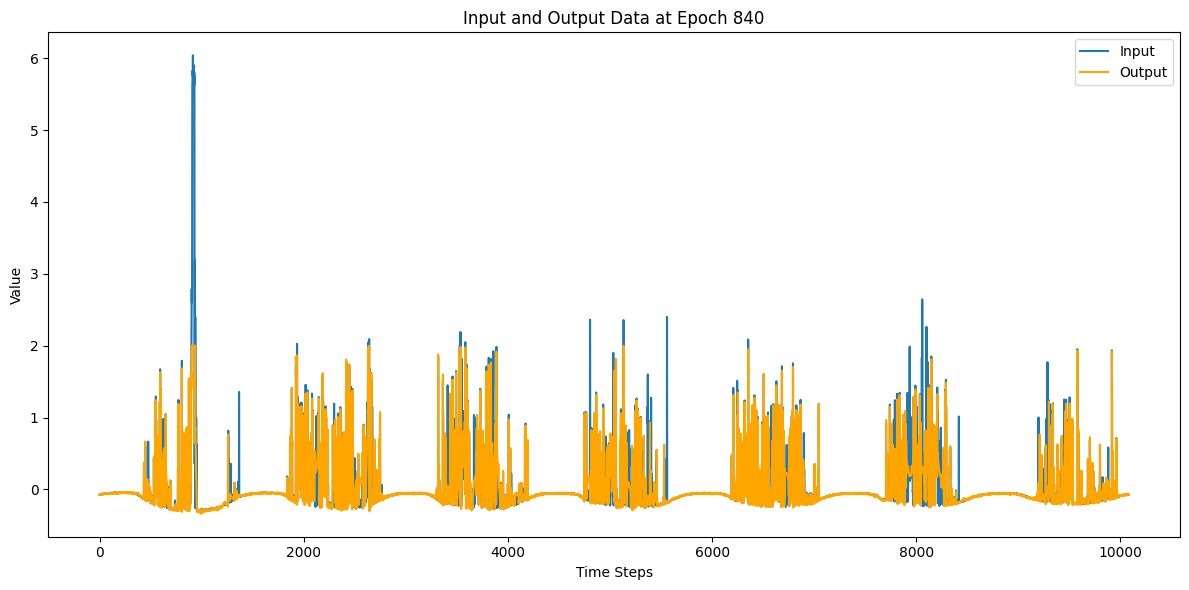

151/151 [==============================] - 6s 40ms/step - loss: 0.5421 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 841/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 842/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5492 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 843/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5500 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 844/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 845/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 846/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 847/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7139 - lr: 1.0000e-04
Epoch 848/10000
151/151 [=======

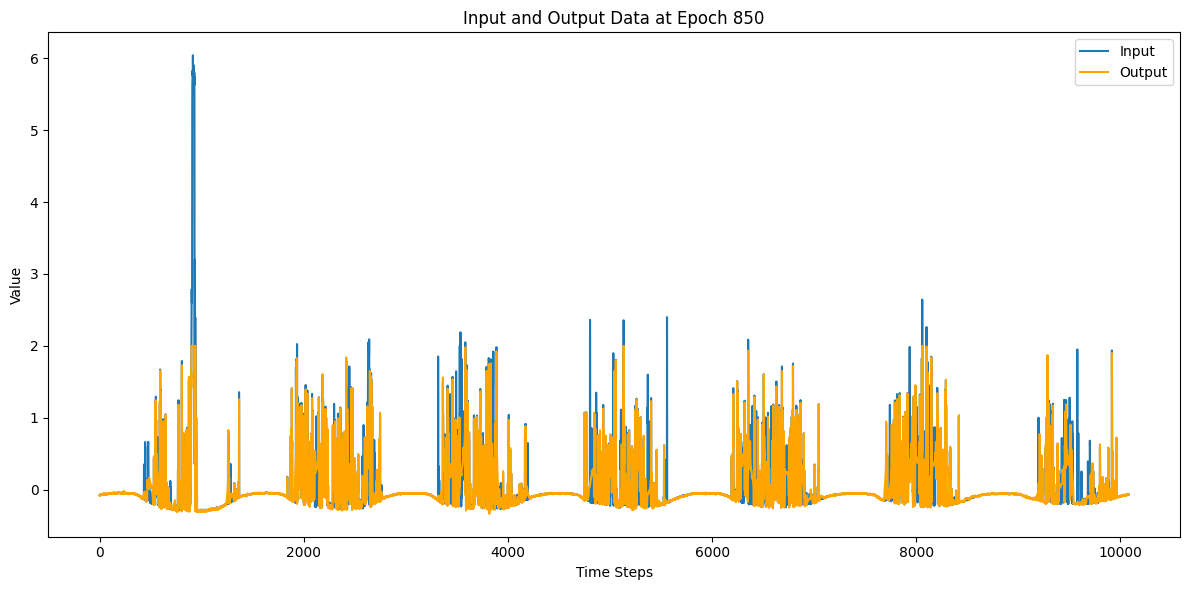

151/151 [==============================] - 6s 41ms/step - loss: 0.5420 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 851/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 852/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5399 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 853/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5392 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 854/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 855/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 856/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 857/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 858/10000
151/151 [=======

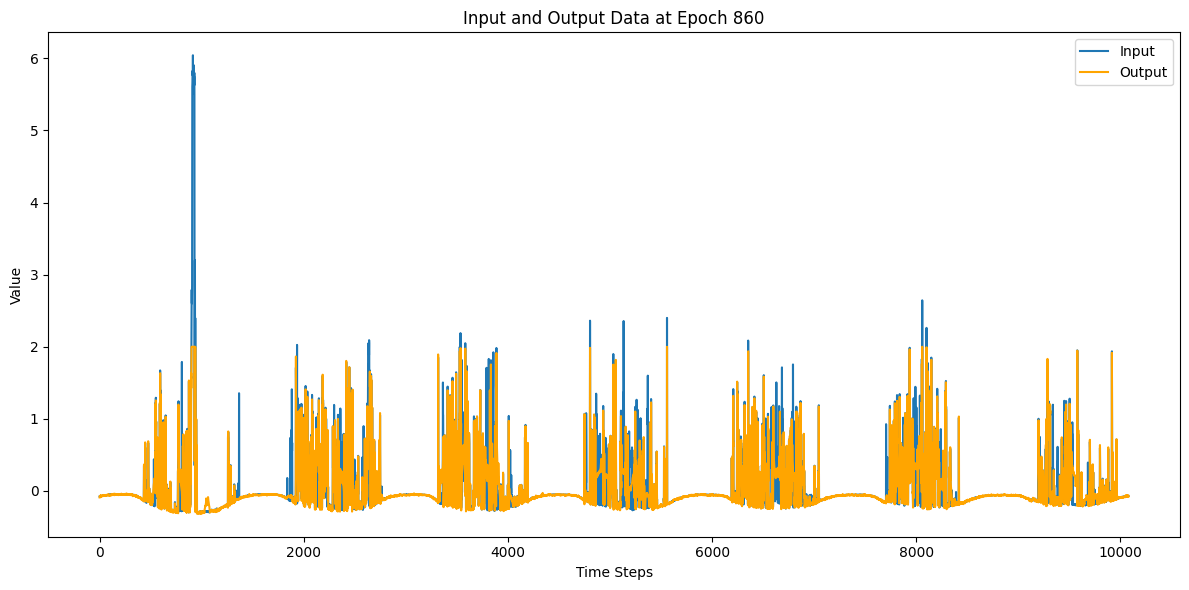

151/151 [==============================] - 6s 41ms/step - loss: 0.5385 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 861/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 862/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 863/10000
151/151 [==============================] - 6s 38ms/step - loss: 0.5383 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 864/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 865/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 866/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5420 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 867/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 868/10000
151/151 [=======

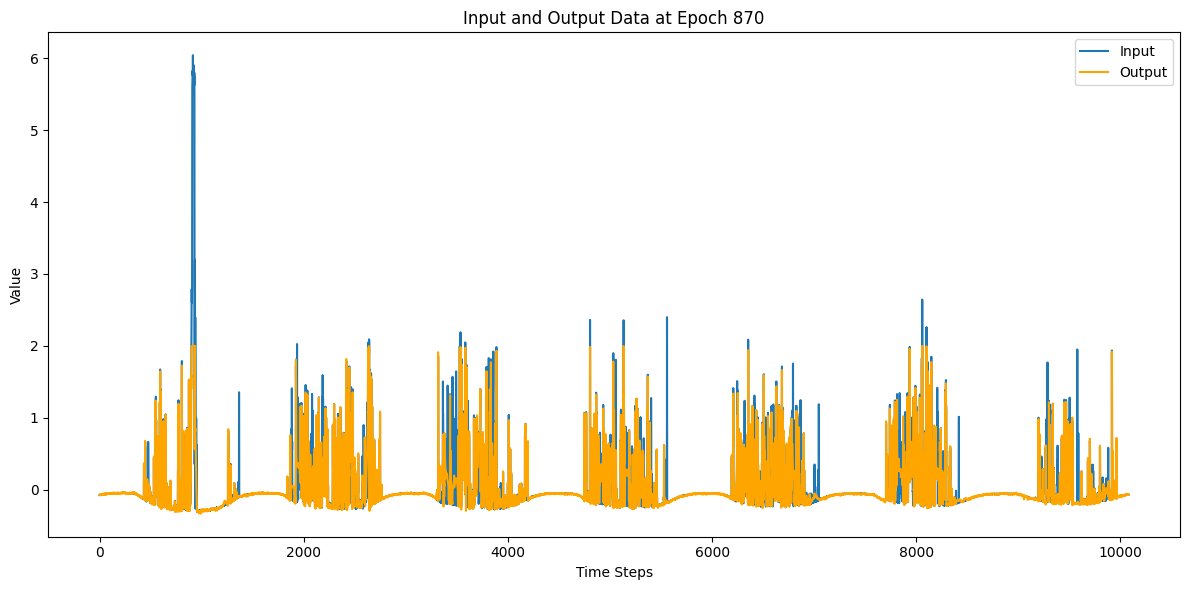

151/151 [==============================] - 6s 41ms/step - loss: 0.5394 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 871/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 872/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5413 - val_loss: 0.7140 - lr: 1.0000e-04
Epoch 873/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 874/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 875/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5425 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 876/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 877/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5434 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 878/10000
151/151 [=======

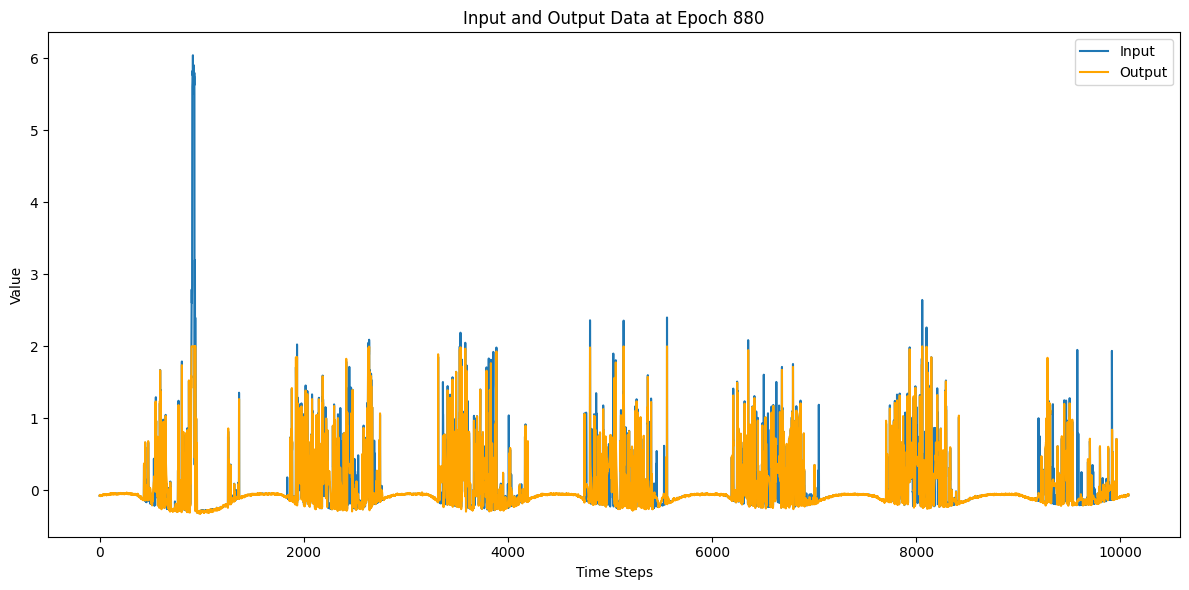

151/151 [==============================] - 6s 40ms/step - loss: 0.5384 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 881/10000
151/151 [==============================] - 5s 35ms/step - loss: 0.5384 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 882/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5387 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 883/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5390 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 884/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5408 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 885/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 886/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 887/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 888/10000
151/151 [=======

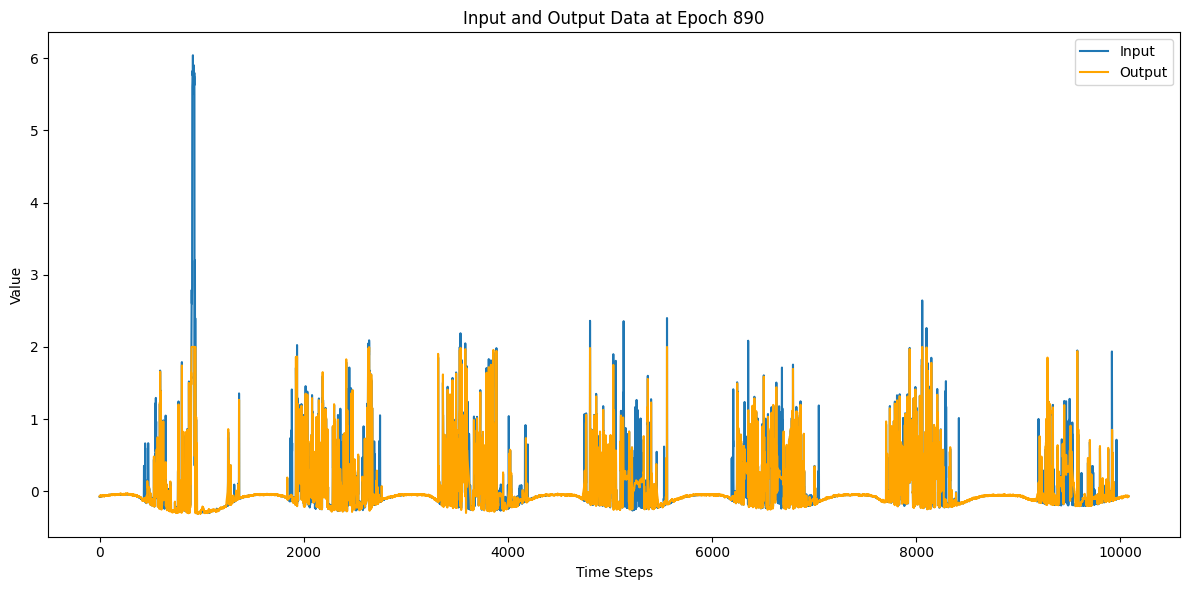

151/151 [==============================] - 6s 41ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 891/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 892/10000
151/151 [==============================] - 6s 37ms/step - loss: 0.5385 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 893/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 894/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5414 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 895/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7142 - lr: 1.0000e-04
Epoch 896/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7146 - lr: 1.0000e-04
Epoch 897/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 898/10000
151/151 [=======

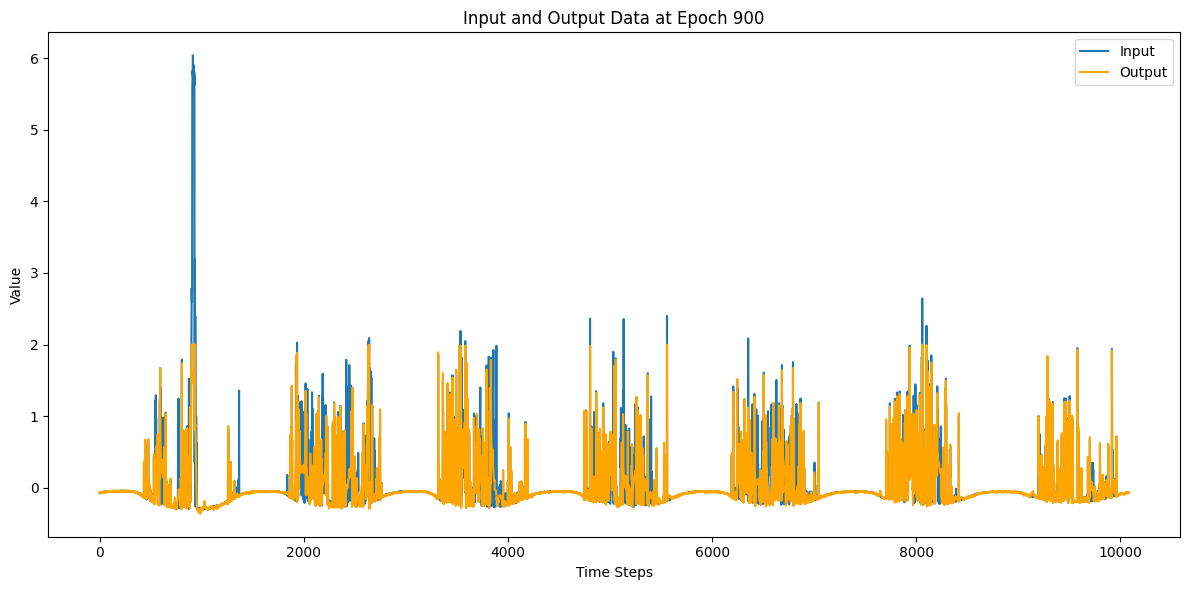

151/151 [==============================] - 6s 40ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 901/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5386 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 902/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5389 - val_loss: 0.7140 - lr: 1.0000e-04
Epoch 903/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 904/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 905/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7147 - lr: 1.0000e-04
Epoch 906/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7143 - lr: 1.0000e-04
Epoch 907/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 908/10000
151/151 [=======

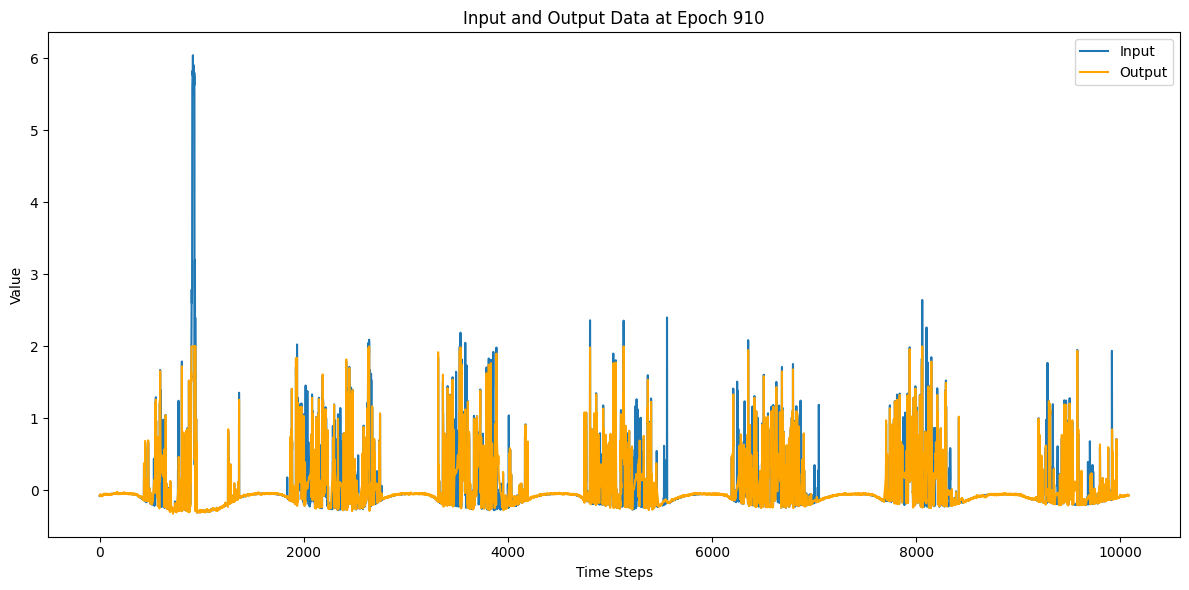

151/151 [==============================] - 6s 41ms/step - loss: 0.5390 - val_loss: 0.7141 - lr: 1.0000e-04
Epoch 911/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5384 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 912/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5385 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 913/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7145 - lr: 1.0000e-04
Epoch 914/10000
151/151 [==============================] - 5s 34ms/step - loss: 0.5383 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 915/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5390 - val_loss: 0.7144 - lr: 1.0000e-04
Epoch 915: early stopping


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Define your custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, function, frequency):
        super(CustomCallback, self).__init__()
        self.function = function
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            self.function(epoch + 1, logs)

# Define your custom function
def my_custom_function(epoch, logs):
    print(f"\n plotting.. output {epoch}")

    # Plot the input and output for X_test[0]
    input_data = X_test[0]
    output_data = model.predict(input_data.reshape(1, -1, 1)).flatten()  # Reshape to match the model input and flatten the output

    plt.figure(figsize=(12, 6))

    # Plot the input data and output data as an overlay
    plt.plot(input_data, label='Input')
    plt.plot(output_data, label='Output', color='orange')
    plt.title(f'Input and Output Data at Epoch {epoch}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()

    # Save the figure with a zero-padded filename for correct sorting
    plt.savefig(f'output_epoch_{epoch:06d}.png')
    plt.show()
    plt.close()


# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_patience, min_lr=min_lr, verbose=1)
# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)
custom_callback = CustomCallback(function=my_custom_function, frequency=10)


# Fit the model with all callbacks
with strategy.scope():
    history = model.fit(
        X_train, X_train,
        epochs=10000,
        batch_size=128,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, custom_callback]
    )

# Save model

In [ ]:
# Function to save just the encoder part of the model
def save_encoder_only(model, encoder_num_layers, embed_dim, save_path=root+name):
    # Define a new input that matches the expected input shape of the encoder
    encoder_input = model.input

    # include patch embedding and reshape
    x = model.get_layer(name="dense").output  # The Dense layer after reshaping

    # give positional embedding
    num_patches = 10080 // patch_size
    positional_embeddings = get_positional_embeddings(num_patches, embed_dim)

    x = x + positional_embeddings

    attention_weights = []
    for i in range(encoder_num_layers):
        transformer_block = model.get_layer(name=f"encoder_layer_{i+1}_transformer")
        x, weights = transformer_block(x)
        attention_weights.append(weights)

    # Create the encoder model with the new input
    encoder_model = models.Model(inputs=encoder_input, outputs=[x] + attention_weights, name="encoder_model")
    encoder_model.save(save_path)
    print(f"Encoder model saved to {save_path}")

# Save the encoder model
save_encoder_only(model, encoder_num_layers, embed_dim=embed_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Encoder model saved to /content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/ALBERT Experiments /ALBERT Pretraining/Encoders/encoder_small_25_unsmoothed_mse_all.h5


In [ ]:
encoder_model = tf.keras.models.load_model(root+name, custom_objects={'TransformerBlock': TransformerBlock, 'get_positional_embeddings': get_positional_embeddings})

In [ ]:
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10080)]           0         
                                                                 
 reshape (Reshape)           (None, 560, 18)           0         
                                                                 
 dense (Dense)               (None, 560, 96)           1824      
                                                                 
 tf.__operators__.add_6 (TF  (None, 560, 96)           0         
 OpLambda)                                                       
                                                                 
 encoder_layer_1_transforme  [(None, None, 96),        272896    
 r (Functional)               (None, 6, None, None)]             
                                                                 
Total params: 274720 (1.05 MB)
Trainable params: 2747

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model

def plot_input_mask_output(model, X_test, num_samples=20, patch_size=patch_size):
    """
    Creates a separate plot for each input from X_test, showing the original input,
    the masked input that the model sees, the model's output, and a combination
    of original and output data, stacked vertically.

    Parameters:
    - model: The trained model.
    - X_test: Test data, shape should be (num_samples, input_size, 1).
    - num_samples: Number of samples to visualize.
    - patch_size: Size of the patches used by the model.
    """
    num_patches = X_test.shape[1] // patch_size

    # Create a sub-model that outputs the visible patches and model output
    intermediate_model = Model(inputs=model.input,
                               outputs=[model.get_layer('mask_layer').output, model.output])

    for i in range(num_samples):
        original_input = X_test[i].flatten()  # Flatten the original input for easy handling

        # Get the intermediate output and final output from the model
        mask_layer_output, model_output = intermediate_model.predict(X_test[i:i+1])
        visible_patches, _, _, shuffle_indices, masked_indices = mask_layer_output


        # Ensure the indices are properly interpreted as arrays
        shuffle_indices = np.array(shuffle_indices)
        masked_indices = np.array(masked_indices)

        # Calculate the visible indices
        visible_indices = np.setdiff1d(shuffle_indices, masked_indices)

        # Combine the original and output data for the fourth plot
        combined_data = original_input.copy()
        model_output = model_output.flatten()
        for idx in masked_indices:
            start = idx * patch_size
            end = start + patch_size
            combined_data[start:end] = model_output[start:end]

        # Create a new figure for each input
        fig, axes = plt.subplots(4, 1, figsize=(30, 20))

        # Plot original input
        axes[0].plot(original_input, color='blue')
        axes[0].set_title('Original Input')

        # Plot the input and overlay gray highlight on non-visible patches
        axes[1].plot(original_input, color='blue')
        for idx in masked_indices:
            start = idx * patch_size
            end = start + patch_size
            axes[1].axvspan(start, end, color='gray', zorder=10)  # Gray overlay in the foreground with high zorder
        axes[1].set_title('Input with Non-Visible Patches Covered')

        # Plot model output
        axes[2].plot(original_input, color='lightgray', linestyle='dashed')
        axes[2].plot(model_output, color='green')
        axes[2].set_title('Model Output')

        # Plot combined data with original input and light red background for masked areas
        axes[3].plot(original_input, color='lightgray', linestyle='dashed')
        for idx in masked_indices:
            start = idx * patch_size
            end = start + patch_size
            axes[3].axvspan(start, end, color='lightcoral', alpha=1, zorder=1)  # Light red background
        axes[3].plot(combined_data, color='green')
        axes[3].set_title('Combined Data with Original and Masked Highlight')

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()


In [ ]:
# Plot results
plot_input_mask_output(model, X_test, patch_size=patch_size, num_samples=50)